In [ ]:
%load_ext autoreload
%autoreload 2

## Set up environment
### Import libraries

In [3]:
import numpy as np
import pandas as pd
import random
import re
import scipy as sp
import seaborn as sns
import yaml
import shutil

from copy import deepcopy
from pathlib import Path
from collections import namedtuple, defaultdict
from typing import Literal

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rcParams

import sys
import os
import re

# Get the path of the parent directory and add it to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import importlib
import assistive_arm.utils.analyze_emg_data_loading
importlib.reload(assistive_arm.utils.analyze_emg_data_loading)

from assistive_arm.utils.analyze_emg_data_loading import setup_datastructure, get_muscle_mapping, write_emg_config_yaml, load_motor_data, load_emg_data, load_imu_data
from assistive_arm.utils.data_preprocessing import read_headers, smooth_dataframe
from assistive_arm.utils.emg_processing import filter_emg, interpolate_dataframe_to_length, apply_lowpass_filter, extract_time, segmentation
from assistive_arm.utils.emg_plotting import plot_every_muscle, plot_muscle_emg, plot_collected_and_calculated_imu_data
from assistive_arm.utils.optimum_length_utils import get_jacobian, get_rotation_matrix
from assistive_arm.utils.printing import print_dict_structure


np.set_printoptions(precision=3, suppress=True)

### Plotting settings

In [3]:
# Add an extra color to the default cycle to avoid reusing colors
current_colors = rcParams['axes.prop_cycle'].by_key()['color']

# Add a new color
new_color = '#6a0dad'  # Example color, replace with the color you want to add
updated_colors = current_colors + [new_color]

# Set the updated color cycle
plt.rc('axes', prop_cycle=(plt.cycler('color', updated_colors)))

## Data preparation

In [ ]:
# Only to be used for EMG plots 
latex_figure_dir = Path("/Users/nathanirniger/Desktop/MA/Project/Written/Figures_plots/")

### Load Data

In [1]:
# Setup datastructure
subject_data, subject_dirs, subjects, motor_config = setup_datastructure()

# Define mapping
muscle_mapping = get_muscle_mapping(subject_data["subject_Nathan"]["October_31"]["emg_config"])

# Write emg config yaml
subject_data = write_emg_config_yaml(subject_data, subject_dirs, muscle_mapping)

# Load motor data
subject_data, subject_dirs, subjects, data_dict = load_motor_data(subject_data, subject_dirs, subjects)

# Load emg data
subject_data, subject_dirs, subjects = load_emg_data(subject_data, subject_dirs, subjects)

# Load imu data
subject_data, subject_dirs, subjects = load_imu_data(subject_data, subject_dirs, subjects)

NameError: name 'setup_datastructure' is not defined

In [5]:
# Duplicate data for SO and TA to the other side
for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        session_data = subject_data[subject.name][session.name]["session_data"]
        
        # MVIC
        fake_data = session_data["MVIC"]["RIGHT"].iloc[:, -2:].copy()
        # Rename the columns
        fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        session_data["MVIC"]["LEFT"] = pd.merge(session_data["MVIC"]["LEFT"], fake_data, left_index=True, right_index=True, how='outer')

        # # Unpowered
        # fake_data = session_data["UNPOWERED"]["AFTER"]["EMG"][0].iloc[:, -2:].copy()
        # # Rename the columns
        # fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        # session_data["UNPOWERED"]["AFTER"]["EMG"][0] = pd.merge(session_data["UNPOWERED"]["AFTER"]["EMG"][0], fake_data, left_index=True, right_index=True, how='outer')
        
        # fake_data = session_data["UNPOWERED"]["BEFORE"]["EMG"][0].iloc[:, -2:].copy()
        # # Rename the columns
        # fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        # session_data["UNPOWERED"]["BEFORE"]["EMG"][0] = pd.merge(session_data["UNPOWERED"]["BEFORE"]["EMG"][0], fake_data, left_index=True, right_index=True, how='outer')

        # # Assisted
        # for profile in session_data["ASSISTED"].keys():
        #     fake_data = session_data["ASSISTED"][profile]["EMG"][0].iloc[:, -2:].copy()
        #     # Rename the columns
        #     fake_data.columns = ["SO_LEFT", "TA_LEFT"]
        #     session_data["ASSISTED"][profile]["EMG"][0] = pd.merge(session_data["ASSISTED"][profile]["EMG"][0], fake_data, left_index=True, right_index=True, how='outer')

In [ ]:
# Print the whole structure
print_dict_structure(subject_data)
# print(subject_data["subject_Nathan"]["October_31"].keys())
# print(subject_data["subject_Nathan"]["October_31"]["session_data"]["ASSISTED"])

In [6]:
# Remove Unpowered Before iteration 2

subject_data["subject_Nathan"]["October_31"]["session_data"]["UNPOWERED"]["BEFORE"]["EMG"][1]["SO_RIGHT"] = subject_data["subject_Nathan"]["October_31"]["session_data"]["UNPOWERED"]["BEFORE"]["EMG"][0]["SO_RIGHT"] 


subject_data["subject_Nathan"]["October_31"]["session_data"]["UNPOWERED"]["BEFORE"]["EMG"][1]["SO_LEFT"] = subject_data["subject_Nathan"]["October_31"]["session_data"]["UNPOWERED"]["BEFORE"]["EMG"][0]["SO_LEFT"] 

### Drop unnecessary muscles

The idea here is that the recording from some EMG sensors can be noisy, hence we choose the one that shows consistent results with literature.

IMPORTANT: This can only be done after analyzing the data, so make sure to first look at MVIC and corresponding muscle activations

In [ ]:
def get_unique_muscles(session_data):
    unique_muscles = [
        re.sub(pattern=r"(_LEFT|LEFT_|_RIGHT|RIGHT_)", repl="", string=col)  # Remove LEFT/RIGHT variations
        for col in session_data["MVIC"]["LEFT"].columns
    ]
    return unique_muscles

# To check if the function works
for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        session_data = subject_data[subject.name][session.name]["session_data"]
        unique_muscles = get_unique_muscles(session_data)
        print(f"Subject: {subject.name}, Session: {session.name}, Unique Muscles: {unique_muscles}")

## Filter EMG data

In [7]:
# EMG data is noisy, hence it should be filtered

for subject in subjects:
    for session in subject.iterdir():
        if not session.is_dir():
            continue
        emg_config = subject_data[subject.name][session.name]["emg_config"]
        session_data = subject_data[subject.name][session.name]["session_data"]
        subject_data[subject.name][session.name]["filtered_session_data"] = deepcopy(session_data)
        
        filtered_session_data = subject_data[subject.name][session.name]["filtered_session_data"]

        session_data["MVIC"]["LEFT"] = session_data["MVIC"]["LEFT"].apply(pd.to_numeric, errors='coerce')
        session_data["MVIC"]["RIGHT"] = session_data["MVIC"]["RIGHT"].apply(pd.to_numeric, errors='coerce')
        filtered_session_data["MVIC"]["LEFT"], _ = filter_emg(session_data["MVIC"]["LEFT"], sfreq=emg_config["FREQUENCY"])
        filtered_session_data["MVIC"]["RIGHT"], _ = filter_emg(session_data["MVIC"]["RIGHT"], sfreq=emg_config["FREQUENCY"])

        for profile, emg_data in session_data["ASSISTED"].items():
            for i, emg_df in enumerate(session_data["ASSISTED"][profile]["EMG"]):
                emg_df = emg_df.apply(pd.to_numeric, errors='coerce')
                filtered_session_data["ASSISTED"][profile]["EMG"][i], _ = filter_emg(emg_df, sfreq=emg_config["FREQUENCY"])

        for unpow_key in session_data["UNPOWERED"].keys():
            for i, emg_df in enumerate(session_data["UNPOWERED"][unpow_key]["EMG"]):
                emg_df = emg_df.apply(pd.to_numeric, errors='coerce')
                filtered_session_data["UNPOWERED"][unpow_key]["EMG"][i], _ = filter_emg(emg_df, sfreq=emg_config["FREQUENCY"])

### Plot MVIC data

NameError: name 'latex_figure_dir' is not defined

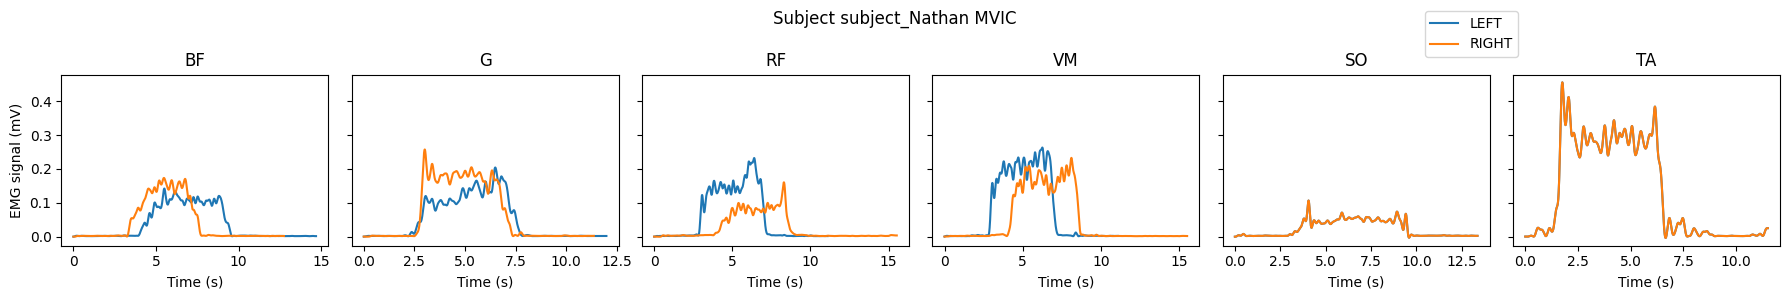

In [66]:
# Frequency of the data in Hz
sampling_freq =  emg_config["FREQUENCY"]  # Frequency in Hz
sampling_interval = 1 / sampling_freq  # Time interval between samples

for subject in subject_data.keys():
    for session in subject_data[subject].keys():    
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        n_cols = filtered_session_data["MVIC"]["LEFT"].shape[1]

        fig, axs = plt.subplots(1, n_cols, figsize=(3*n_cols, 3), sharey=True)
        fig.suptitle(f"Subject {subject} MVIC")

        for i, side in enumerate(filtered_session_data["MVIC"].keys()):
            for j, col in enumerate(filtered_session_data["MVIC"][side].columns):
                
                # Create a time array based on the sampling frequency
                num_samples = len(filtered_session_data["MVIC"][side].index)
                time_array = [k * sampling_interval for k in range(num_samples)]  # Time in seconds
                
                if n_cols == 1:
                    axs.plot(time_array, filtered_session_data["MVIC"][side][col], label=side)
                    axs.set_title(f"{col}")
                    axs.set_xlabel("Time (s)")
                    axs.set_ylabel("EMG signal (mV)")
                    handles, labels = axs.get_legend_handles_labels()
                else:
                    axs[j].plot(time_array, filtered_session_data["MVIC"][side][col], label=side)
                    axs[j].set_title(f"{col.split('_')[0]}")
                    axs[j].set_xlabel("Time (s)")
                    axs[0].set_ylabel("EMG signal (mV)")
                    handles, labels = axs[0].get_legend_handles_labels()

        fig.legend(handles, labels, loc='upper right', fontsize=10, bbox_to_anchor=(0.85, 1))

        plt.tight_layout()
        plt.savefig(subject_dirs[subject][session]['plot_dir'] / f"{subject}_MVIC.svg", dpi=500, bbox_inches='tight', format='svg')
        plt.savefig(latex_figure_dir / "emg_plots" / f"{subject}_MVIC.png", dpi=500, format="png")

### Plot UNFILTERED vs FILTERED EMG

### Plot every muscle activations across iterations and profiles

In [ ]:
def limit_range(df, lower_bound=-0.001, upper_bound=0.001):
    """Limit the values in the DataFrame to the given range, after ensuring all data is numeric."""
    df_numeric = df.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, non-numeric values become NaN
    df_limited = df_numeric.clip(lower=lower_bound, upper=upper_bound)  # Limit the range
    return df_limited

subject = "subject_Nathan"
session = "October_31"
plot_dir = subject_dirs[subject][session]["plot_dir"]
unscaled_emg_dir = plot_dir / "unscaled_emg"
unscaled_emg_dir.mkdir(exist_ok=True)

session_data = subject_data[subject][session]["session_data"]
filtered_session_data = subject_data[subject][session]["filtered_session_data"]

unique_muscles = get_unique_muscles(session_data)


for muscle in ["SO"]: # unique_muscles:
    for profile in session_data["ASSISTED"].keys():
        filename = unscaled_emg_dir / f"EMG_{muscle}_{profile}.svg"

        # Apply the range limiting function here before plotting
        unfiltered_dfs = [limit_range(df) for df in session_data["ASSISTED"][profile]["EMG"]]
        filtered_dfs = [limit_range(df) for df in filtered_session_data["ASSISTED"][profile]["EMG"]]

        plot_muscle_emg(title=f"{muscle} EMG data (unscaled)\n{profile}", 
                target_muscle=muscle,
                unfiltered_dfs=session_data["ASSISTED"][profile]["EMG"],
                filtered_dfs=filtered_session_data["ASSISTED"][profile]["EMG"], 
                freq=emg_config["FREQUENCY"],
                fig_path=filename,
                show=False)

#### Scale based on MVIC

In [8]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        left_mvic_cols = list(filtered_session_data["MVIC"]["LEFT"].columns)
        right_mvic_cols = list(filtered_session_data["MVIC"]["RIGHT"].columns)

        max_left = list(filtered_session_data["MVIC"]["LEFT"].max())
        max_right = list(filtered_session_data["MVIC"]["RIGHT"].max())

        # Create dataframe containing the max values for each muscle, should be 1 row
        mvic_df = pd.DataFrame(data=[max_left + max_right], columns=left_mvic_cols + right_mvic_cols)
        # mvic_df = mvic_df[filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"][0].columns]
        mvic_df = mvic_df[['BF_LEFT', 'BF_RIGHT', 'G_LEFT', 'G_RIGHT', 'RF_LEFT', 'RF_RIGHT', 'VM_LEFT', 'VM_RIGHT', 'SO_LEFT', 'SO_RIGHT', 'TA_LEFT', 'TA_RIGHT']]
        
        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            for i, unpowered_df in enumerate(filtered_session_data["UNPOWERED"][t_unpowered]["EMG"]):
                unpowered_df /= mvic_df.iloc[0]

        for profile in filtered_session_data["ASSISTED"].keys():
            for i, filtered_emg in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                filtered_emg /= mvic_df.iloc[0]

In [ ]:
# Plot every muscle activations across iterations and profiles scaled

subject = "subject_Nathan"
session = "October_31"

session_data = subject_data[subject][session]["session_data"]
filtered_session_data = subject_data[subject][session]["filtered_session_data"]

plot_dir = subject_dirs[subject][session]["plot_dir"]
scaled_emg_dir = plot_dir / "scaled_emg"
scaled_emg_dir.mkdir(exist_ok=True)

unique_muscles = get_unique_muscles(session_data)

print(unique_muscles)
for muscle in unique_muscles:
    for profile in session_data["ASSISTED"].keys():
        filename = scaled_emg_dir / f"EMG_{muscle}_{profile}.svg"

        plot_muscle_emg(title=f"{muscle} EMG data (scaled)\n{profile}", 
                target_muscle=muscle,
                unfiltered_dfs=session_data["ASSISTED"][profile]["EMG"],
                filtered_dfs=filtered_session_data["ASSISTED"][profile]["EMG"], 
                freq=emg_config["FREQUENCY"],
                fig_path=filename,
                show=False)

In [ ]:
# Plot all muscles for one profile and one iteration

subject = "subject_Nathan"
session = "October_31"
session_data = subject_data[subject][session]["session_data"]
filtered_session_data = subject_data[subject][session]["filtered_session_data"]

plot_dir = subject_dirs[subject][session]["plot_dir"]/ "all_muscles_one_profile"
plot_dir.mkdir(exist_ok=True)

unique_muscles = get_unique_muscles(session_data)

# Assisted
for profile in session_data["ASSISTED"].keys():
    for i, filtered_emg in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
        for side in ["LEFT", "RIGHT"]:
            filename = plot_dir / f"EMG_all_muscles_{profile}_iteration{i}.png"

            # Create a new figure for each profile
            plt.figure(figsize=(10, 6))

            # Trim the first 3 seconds and last second
            trimmed_emg = filtered_emg[(filtered_emg.index >= 2.5) & (filtered_emg.index <= (filtered_emg.index[-1] - 0.5))]
        
            # Plot each muscle column with TIME as the x-axis
            for muscle in unique_muscles:
                plt.plot(trimmed_emg.index, trimmed_emg[f"{muscle}_{side}"], label=f"{muscle} {side}")

            # Set the plot labels and title
            plt.xlabel("Time")
            plt.ylabel("EMG Signal")
            plt.title(f"EMG Signals for all muscles in profile {profile}")
            plt.legend(loc="upper right")

            # Save and show the plot
            plt.savefig(filename, format='png')
            plt.show()


# Unpowered
for t_unpowered in session_data["UNPOWERED"].keys():
    for i, filtered_emg in enumerate(filtered_session_data["UNPOWERED"][t_unpowered]["EMG"]):
        for side in ["LEFT", "RIGHT"]:
            filename = plot_dir / f"EMG_all_muscles_{t_unpowered}_iteration{i}.png"

            # Create a new figure for each profile
            plt.figure(figsize=(10, 6))

            # Trim the first 3 seconds and last second
            trimmed_emg = filtered_emg[(filtered_emg.index >= 2.5) & (filtered_emg.index <= (filtered_emg.index[-1] - 0.5))]
        
            # Plot each muscle column with TIME as the x-axis
            for muscle in unique_muscles:
                plt.plot(trimmed_emg.index, trimmed_emg[f"{muscle}_{side}"], label=f"{muscle} {side}")

            # Set the plot labels and title
            plt.xlabel("Time")
            plt.ylabel("EMG Signal")
            plt.title(f"EMG Signals for all muscles in profile {t_unpowered}")
            plt.legend(loc="upper right")

            # Save and show the plot
            plt.savefig(filename, format='png')
            plt.show()
 

#### Scale EMG based on reported peak activation (based on papers)

In [ ]:
enable_paper_scaling = False

# Based on target muscles
muscle_values = {
    "RF": 1,#0.46,
    "BF":1,# 0.16,
    "VM": 0.9,
    "G": 1
}

activation_scaling_factor = {
    "RF_RIGHT": 1,
    "RF_LEFT": 1,
    "BF_RIGHT": 1,
    "BF_LEFT": 1,
    "VM_RIGHT": 1,
    "VM_LEFT": 1,
    "G_RIGHT": 1,
    "G_LEFT": 1
}

subject = "Nathan"
session = "Septmeber_26"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

if enable_paper_scaling:
    for emg_data in filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"]:
        for muscle in emg_data.columns:
            # if "RF" in muscle:
            #     activation_scaling_factor[muscle] = emg_data[muscle].max() / muscle_values["RF"]
            #     emg_data[muscle] /= activation_scaling_factor[muscle] 
            # elif "BF" in muscle:
            #     activation_scaling_factor[muscle] = emg_data[muscle].max() / muscle_values["BF"]
            #     emg_data[muscle] /= activation_scaling_factor[muscle] 
            if "VM" in muscle:
                activation_scaling_factor[muscle] = emg_data[muscle].max() / muscle_values["VM"]
                emg_data[muscle] /= activation_scaling_factor[muscle] 

    for profile in filtered_session_data["ASSISTED"].keys():
        for emg_data in filtered_session_data["ASSISTED"][profile]["EMG"]:
            for muscle in emg_data.columns:
                emg_data[muscle] /= activation_scaling_factor[muscle]

## Process MOTOR data

### Fix wrap-around from motor measurements

In [9]:

# Control variable to toggle the sign
torque_limits = [motor_config[motor]["T_max"] for motor in motor_config.keys()]

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        for profile in filtered_session_data["ASSISTED"].keys():
            motor_data = filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]

            measured_torques = [column for column in motor_data[0].columns if "measured_tau" in column]

            for motor_df in motor_data:
                for torque, jump_threshold in zip(measured_torques, torque_limits):
                    differences = motor_df[torque].diff().fillna(0)

                    # Threshold for detecting a jump
                    toggle_sign = 1

                    corrected_values = []

                    for diff in differences:
                        if abs(diff) > jump_threshold:
                            toggle_sign *= -1
                        corrected_values.append(toggle_sign)
                    motor_df[torque] *= corrected_values

In [10]:
# Calculate forces 
rotate_90 = get_rotation_matrix(90)

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
                
        for profile in filtered_session_data["ASSISTED"].keys():
            for motor_log in filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]:
                measured_torques = motor_log[["measured_tau_1", "measured_tau_2"]].to_numpy()
                measured_torques = measured_torques.reshape(*measured_torques.shape, 1)

                jacobians = get_jacobian(l1=0.44, l2=0.41, theta_1=motor_log["theta_1"].to_numpy(), theta_2=motor_log["theta_2"].to_numpy())
                F = - np.linalg.inv(jacobians.T) @ measured_torques
                # F = - rotate_90[:2, :2] @ np.linalg.inv(jacobians.T) @ measured_torques

                motor_log["F_X"] = F[:, 0]
                motor_log["F_Y"] = F[:, 1]


In [ ]:
# Plot motor data

subject = "subject_Nathan"
session = "October_31"
# profile = "peak_77%_62N"

for profile in subject_data[subject][session]["filtered_session_data"]["ASSISTED"].keys():
    motor_log = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["MOTOR_DATA"]

    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

    plot_dir = subject_dirs[subject][session]["plot_dir"] / "motor_plots"
    filename = plot_dir / f"motor_filtered_{profile}.svg"


    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 5))
    fig.suptitle(profile)

    ax[0].plot(motor_log.index, motor_log["theta_2"], label=r"$\theta_2$", color=colors.__next__())
    handles0, labels0 = ax[0].get_legend_handles_labels()
    ax[0].set_ylabel(r"$\theta_2$ (rad)")


    ax[1].plot(motor_log.index, motor_log["target_tau_1"], label=r"Target $\tau_1$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["measured_tau_1"], label=r"Measured $\tau_1$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["target_tau_2"], label=r"Target $\tau_2$", color=colors.__next__())
    ax[1].plot(motor_log.index, motor_log["measured_tau_2"], label=r"Measured $\tau_2$", color=colors.__next__())
    handles1, labels1 = ax[1].get_legend_handles_labels()
    ax[1].set_ylabel("Torques (Nm)", fontsize=12)

    ax[2].plot(motor_log.index, motor_log["Percentage"], label="STS %", color=colors.__next__())
    ax[2].axhline(y=100, linestyle="--", color="black")
    ax[2].axhline(y=0, linestyle="--", color="black")
    handles2, labels2 = ax[2].get_legend_handles_labels()
    ax[2].set_ylabel("STS %")
    ax[2].set_xlabel('time(s)')

    handles = handles0 + handles1 + handles2
    labels = labels0 + labels1 + labels2
    fig.legend(handles, labels, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 0.93), fontsize=10)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=500, format='svg')
    plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
    plt.show()

In [ ]:
# Plot every muscle for every iteration

subject = "subject_Nathan"
session = "October_31"

# target_muscle = "BF_RIGHT"
# profile = "peak_77%_62N"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

plot_dir = subject_dirs[subject][session]["plot_dir"] / "force_muscle"
plot_dir.mkdir(exist_ok=True)
filename = plot_dir / f"overview_force_muscle.svg"

n_cols = len(filtered_session_data["ASSISTED"].keys())
n_rows = len(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"])

for target_muscle in ["BF_LEFT", "BF_RIGHT", "VM_LEFT", "VM_RIGHT", "G_LEFT", "G_RIGHT", "RF_LEFT", "RF_RIGHT", "TA_RIGHT", "SO_RIGHT"]:
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10), sharey=True)
    fig.suptitle(f"Subject {subject} EMG and force data")   
    for i, profile in enumerate(filtered_session_data["ASSISTED"].keys()):
        words = profile.split('_')
        axs[0, i].set_title('_'.join(words[-2:]))
        for j, motor_df in enumerate(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]):
            emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][j]

            # Remove the first 3 seconds of EMG data
            emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
            emg_data = emg_data[emg_data.index <= 5.5]  # Crop data after 2.5 seconds (3s to 5.5s)
            emg_data.index = emg_data.index - 3  # Reset index to start from 0

            # Remove everything after 2.5 Seconds in the motor data
            motor_df = motor_df[motor_df.index <= 2.5]  # Crop data after 2.5 seconds

            # Plot force values on the primary y-axis
            axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"Applied force $F_Y$", color='orange')
            axs[j, i].tick_params(axis='y', labelcolor='orange')

            # Create a secondary y-axis for EMG data
            ax2 = axs[j, i].twinx()
            ax2.plot(emg_data.index, emg_data[target_muscle], label=target_muscle, color=u'#1f77b4')
            ax2.set_ylim(0, 1)  # Set EMG activation scale from 0 to 1
            
            if i == len(filtered_session_data["ASSISTED"].keys()) - 1:
                ax2.set_ylabel('EMG (% MVIC)', color='black')
            ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
            ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

            axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
            axs[-1, i].set_xlabel("Time (s)")

            handles, labels = axs[j, i].get_legend_handles_labels()
            handles2, labels2 = ax2.get_legend_handles_labels()
            handles += handles2
            labels += labels2

    fig.legend(handles, labels, loc='upper center', ncols=2, bbox_to_anchor=(0.5, 0.96), fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    # plt.savefig(filename, dpi=500, format='svg')
    plt.savefig(plot_dir / f"{target_muscle}_{filename.with_suffix('.png').name}", dpi=500, format="png")
    plt.show()

### Calculate the relevant time window through IMU



In [11]:
# Calculate all the start and end times best on the imu data

time_range = namedtuple("TimeRange", ["min", "max"])


for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        plot_dir = subject_dirs[subject][session]["plot_dir"] / "imu_segmentation"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges_imu = {}
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        for profile in filtered_session_data["ASSISTED"].keys():
            relevant_time_ranges_imu[profile] = {"ranges": []}
            imu_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["IMU"]
            # emg_data = filtered_session_data["ASSISTED"][profile]["EMG"]
            emg_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["EMG"]
            log_data = subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["LOG"]

            for i, imu_df in enumerate(imu_data):
                emg_df = emg_data[i]
                
                # Filter imu_data
                imu_df_filtered = apply_lowpass_filter(imu_df, 1, 518.519)

                imu_time_interval = 1 / 518.519
                
                if i < len(log_data):
                    log_df = log_data[i].copy()
                    # Add the global time to log data
                    log_df['Start Time'] += log_df['Segment Start Index']
                    log_df['End Time'] += log_df['Segment Start Index']

                    # Convert log data to time
                    log_df['Start Time'] = log_df['Start Time'] * imu_time_interval
                    log_df['End Time'] = log_df['End Time'] * imu_time_interval
                    log_df['Segment Start Index'] = log_df['Segment Start Index'] * imu_time_interval
                    log_df['Segment End Index'] = log_df['Segment End Index'] * imu_time_interval
                
                else:
                    log_df = pd.DataFrame()

                start_time, end_time = segmentation(imu_df_filtered)
                
                relevant_time_ranges_imu[profile]["ranges"].append(time_range(start_time, end_time))

                # plot_collected_and_calculated_imu_data(imu_df_filtered, emg_df, log_df, plot_dir, start_time, end_time, profile, i)


        for unassisted_time in filtered_session_data["UNPOWERED"].keys():
            relevant_time_ranges_imu[f"UNPOWERED_{unassisted_time}"] = {"ranges": []}
            imu_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["IMU"]
            emg_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["EMG"]
            log_data = subject_data[subject][session]["filtered_session_data"]["UNPOWERED"][unassisted_time]["LOG"]

            for i, imu_df in enumerate(imu_data):
                emg_df = emg_data[i]
                
                # Filter imu_data
                imu_df_filtered = apply_lowpass_filter(imu_df, 1, 518.519)

                imu_time_interval = 1 / 518.519

                if i < len(log_data):
                    log_df = log_data[i].copy()
                    # Add the global time to log data
                    log_df['Start Time'] += log_df['Segment Start Index']
                    log_df['End Time'] += log_df['Segment Start Index']

                    # Convert log data to time
                    log_df['Start Time'] = log_df['Start Time'] * imu_time_interval
                    log_df['End Time'] = log_df['End Time'] * imu_time_interval
                    log_df['Segment Start Index'] = log_df['Segment Start Index'] * imu_time_interval
                    log_df['Segment End Index'] = log_df['Segment End Index'] * imu_time_interval
                
                else:
                    log_df = pd.DataFrame()

                start_time, end_time = segmentation(imu_df_filtered)
                
                relevant_time_ranges_imu[f"UNPOWERED_{unassisted_time}"]["ranges"].append(time_range(start_time, end_time))

                # plot_collected_and_calculated_imu_data(imu_df_filtered, emg_df, log_df, plot_dir, start_time, end_time, f"UNPOWERED_{unassisted_time}", i)

        subject_data[subject][session]["relevant_time_ranges_imu"] = relevant_time_ranges_imu


In [ ]:
for profile in subject_data[subject][session]["filtered_session_data"]["ASSISTED"].keys():
    
    for i, motor_log in enumerate(subject_data[subject][session]["filtered_session_data"]["ASSISTED"][profile]["MOTOR_DATA"]):

        # Extract the relevant time frame
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"][profile]["ranges"][i]
        min_trim = relevant_time_ranges.min - 3 
        max_trim = relevant_time_ranges.max - 3

        # Crop the motor data
        motor_log = motor_log[(motor_log.index >= min_trim) & (motor_log.index <= max_trim)]


        colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "motor_plots"
        filename = plot_dir / f"motor_filtered_{profile}_cropped_{i}.svg"


        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 5))
        fig.suptitle(profile)

        ax[0].plot(motor_log.index, motor_log["theta_2"], label=r"$\theta_2$", color=colors.__next__())
        handles0, labels0 = ax[0].get_legend_handles_labels()
        ax[0].set_ylabel(r"$\theta_2$ (rad)")
        # add a vertical line at the start and end of the relevant time frame
        ax[0].axvline(x=min, color='red', linestyle='--')
        ax[0].axvline(x=max, color='red', linestyle='--')

        ax[1].plot(motor_log.index, motor_log["target_tau_1"], label=r"Target $\tau_1$", color=colors.__next__())
        ax[1].plot(motor_log.index, motor_log["measured_tau_1"], label=r"Measured $\tau_1$", color=colors.__next__())
        ax[1].plot(motor_log.index, motor_log["target_tau_2"], label=r"Target $\tau_2$", color=colors.__next__())
        ax[1].plot(motor_log.index, motor_log["measured_tau_2"], label=r"Measured $\tau_2$", color=colors.__next__())
        # add a vertical line at the start and end of the relevant time frame
        ax[1].axvline(x=min, color='red', linestyle='--')
        ax[1].axvline(x=max, color='red', linestyle='--')
        handles1, labels1 = ax[1].get_legend_handles_labels()
        ax[1].set_ylabel("Torques (Nm)", fontsize=12)

        ax[2].plot(motor_log.index, motor_log["Percentage"], label="STS %", color=colors.__next__())
        ax[2].axhline(y=100, linestyle="--", color="black")
        ax[2].axhline(y=0, linestyle="--", color="black")
        # add a vertical line at the start and end of the relevant time frame
        ax[2].axvline(x=min, color='red', linestyle='--')
        ax[2].axvline(x=max, color='red', linestyle='--')
        handles2, labels2 = ax[2].get_legend_handles_labels()
        ax[2].set_ylabel("STS %")
        ax[2].set_xlabel('time(s)')

        handles = handles0 + handles1 + handles2
        labels = labels0 + labels1 + labels2
        fig.legend(handles, labels, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 0.93), fontsize=10)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(filename, dpi=500, format='svg')
        plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
        plt.show()

### Average STS duration across profiles and subjects

In [ ]:
# Extract durations from the time ranges
fig, ax = plt.subplots(1, ncols=len(subject_data.keys()), figsize=(10, 5))
fig.suptitle("Durations per profile and subject")

# Ensure `ax` is always a list
if len(subject_data.keys()) == 1:
    ax = [ax]

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        durations = {profile: [time_range.max - time_range.min for time_range in time_ranges["ranges"]] for profile, time_ranges in relevant_time_ranges.items()}

        # Drop empty keys
        durations = {k: v for k, v in durations.items() if v}

        # Sort and create DataFrame
        durations = dict(sorted(durations.items()))
        durations_df = pd.DataFrame.from_dict(durations, orient='index').T

        # Plot mean and std of the durations
        durations_df.mean().plot(kind='bar', yerr=durations_df.std(), ax=ax[i])
        ax[i].set_ylabel("Duration (s)")
        ax[i].set_xlabel("Profile")
        ax[i].set_title(f"Subject {subject}")
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig("../paper_figures/durations_per_profile.svg", format='svg')
plt.savefig("../paper_figures/durations_per_profile.png", dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / "durations_per_profile.png", dpi=500, format="png")
plt.show()


### Time windows across all iterations

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        motor_data_dfs = filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][0]

        for power in filtered_session_data["UNPOWERED"].keys():
            motor_data_dfs = filtered_session_data["UNPOWERED"][power]["MOTOR_DATA"]

            for j, motor_df in enumerate(motor_data_dfs):
                # Filter out data to look only for indices after 0.1 seconds
                motor_df_after_01s = motor_df[motor_df.index > 0.2]
                # print(motor_df_after_01s["Percentage"])
                start_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 10].index.min()
                stop_index = motor_df_after_01s[motor_df_after_01s['Percentage'] > 85].index.min()

                plt.plot(motor_df_after_01s.index, motor_df_after_01s["Percentage"])
                plt.axvline(x=start_index-0.05, color='r', linestyle='--')
                plt.axvline(x=stop_index+0.1, color='r', linestyle='--')
                plt.show()
                

In [ ]:
# Manually remove one iteration
# print(filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"][4])
# print(filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][4])

# filtered_session_data["UNPOWERED"]["BEFORE"]["EMG"].pop(4)
# filtered_session_data["UNPOWERED"]["BEFORE"]["MOTOR_DATA"].pop(4)

In [71]:
# Iterate through all profiles and calculate the mean muscle activation during the relevant time period
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        mean_muscle_activations = {}


        for profile in filtered_session_data["ASSISTED"].keys():
            mean_muscle_activations[profile] = []

            for i, emg_data in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[profile]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]
                mean_muscle_activations[profile].append(emg_data.mean())
                

        for unpowered_time in filtered_session_data["UNPOWERED"].keys():
            mean_muscle_activations[f"UNPOWERED_{unpowered_time}"] = []

            for i, emg_data in enumerate(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"]):
                # emg_data = emg_data[emg_data.index >= 3]
                # emg_data.index = emg_data.index - 3
                time_range = relevant_time_ranges[f"UNPOWERED_{unpowered_time}"]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                mean_muscle_activations[f"UNPOWERED_{unpowered_time}"].append(emg_data.mean())

        subject_data[subject][session]["mean_muscle_activations"] = mean_muscle_activations


In [ ]:
# Iterate through all profiles and calculate and plot a mean profile for each profile over all 5 iterations
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]

        mean_muscle_activations = {}

        mean_muscle_activations = subject_data[subject][session]["mean_muscle_activations"]

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "mean_muscle_activation_profiles"
        plot_dir.mkdir(exist_ok=True)

        mean_profiles = {}
        total_activation = {}

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for unpowered_time in filtered_session_data["UNPOWERED"].keys():
            mean_activation_profile = pd.DataFrame()

            for i, emg_data in enumerate(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"]):
                 # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[f"UNPOWERED_{unpowered_time}"]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.4) & (emg_data.index <= 1.8)]
                if mean_activation_profile.empty:
                    mean_activation_profile = emg_data/len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
                else:
                    # Reindex both DataFrames to the union of their indices to handle different lengths
                    common_index = mean_activation_profile.index.union(emg_data.index)
                    # Reindex both DataFrames to the common index and fill missing values with 0
                    mean_activation_profile = mean_activation_profile.reindex(common_index, fill_value=0)
                    emg_data = emg_data.reindex(common_index, fill_value=0)
                    # Add the reindexed emg_data to mean_activation_profile
                    mean_activation_profile += emg_data / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])

            # Sum over all muscles to get mean activation profile
            mean_activation_profile = mean_activation_profile.sum(axis=1) / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
            mean_profiles[f"UNPOWERED_{unpowered_time}"] = mean_activation_profile

            # Get are under the curve for the mean activation profile
            total_activation[f"UNPOWERED_{unpowered_time}"] = mean_activation_profile.sum()/len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])

        
        for profile in filtered_session_data["ASSISTED"].keys():
            mean_activation_profile = pd.DataFrame()

            for i, emg_data in enumerate(filtered_session_data["ASSISTED"][profile]["EMG"]):
                # Remove the first 3 seconds of EMG data
                # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                time_range = relevant_time_ranges[profile]["ranges"][i]
                emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                # emg_data = emg_data[(emg_data.index >= 0.4) & (emg_data.index <= 1.8)]
                if mean_activation_profile.empty:
                    mean_activation_profile = emg_data/len(filtered_session_data["ASSISTED"][profile]["EMG"])
                else:
                    # Reindex both DataFrames to the union of their indices to handle different lengths
                    common_index = mean_activation_profile.index.union(emg_data.index)
                    # Reindex both DataFrames to the common index and fill missing values with 0
                    mean_activation_profile = mean_activation_profile.reindex(common_index, fill_value=0)
                    emg_data = emg_data.reindex(common_index, fill_value=0)
                    # Add the reindexed emg_data to mean_activation_profile
                    mean_activation_profile += emg_data / len(filtered_session_data["UNPOWERED"][unpowered_time]["EMG"])
            
            # Get are under the curve for the mean activation profile
            total_activation[profile] = mean_activation_profile.sum()/len(filtered_session_data["ASSISTED"][profile]["EMG"])

            # Sum over all muscles to get mean activation profile
            mean_activation_profile = mean_activation_profile.sum(axis=1) / len(filtered_session_data["ASSISTED"][profile]["EMG"])
            mean_profiles[profile] = mean_activation_profile
            
            filename = plot_dir / f"mean_activation_profile_percentage{profile}"
            
            # Plot both unassisted mean profiles in addition to the current assisted profile
            fig, ax = plt.subplots(1, figsize=(10, 5))
            fig.suptitle(f"Mean muscle activation profile\n{subject} - {profile}")

            for unpowered_time in filtered_session_data["UNPOWERED"].keys():
                ax.plot(mean_profiles[f"UNPOWERED_{unpowered_time}"].index, mean_profiles[f"UNPOWERED_{unpowered_time}"], label=f"UNPOWERED_{unpowered_time}")

            ax.plot(mean_profiles[profile].index, mean_profiles[profile], label=profile)
            ax.set_ylabel("Mean activation")
            ax.set_xlabel("Time (s)")
            ax.legend()
            plt.tight_layout()
            plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            plt.show()
        
        # Plot the total activation for each profile
        fig, ax = plt.subplots(1, figsize=(10, 5))
        fig.suptitle(f"Total muscle activation\n{subject}")
        for profile in total_activation.keys():
            ax.bar(profile, total_activation[profile], label=profile)
        ax.set_ylabel("Total activation")
        ax.set_xlabel("Profile")
        # ax.legend()
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig(plot_dir / "total_activation_percentage", dpi=500, format='svg')
        plt.savefig(plot_dir / "total_activation_percentage.png", dpi=500, format='png')
        plt.show()


### Time windows across all iterations

In [ ]:
subject = "subject_Nathan"
session = "Ocotber_31"
# profile = "Camille_no_counter"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["filtered_session_data"])
relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges"]

filename = subject_dirs[subject][session]["plot_dir"] / f"unpowered_activations.svg"

fig, axs = plt.subplots(nrows=2, ncols=5, sharex='col', figsize=(20, 5))
fig.suptitle(f"Unpowered activations (BEFORE trials)\n{subject}")

t_unpowered = "BEFORE"

target_muscle = random.choice(unique_muscles)

for i, t_range in enumerate(relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"]):
    colors = iter(rcParams['axes.prop_cycle'].by_key()['color'])
    # marker_data = filtered_session_data["UNPOWERED"][t_unpowered]["MARKER_DATA"][i]

    # Remove the first 3 seconds of EMG data
    emg_data = filtered_session_data["UNPOWERED"][t_unpowered]["EMG"][i]
    emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
    emg_data.index = emg_data.index - 3  # Reset index to start from 0
    time_range = relevant_time_ranges[profile]["ranges"][i]
    emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
    # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]

    motor_data = filtered_session_data["UNPOWERED"][t_unpowered]["MOTOR_DATA"][i]
    motor_data = motor_data[(motor_data.index >= time_range.min) & (motor_data.index <= time_range.max)]
    # motor_data = motor_data[(motor_data.index >= 0.5) & (motor_data.index <= 1.7)]


    # axs[0, i].set_title(f"unpowered_{i}")
    # axs[0, i].plot(marker_data.index, marker_data["Hip Left Z"], label="Hip Z", color=colors.__next__())
    # axs[0, i].set_ylabel("Hip Z (m)")
    # axs[0, i].axvline(t_range.min, linestyle='--', color="red")
    # axs[0, i].axvline(t_range.max, linestyle='--', color="red")
    
    # handles0, labels0 = axs[0, i].get_legend_handles_labels()

    axs[0, i].plot(motor_data.index, motor_data["theta_2"], colors.__next__(), label=r"$\theta_2$")
    axs[0, i].set_ylabel(r"$\theta_2$ (rad)")
    axs[0, i].axvline(t_range.min, linestyle='--', color="red")
    axs[0, i].axvline(t_range.max, linestyle='--', color="red")

    handles1, labels1 = axs[0, i].get_legend_handles_labels()

    axs[1, i].plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle}_LEFT", color=colors.__next__())
    axs[1, i].plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle}_RIGHT", color=colors.__next__())
    axs[1, i].set_xlabel("Time (s)")
    axs[1, i].set_ylabel("EMG (% of MVIC)")
    axs[1, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    axs[1, i].axvline(t_range.min, linestyle='--', color="red")
    axs[1, i].axvline(t_range.max, linestyle='--', color="red")

    axs[1, i].set_ylim(0, 1)

    handles2, labels2 = axs[1, i].get_legend_handles_labels()

handles = handles1 + handles2 # + handles0
labels = labels1 + labels2 # + labels0 

fig.legend(handles, labels, loc='upper center', ncols=len(handles), bbox_to_anchor=(0.5, 0.9), fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.show()

### Full data corresponding to 1 iteration per profile

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        for target_muscle in unique_muscles:
            n_rows = 5
            n_cols = len(filtered_session_data["ASSISTED"].keys())

            plot_dir = subject_dirs[subject][session]["plot_dir"] / "force_muscle"
            filename = plot_dir / f"overview_force_muscle_crossed_{target_muscle}"

            relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), sharey='row')
            fig.suptitle(f"Subject {subject}, Session {session}\nForce and EMG per profile")

            filtered_session_data = subject_data[subject][session]["filtered_session_data"]
            for i, profile in enumerate(filtered_session_data["ASSISTED"].keys()):
                words = profile.split('_')
                axs[0, i].set_title('_'.join(words[-2:]))

                
                for j, motor_df in enumerate(filtered_session_data["ASSISTED"][profile]["MOTOR_DATA"]):
                    emg_data = filtered_session_data["ASSISTED"][profile]["EMG"][j]

                    # Remove the first 3 seconds of EMG data
                    # emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
                    # emg_data.index = emg_data.index - 3  # Reset index to start from 0
                    time_range = relevant_time_ranges[profile]["ranges"][j]
                    emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
                    # emg_data = emg_data[(emg_data.index >= 0.2) & (emg_data.index <= 1.9)]

                    motor_df = motor_df[(motor_df.index >= time_range.min) & (motor_df.index <= time_range.max)]
                    # motor_df = motor_df[(motor_df.index >= 0.2) & (motor_df.index <= 1.9)]

                    # Plot force values on the primary y-axis
                    # axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color='orange')
                    # axs[j, i].plot(motor_df.index, motor_df.F_X, label=r"$F_X$", color='red')
                    axs[j, i].tick_params(axis='y', labelcolor='orange')

                    # Create a secondary y-axis for EMG data
                    ax2 = axs[j, i].twinx()
                    ax2.plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color='green')
                    ax2.plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=u'#1f77b4')
                    ax2.set_ylim(0, 0.2)  # Set EMG activation scale from 0 to 1

                    if i == len(profiles) - 1:
                        ax2.set_ylabel('EMG (% MVIC)', color=u'#1f77b4')
                    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
                    ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

                    handles1, labels1 = axs[j, i].get_legend_handles_labels()
                    handles2, labels2 = ax2.get_legend_handles_labels()
                    handles = handles1 + handles2
                    labels = labels1 + labels2

                    axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
                    axs[-1, i].set_xlabel("Time (s)")

            fig.legend(handles, labels, loc="upper right", ncols=len(handles), bbox_to_anchor=(0.6, 0.93))
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            shutil.copy(filename.with_suffix('.png'), latex_figure_dir / "emg_plots")
            plt.show()

In [ ]:
# same for unpowered data
subject = "subject_Nathan"
session = "September_26"
t_unpowered = "BEFORE"

filtered_session_data = subject_data[subject][session]["filtered_session_data"]

n_rows = len(filtered_session_data["UNPOWERED"][t_unpowered]["MOTOR_DATA"])
n_cols = len(filtered_session_data["UNPOWERED"].keys())

target_muscle = "G"

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"overview_force_muscle_unpowered_{target_muscle}.svg"

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2), sharey='row')
fig.suptitle(f"Subject {subject}, Session {session}\nForce and EMG per profile")

for i, profile in enumerate(filtered_session_data["UNPOWERED"].keys()):

    words = profile.split('_')
    axs[0, i].set_title('_'.join(words[-2:]))

    
    for j, motor_df in enumerate(filtered_session_data["UNPOWERED"][profile]["MOTOR_DATA"]):
        emg_data = filtered_session_data["UNPOWERED"][profile]["EMG"][j]

        # Remove the first 3 seconds of EMG data
        emg_data = emg_data[emg_data.index >= 3]  # Keep data from 3 seconds onwards
        emg_data.index = emg_data.index - 3  # Reset index to start from 0
        # time_range = relevant_time_ranges[profile]["ranges"][j]
        emg_data = emg_data[(emg_data.index >= time_range.min) & (emg_data.index <= time_range.max)]
        # emg_data = emg_data[(emg_data.index >= 0.5) & (emg_data.index <= 1.7)]

        motor_df = motor_df[(motor_df.index >= time_range.min) & (motor_df.index <= time_range.max)]
        # motor_df = motor_df[(motor_df.index >= 0.5) & (motor_df.index <= 1.7)]

        # Plot force values on the primary y-axis
        # axs[j, i].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color='orange')
        # axs[j, i].tick_params(axis='y', labelcolor='orange')

        # Create a secondary y-axis for EMG data
        ax2 = axs[j, i].twinx()
        ax2.plot(emg_data.index, emg_data[f"{target_muscle}_RIGHT"], label=f"{target_muscle} RIGHT", color='green')
        ax2.plot(emg_data.index, emg_data[f"{target_muscle}_LEFT"], label=f"{target_muscle} LEFT", color=u'#1f77b4')
        ax2.set_ylim(0, 0.1)  # Set EMG activation scale from 0 to 1

        if i == len(profiles) - 1:
            ax2.set_ylabel('EMG (% MVIC)', color=u'#1f77b4')
        ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
        ax2.tick_params(axis='y', labelcolor=u'#1f77b4')

        handles1, labels1 = axs[j, i].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2

        axs[j, 0].set_ylabel(f"Iteration {j+1}\nForce (N)")
        axs[-1, i].set_xlabel("Time (s)")

fig.legend(handles, labels, loc="upper right", ncols=len(handles), bbox_to_anchor=(0.6, 0.93))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
shutil.copy(filename.with_suffix('.png'), latex_figure_dir / "emg_plots")
plt.show()

### Trim all dataframes based on relevant TIME window

In [12]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        trimmed_time_dfs = {"ASSISTED": dict(), "UNPOWERED": dict()}

        for profile in filtered_session_data["ASSISTED"].keys():
            rel_ranges = relevant_time_ranges[profile]["ranges"] # Get first iteration range
            trimmed_time_dfs["ASSISTED"][profile] = deepcopy(data_dict)

            emg_dfs, motor_dfs, imu_dfs, log = filtered_session_data["ASSISTED"][profile].values()

            trimmed_time_dfs["ASSISTED"][profile]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"] = [motor_df.loc[rel_range.min-3:rel_range.max-3] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["IMU"] = [imu_df.loc[rel_range.min:rel_range.max] for imu_df, rel_range in zip(imu_dfs, rel_ranges)]

            for motor_df, rel_range in zip(motor_dfs, rel_ranges):
                if rel_range.min-3 > motor_df.index[-1]:
                    print("Warning: cut-off range starts after motor data. Keeping whole range")
                    rel_range = rel_range._replace(min=motor_df.index[0])
                # trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"].append(motor_df.loc[rel_range.min:rel_range.max])

        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            rel_ranges = relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"] # Get first iteration range

            trimmed_time_dfs["UNPOWERED"][t_unpowered] = deepcopy(data_dict)

            emg_dfs, motor_dfs, imu_dfs, log = filtered_session_data["UNPOWERED"][t_unpowered].values()

            trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MOTOR_DATA"] = [motor_df.loc[rel_range.min-3:rel_range.max-3] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["IMU"] = [imu_df.loc[rel_range.min:rel_range.max] for imu_df, rel_range in zip(imu_dfs, rel_ranges)]
        
        subject_data[subject][session]["trimmed_time_dfs"] = trimmed_time_dfs

## Discretize STS from time to phase percentage

In [13]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu,log = trimmed_time_dfs["ASSISTED"][profile].values()

            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                imu[i].reset_index(inplace=True)

                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                imu[i].index = (imu[i].index - imu[i].index.min())/(imu[i].index.max() - imu[i].index.min()) * 100

                emg[i].set_index(emg[i].index, inplace=True)
                imu[i].set_index(imu[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                imu[i].index.name = "Percentage"

                if len(motor) > i:
                    motor[i].reset_index(inplace=True)
                    motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                    motor[i].set_index(motor[i].index, inplace=True)
                    motor[i].index.name = "Percentage"


        for unpowered_moment in trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, imu, log = trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()
            
            for i in range(len(emg)):
                emg[i].reset_index(inplace=True)
                imu[i].reset_index(inplace=True)
                
                emg[i].index = (emg[i].index - emg[i].index.min())/(emg[i].index.max() - emg[i].index.min()) * 100
                imu[i].index = (imu[i].index - imu[i].index.min())/(imu[i].index.max() - imu[i].index.min()) * 100


                emg[i].set_index(emg[i].index, inplace=True)
                imu[i].set_index(imu[i].index, inplace=True)

                emg[i].index.name = "Percentage"
                imu[i].index.name = "Percentage"

                if len(motor) > i:
                    motor[i].reset_index(inplace=True)
                    motor[i].index = (motor[i].index - motor[i].index.min())/(motor[i].index.max() - motor[i].index.min()) * 100
                    motor[i].set_index(motor[i].index, inplace=True)
                    motor[i].index.name = "Percentage"


In [14]:
# Go through all profiles, for each profile, find the longest and interpolate the other profiles to match the longest, then calculate the average over all profiles
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        averaged_trimmed_time_dfs = deepcopy(subject_data[subject][session]["trimmed_time_dfs"])

        longest_profile = pd.DataFrame()
        longest_profile_current = pd.DataFrame()

        # Find the longest profile
        for profile in averaged_trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs["ASSISTED"][profile].values()
            longest_profile_current = max(emg, key=lambda x: x.shape[0])

            if longest_profile_current.shape[0] > longest_profile.shape[0]:
                longest_profile = longest_profile_current

        for unpowered_moment in averaged_trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()
            longest_profile_current = max(emg, key=lambda x: x.shape[0])

            if longest_profile_current.shape[0] > longest_profile.shape[0]:
                longest_profile = longest_profile_current

        # Interpolate the other profiles to match the longest profile
        for profile in averaged_trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs["ASSISTED"][profile].values()
            for i in range(len(emg)):
                if emg[i].shape[0] != longest_profile.shape[0]:
                    emg[i] = emg[i].reindex(longest_profile.index, method='nearest')

            # Interpolated data is saved back to the dictionary
            subject_data[subject][session]["trimmed_time_dfs"]["ASSISTED"][profile]["EMG"] = emg

            # Calculate the average over all profiles
            emg_avg = sum(emg)/len(emg)

            averaged_trimmed_time_dfs["ASSISTED"][profile]["EMG"] = emg_avg

        
        # Average over all unpowered profiles ('BEFORE' and 'AFTER')
        for unpowered_moment in averaged_trimmed_time_dfs['UNPOWERED'].keys():
            emg, motor, imu, log = averaged_trimmed_time_dfs['UNPOWERED'][unpowered_moment].values()

            # Interpolate the other profiles to match the longest profile
            for i in range(len(emg)):
                if emg[i].shape[0] != longest_profile.shape[0]:
                    emg[i] = emg[i].reindex(longest_profile.index, method='nearest')

            # Interpolated data is saved back to the dictionary
            subject_data[subject][session]["trimmed_time_dfs"]['UNPOWERED'][unpowered_moment]["EMG"] = emg

            # Calculate the average over all profiles
            emg_avg = sum(emg)/len(emg)

            averaged_trimmed_time_dfs['UNPOWERED'][unpowered_moment]["EMG"] = emg_avg

        emg_avg_unpowered_before = averaged_trimmed_time_dfs['UNPOWERED']['BEFORE']["EMG"]
        emg_avg_unpowered_after = averaged_trimmed_time_dfs['UNPOWERED']['AFTER']["EMG"]
        
        emg_avg_unpowered = (emg_avg_unpowered_before + emg_avg_unpowered_after) / 2

        averaged_trimmed_time_dfs['UNPOWERED']["EMG"] = emg_avg_unpowered

        subject_data[subject][session]["averaged_trimmed_time_dfs"] = averaged_trimmed_time_dfs
        

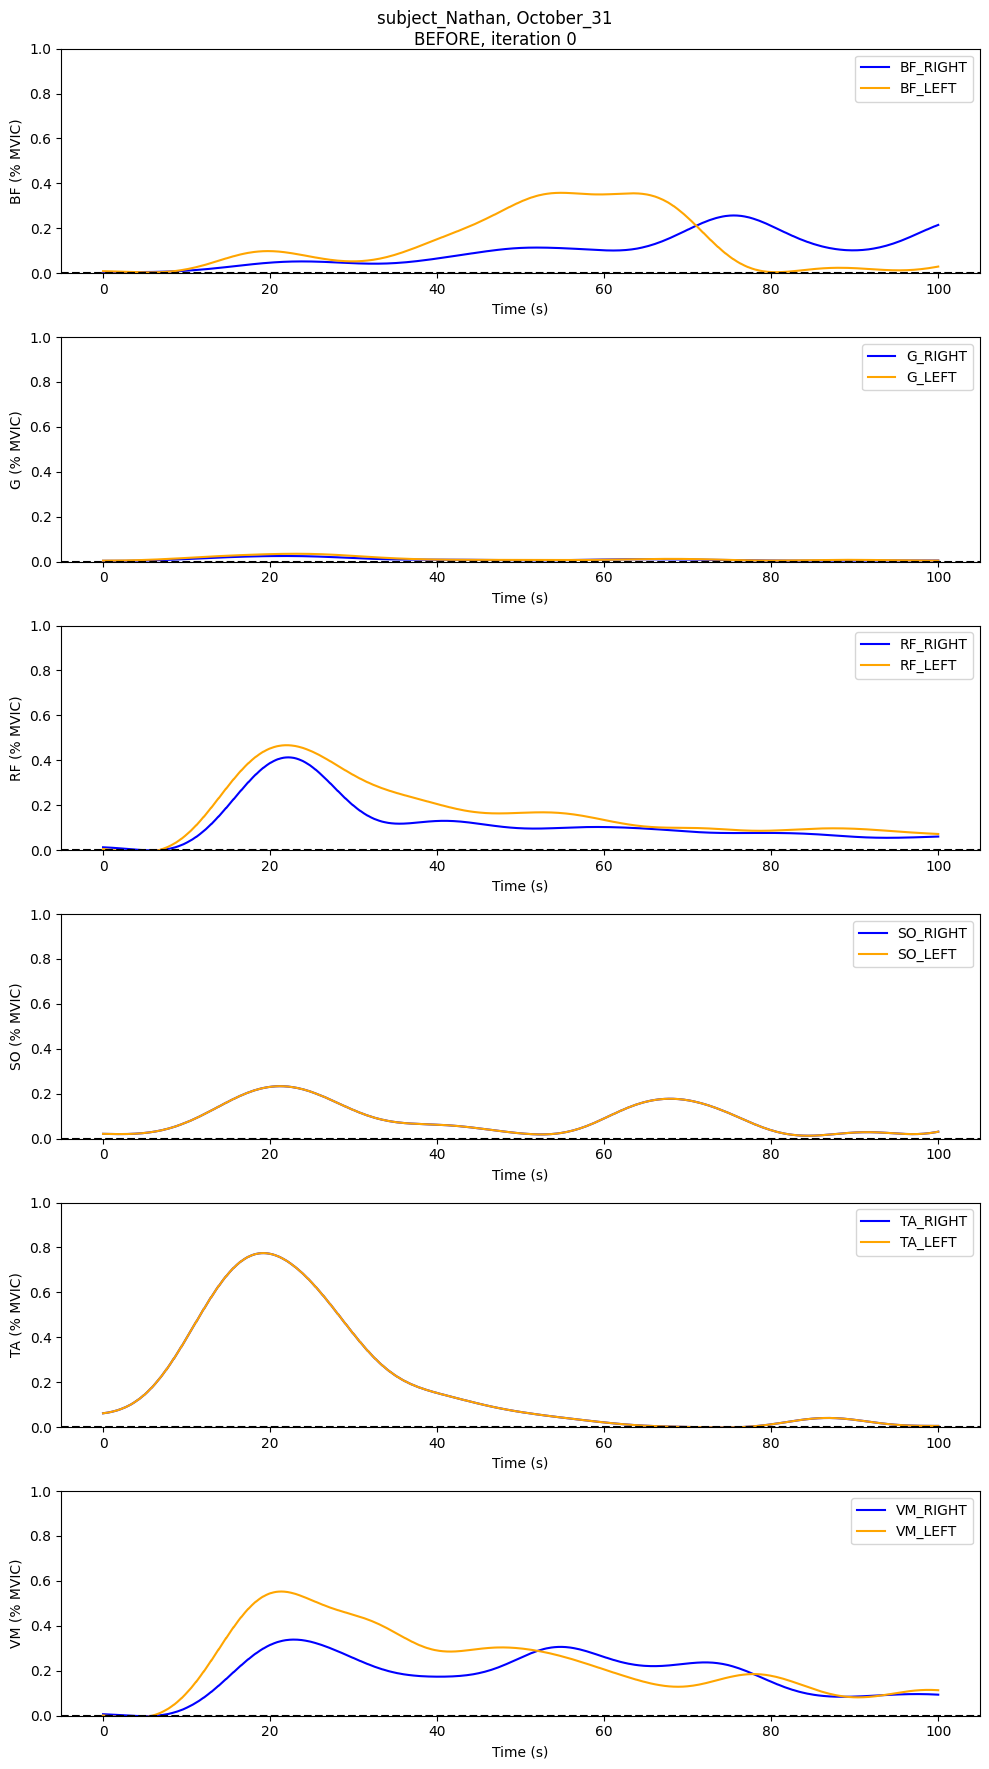

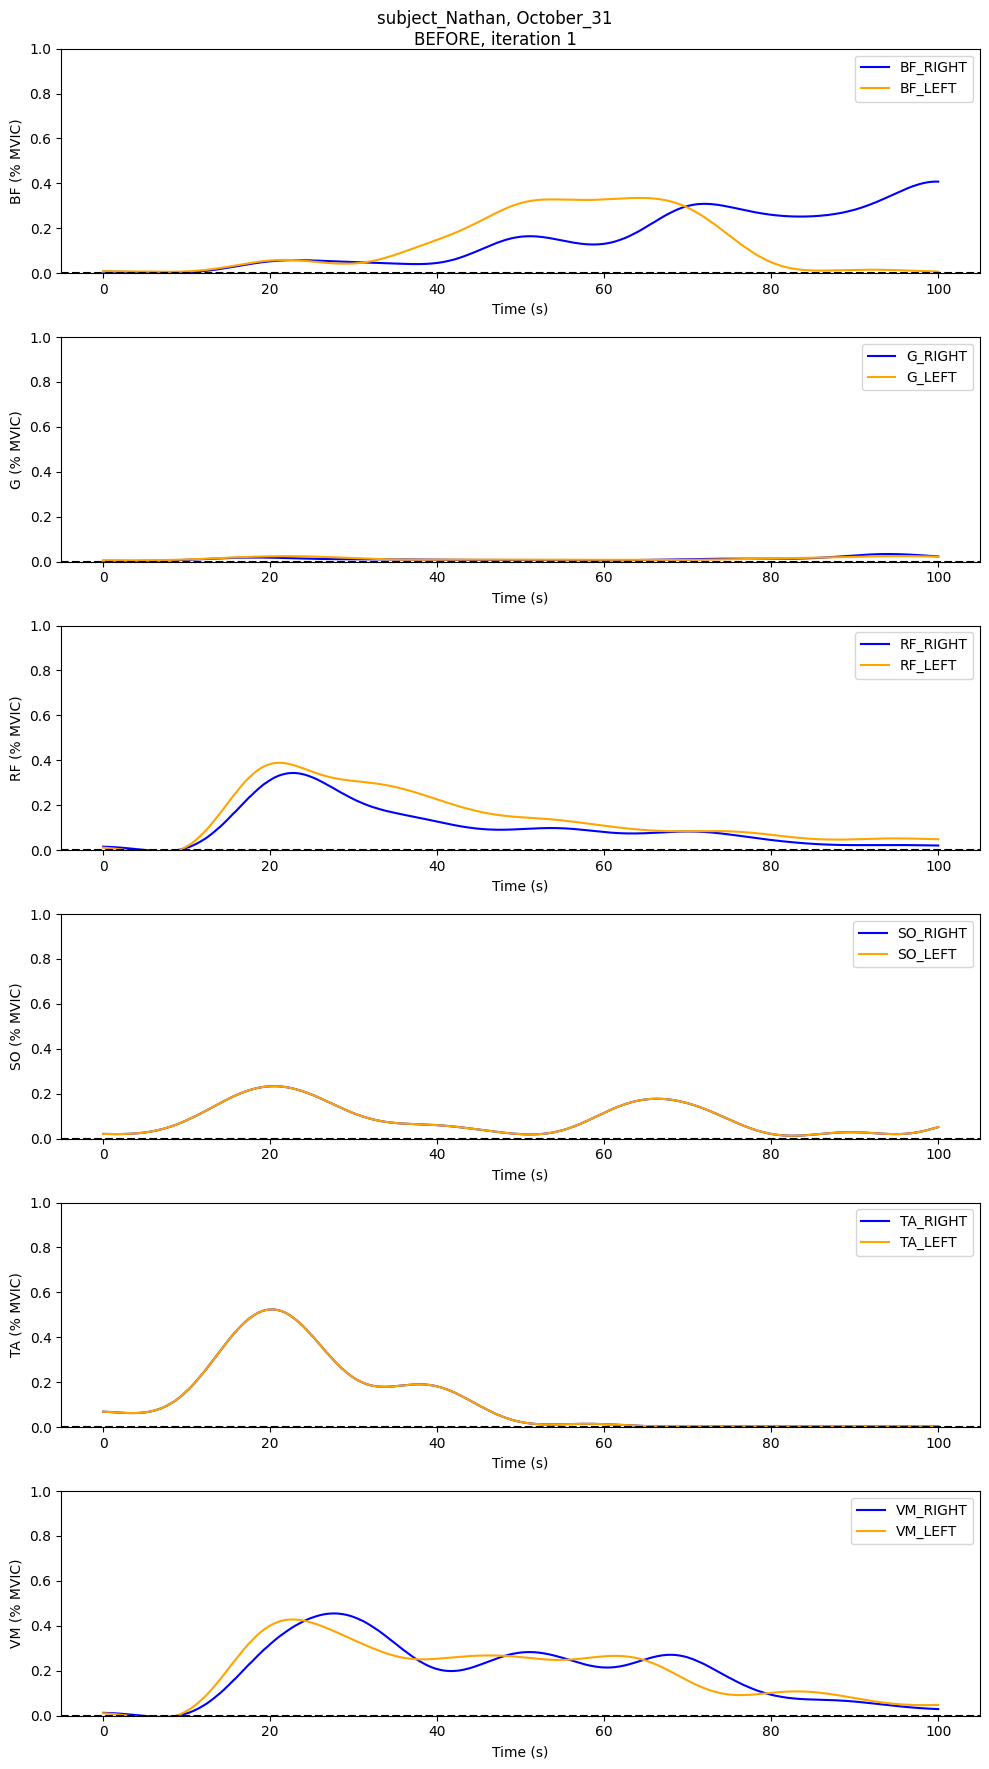

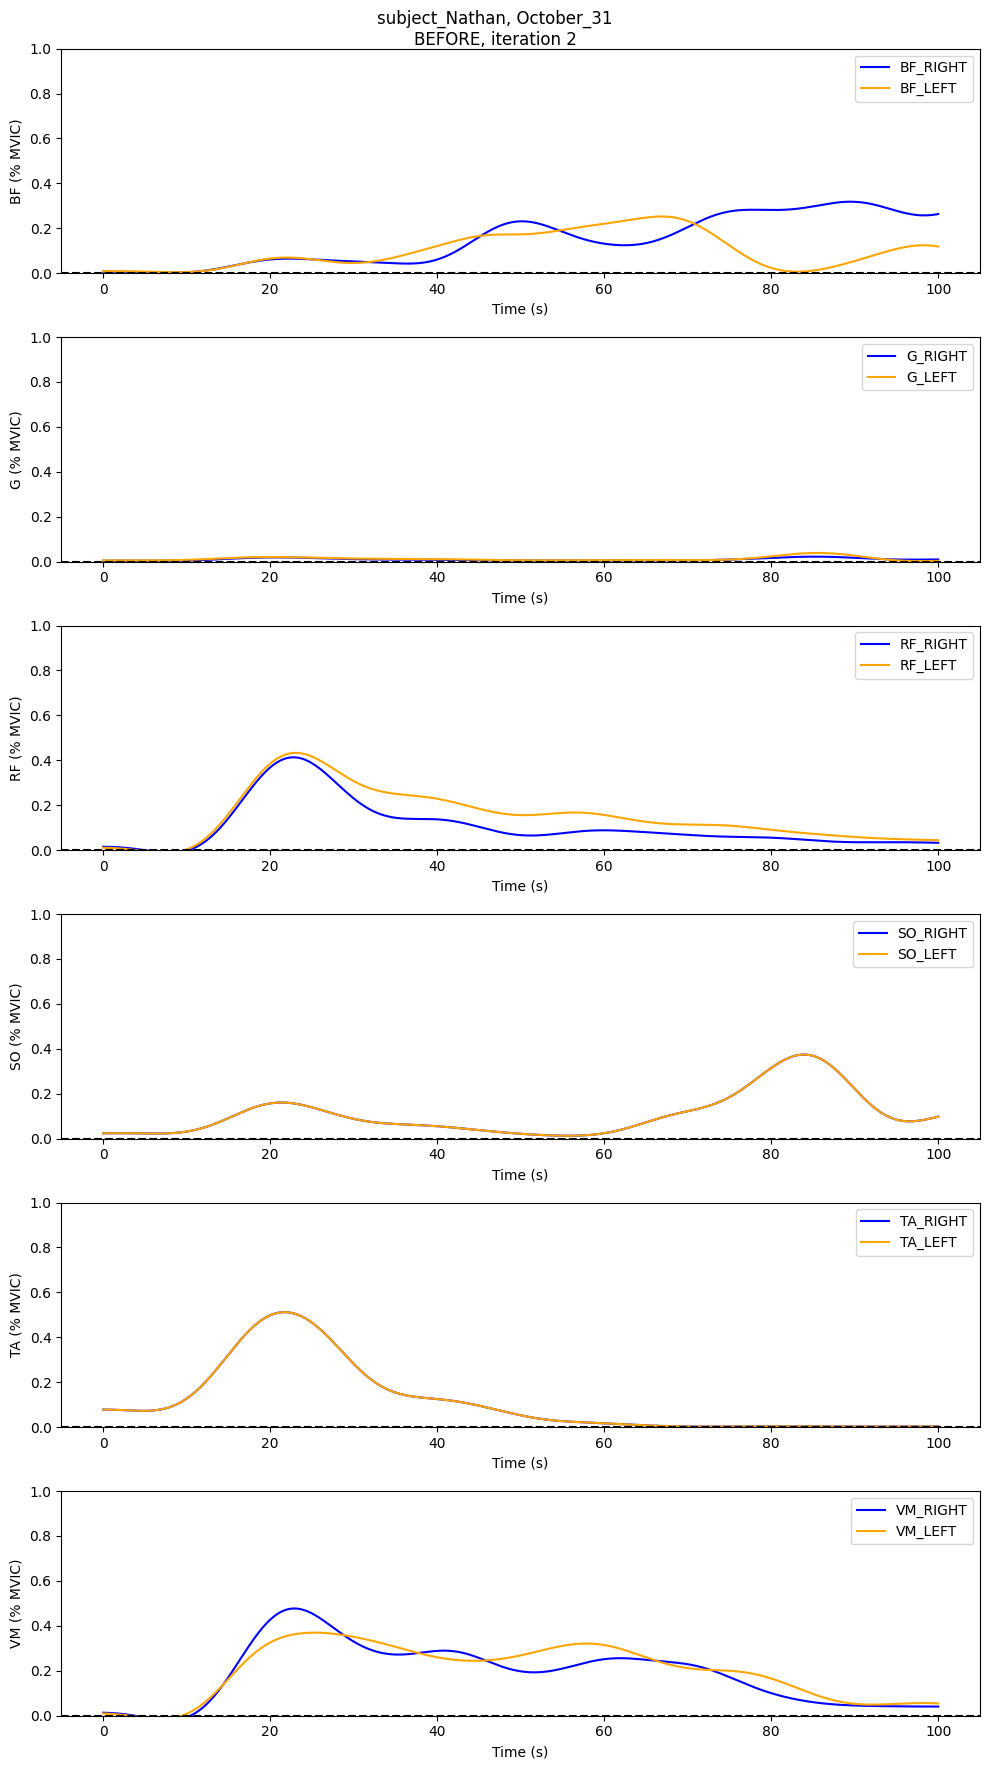

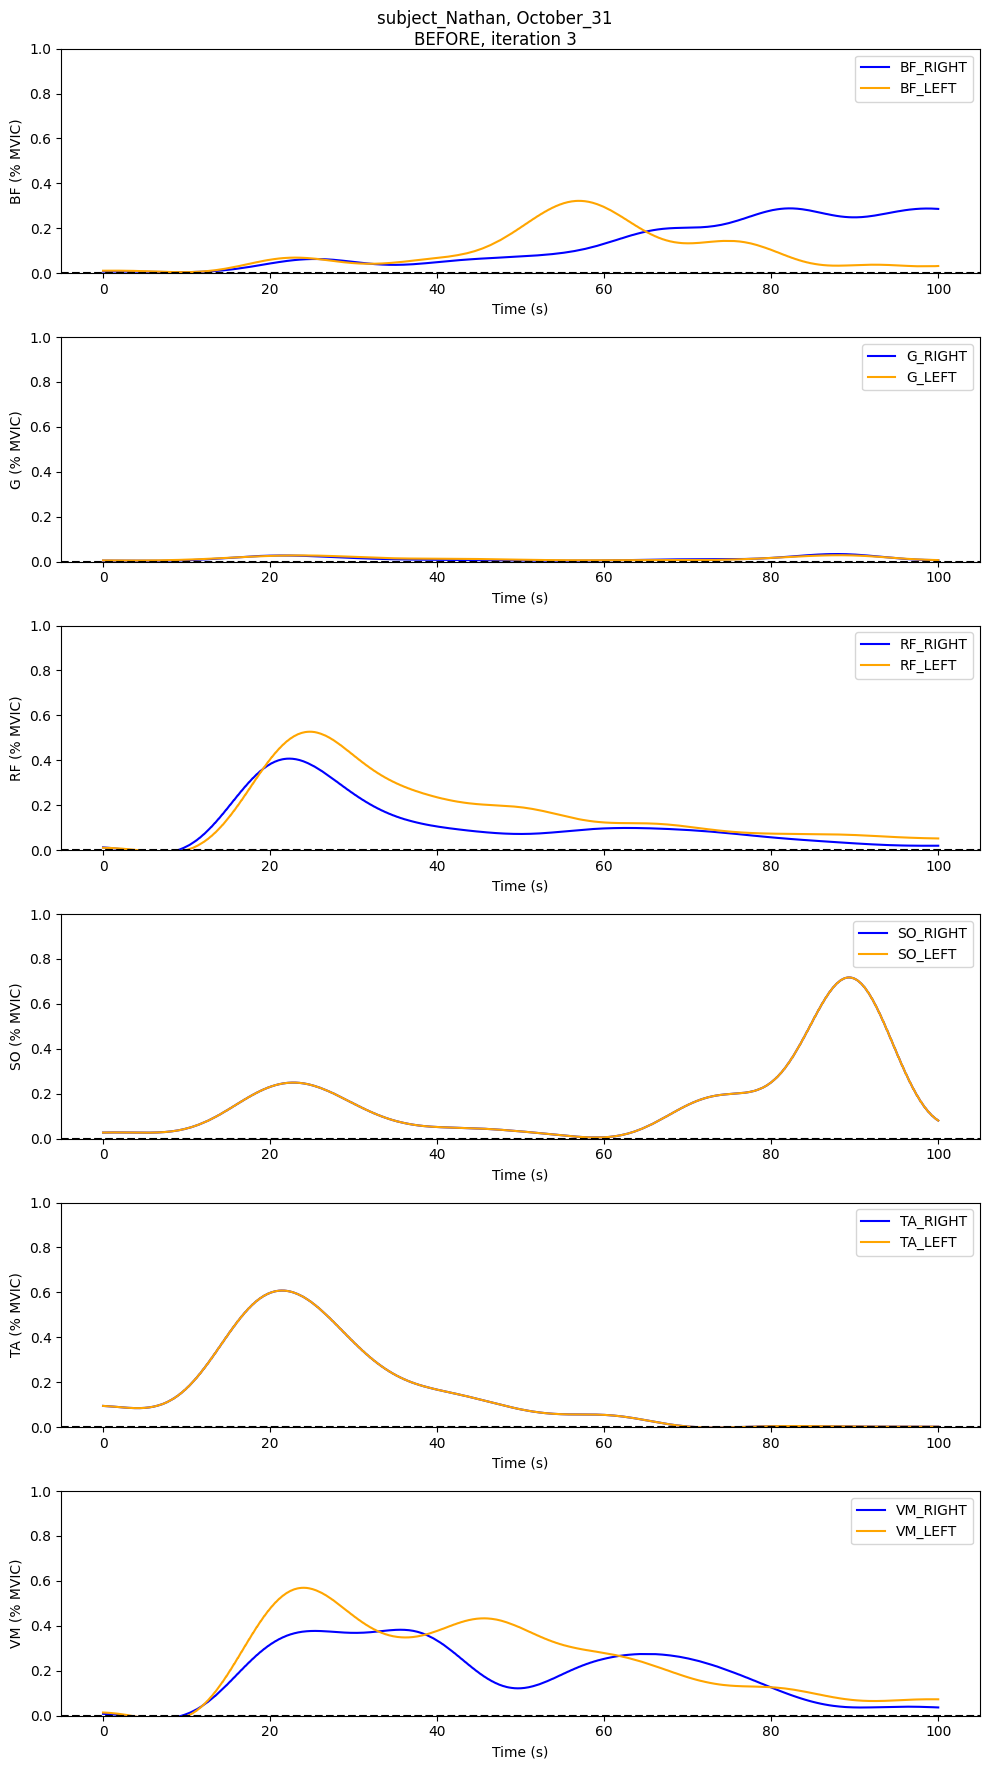

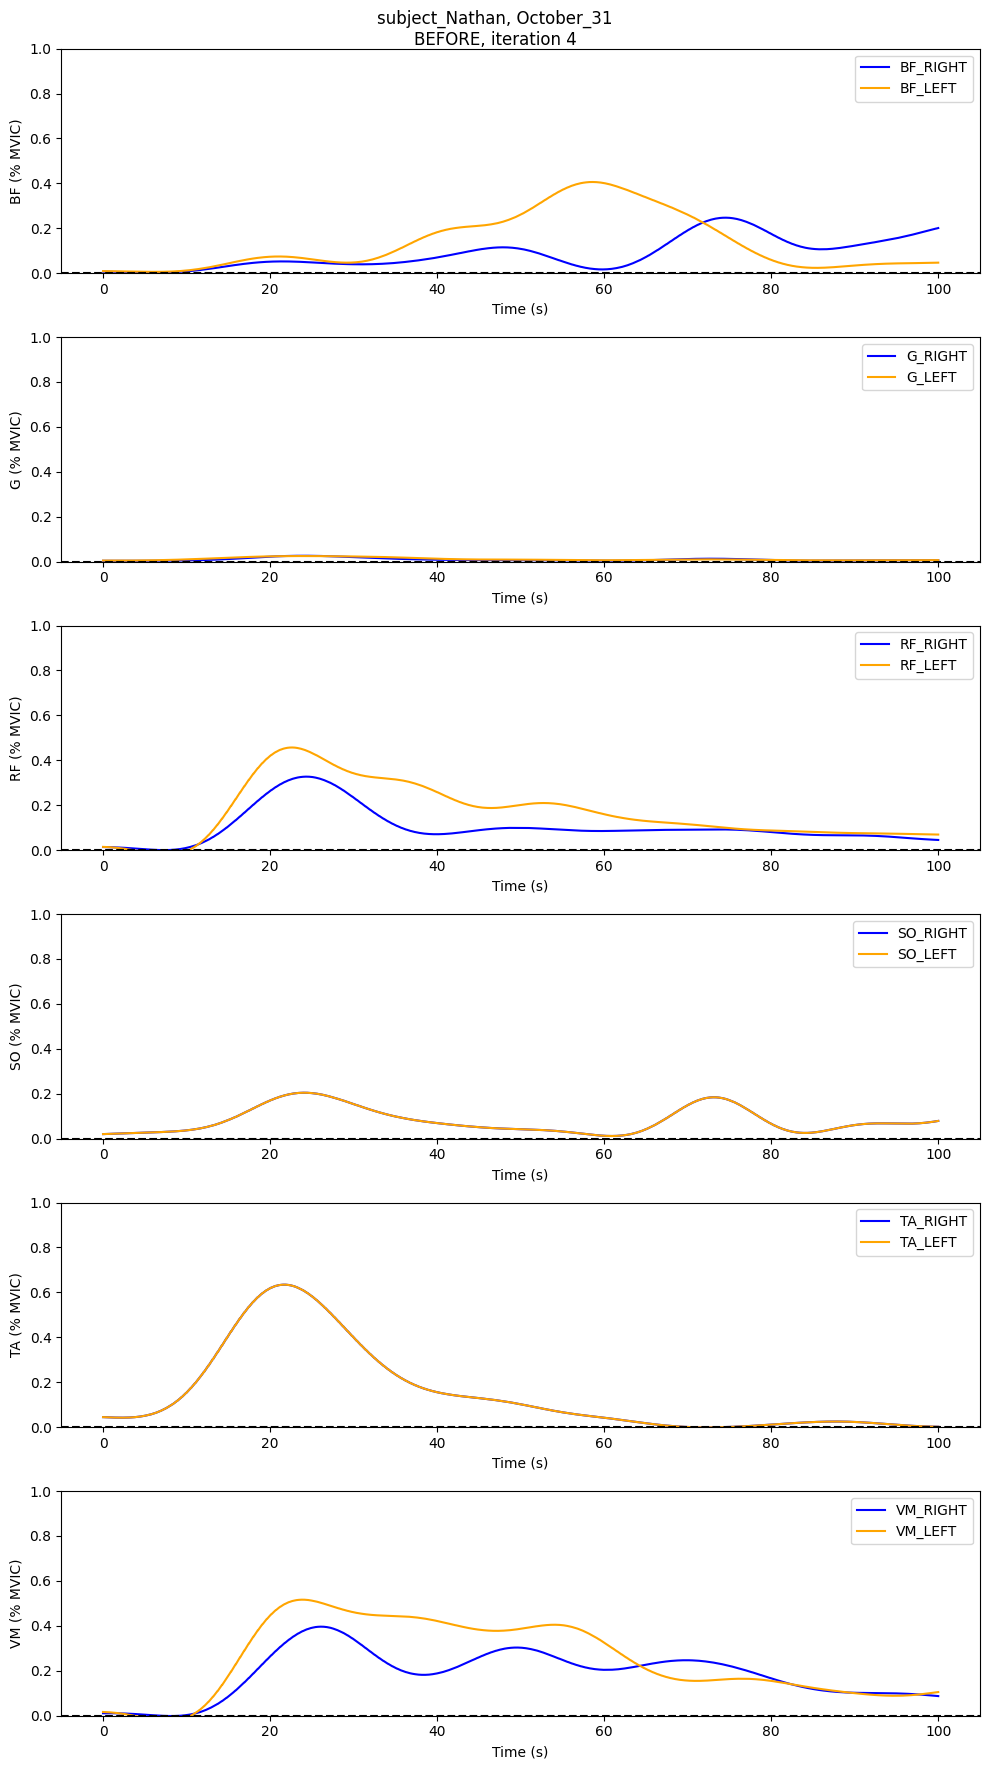

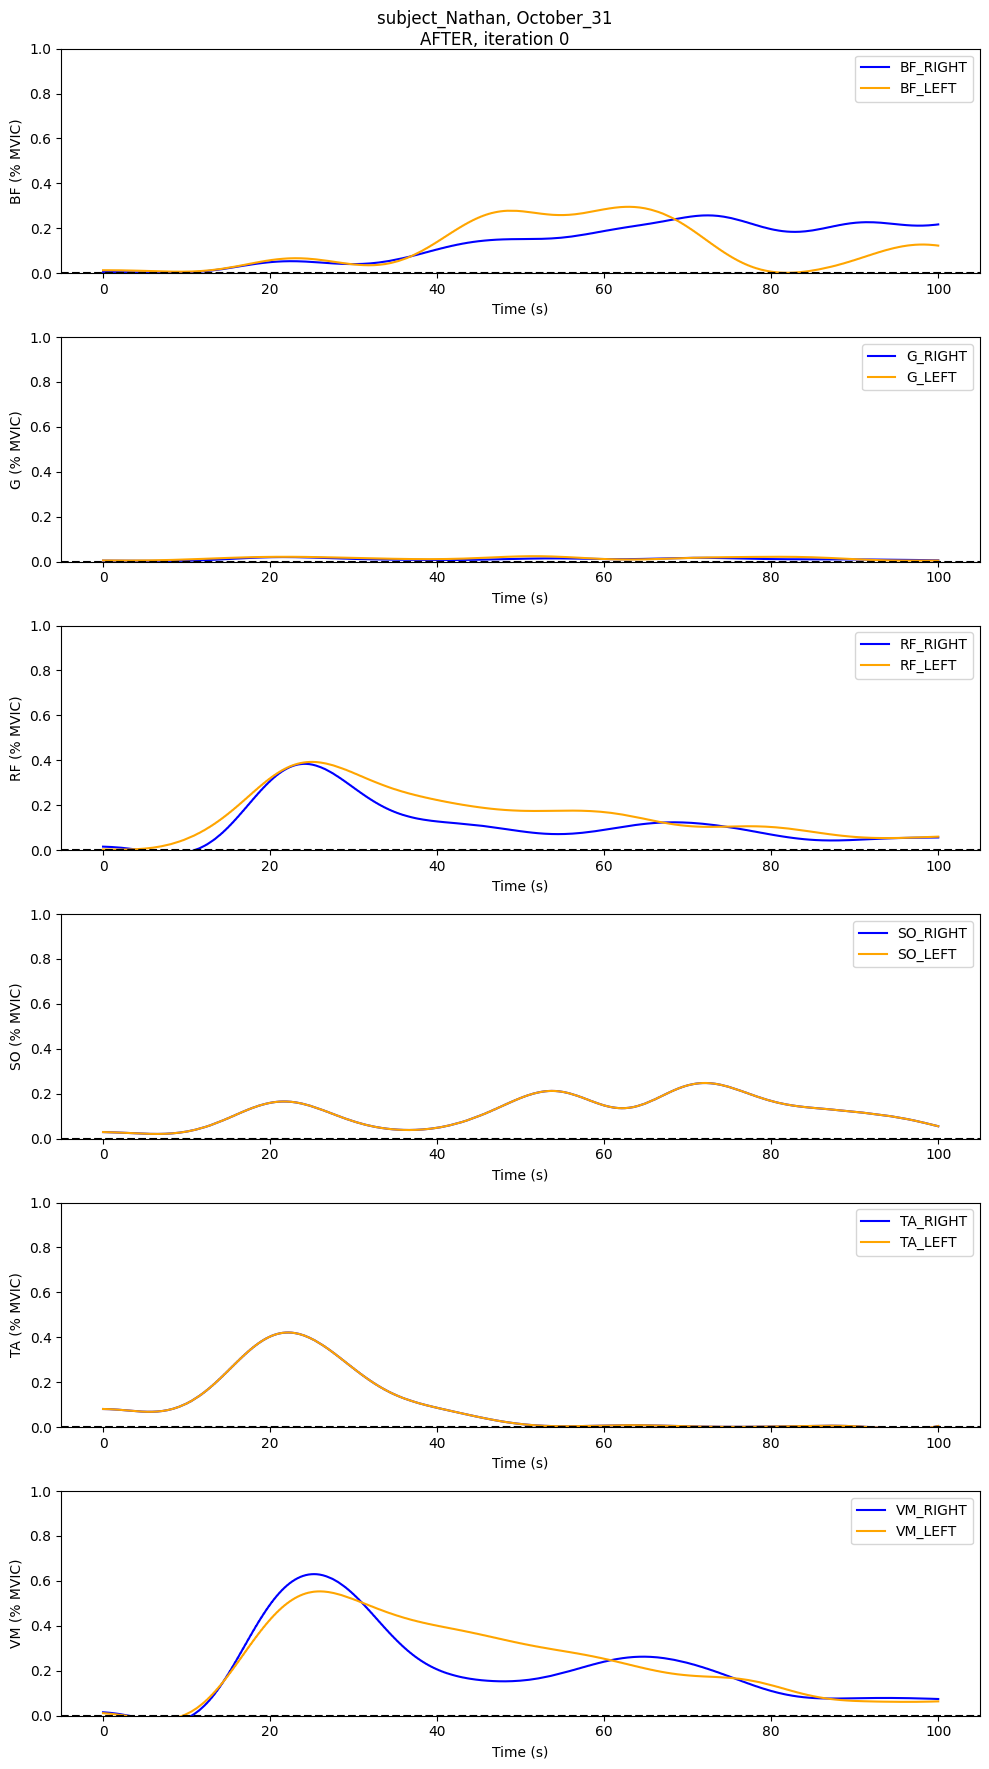

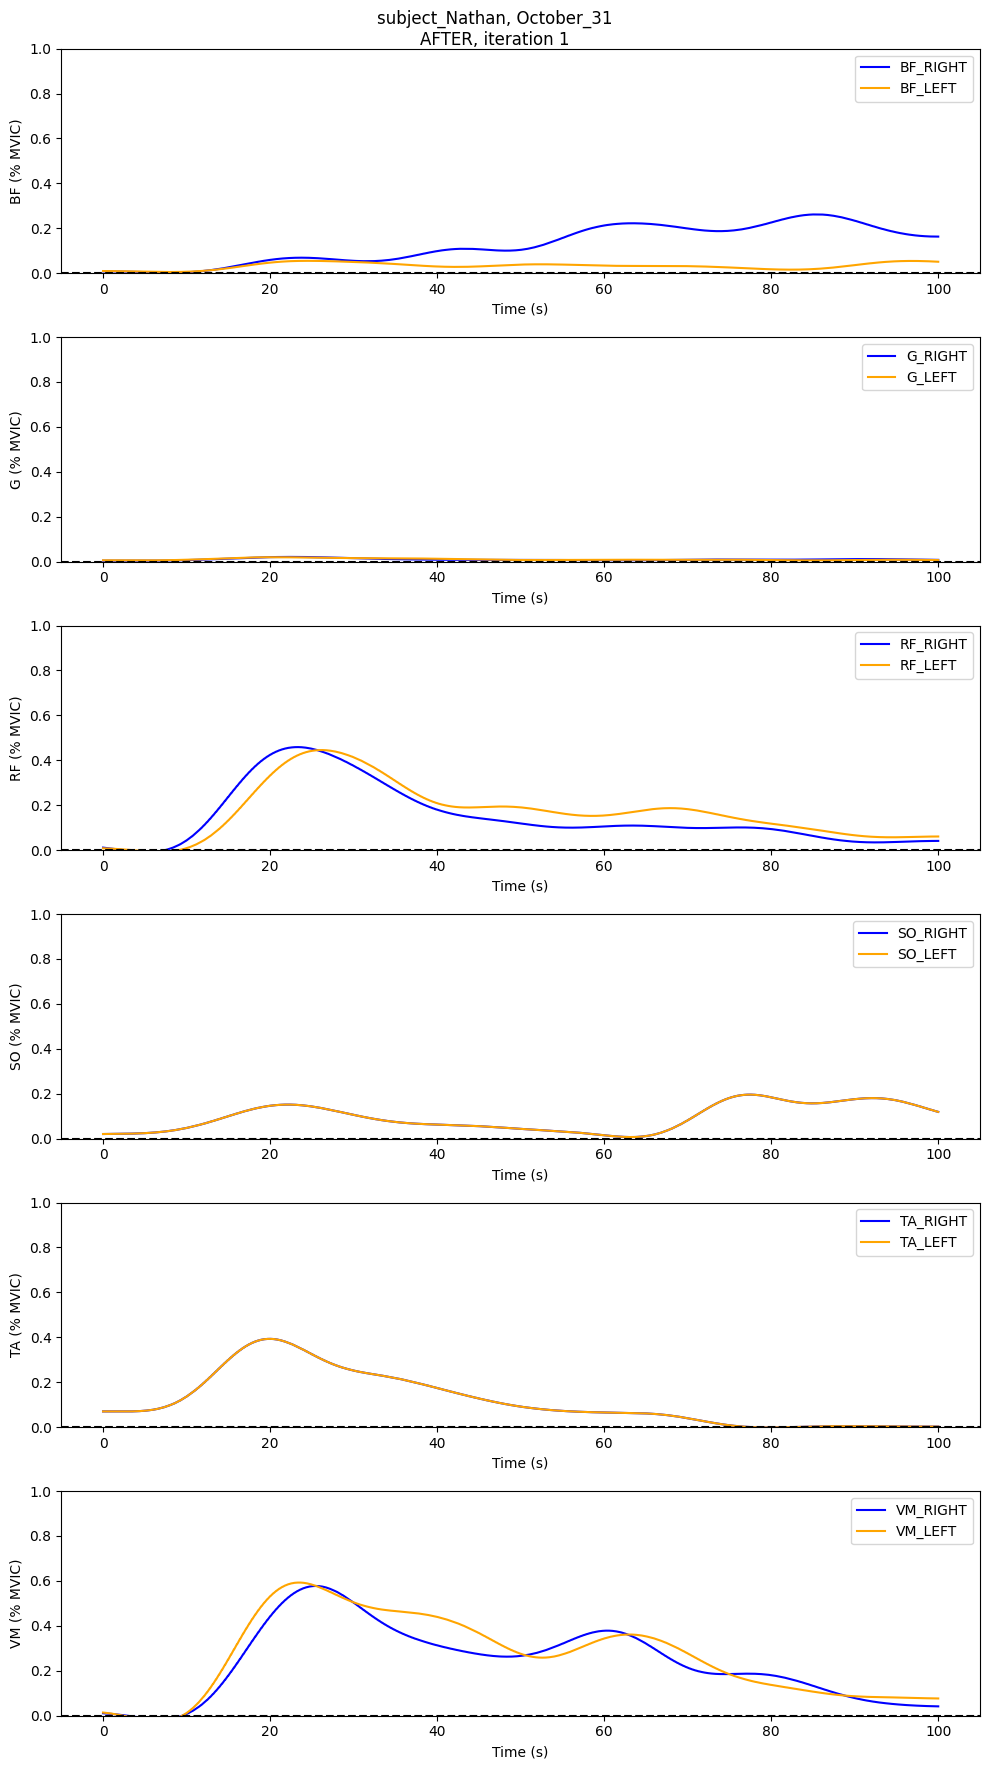

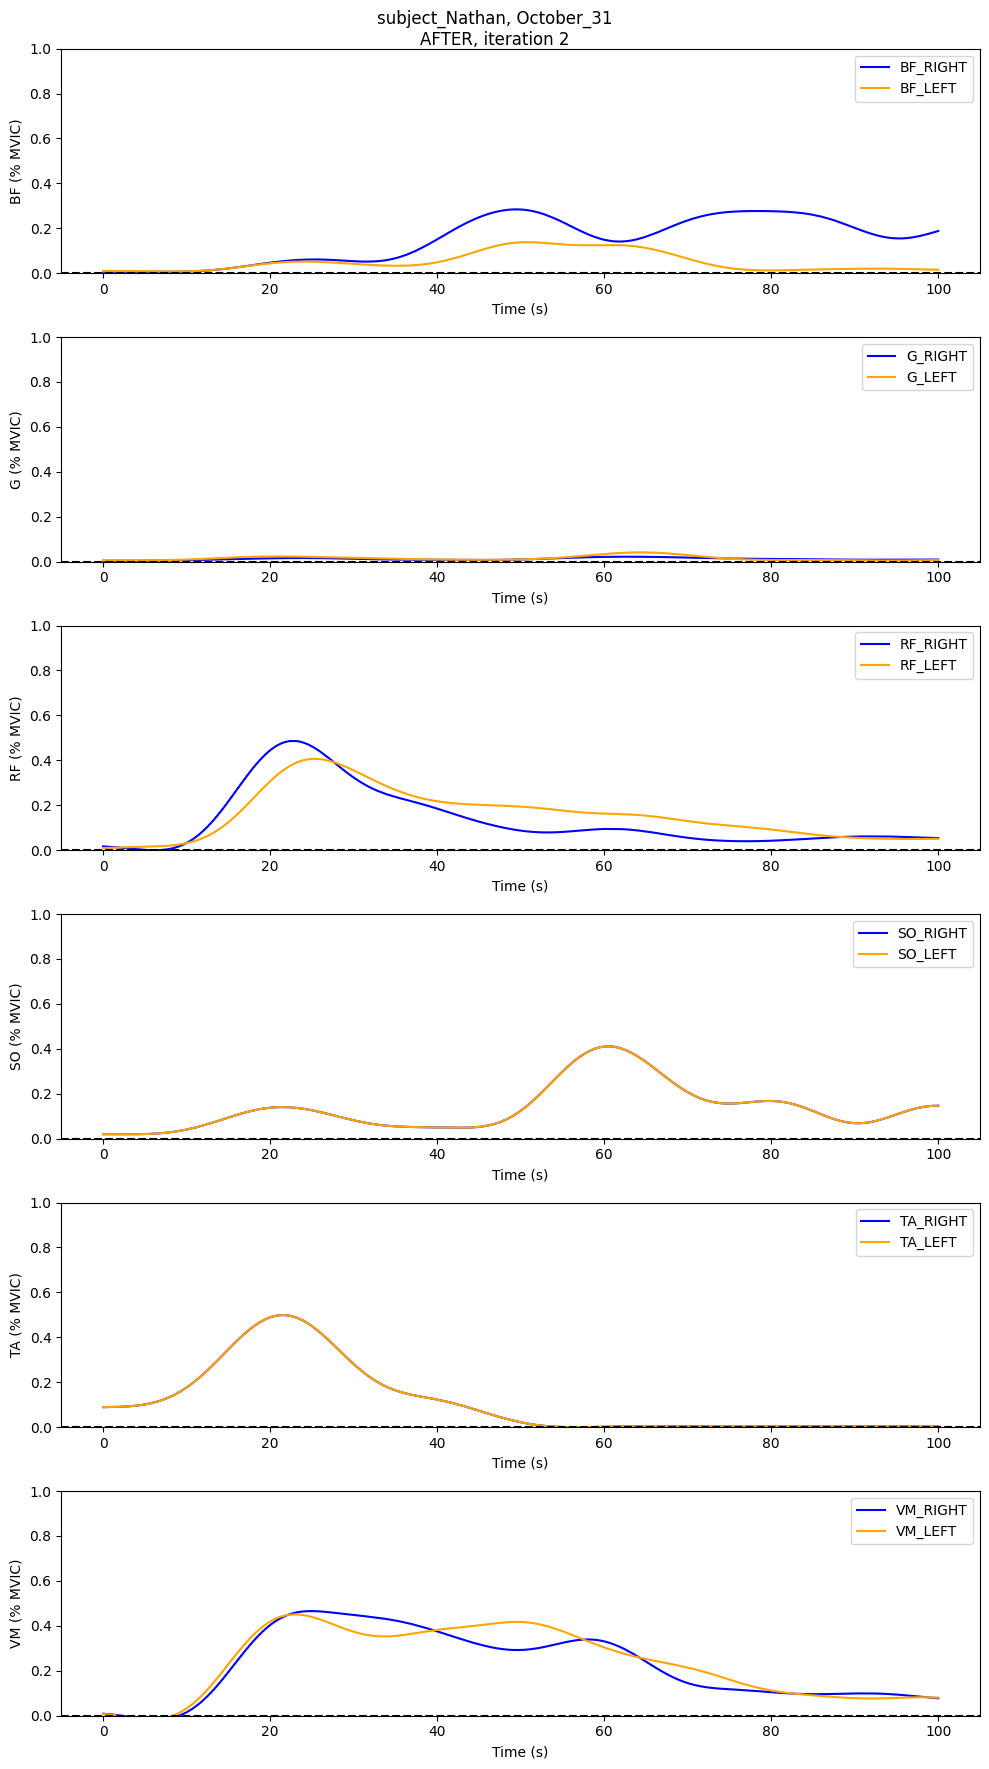

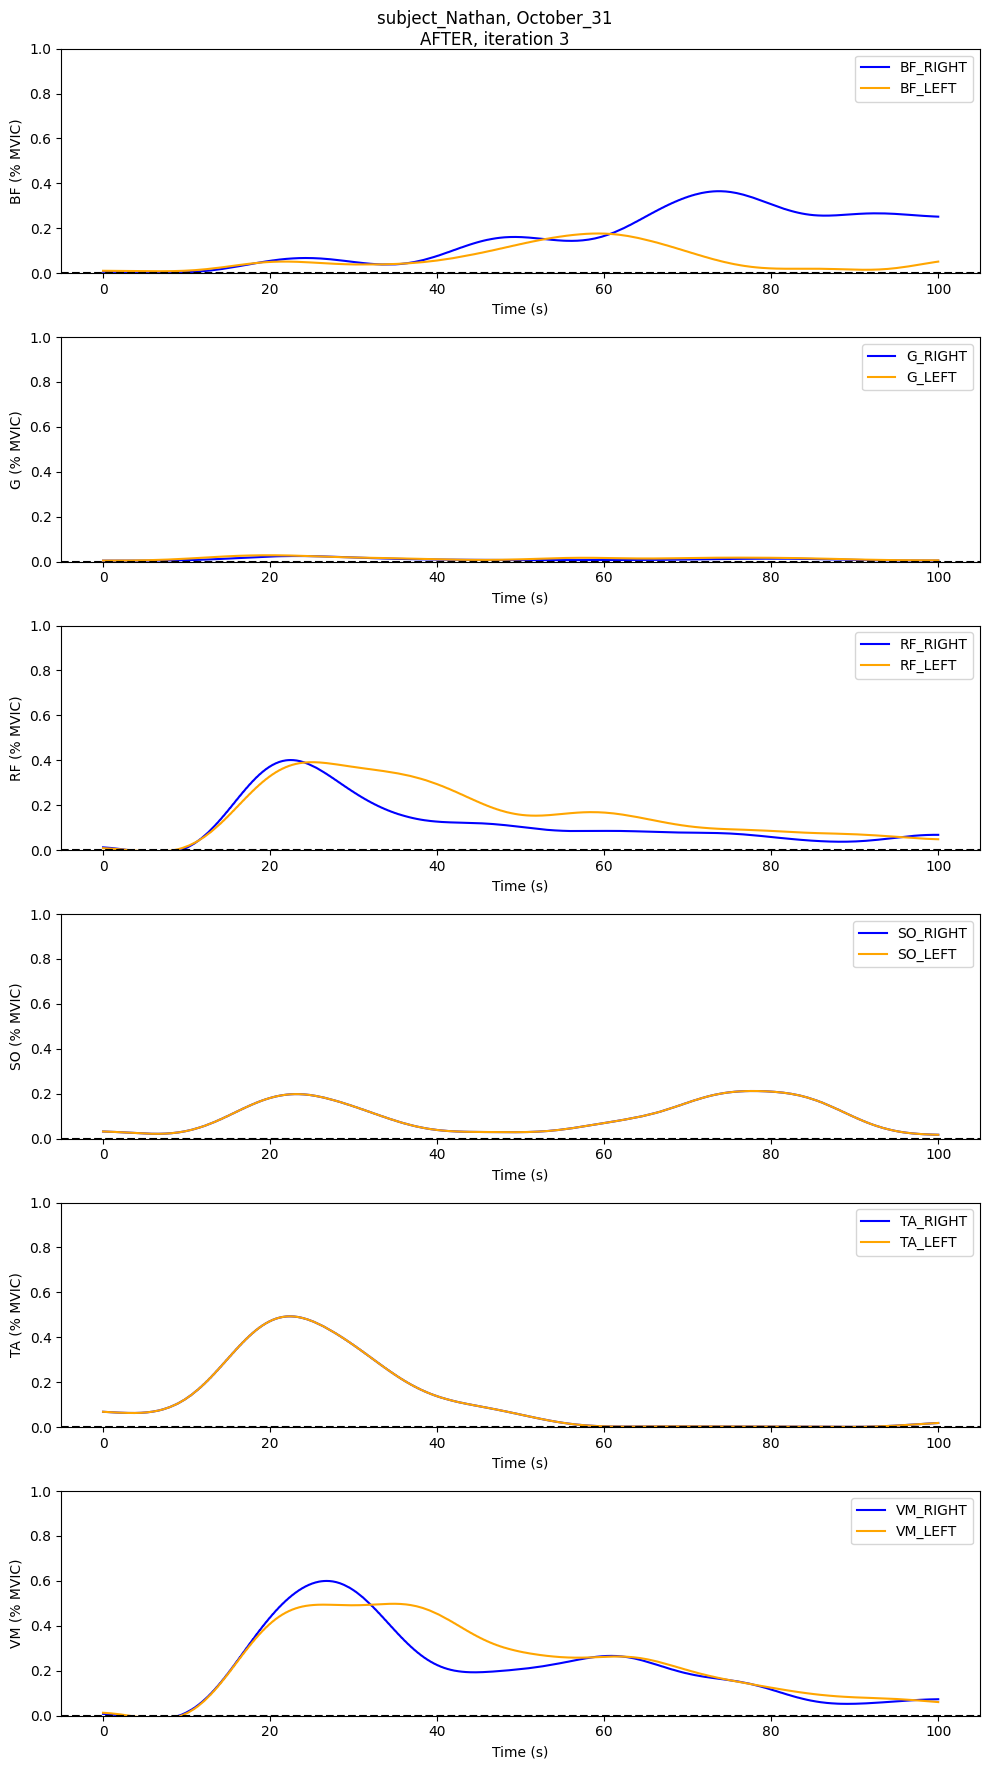

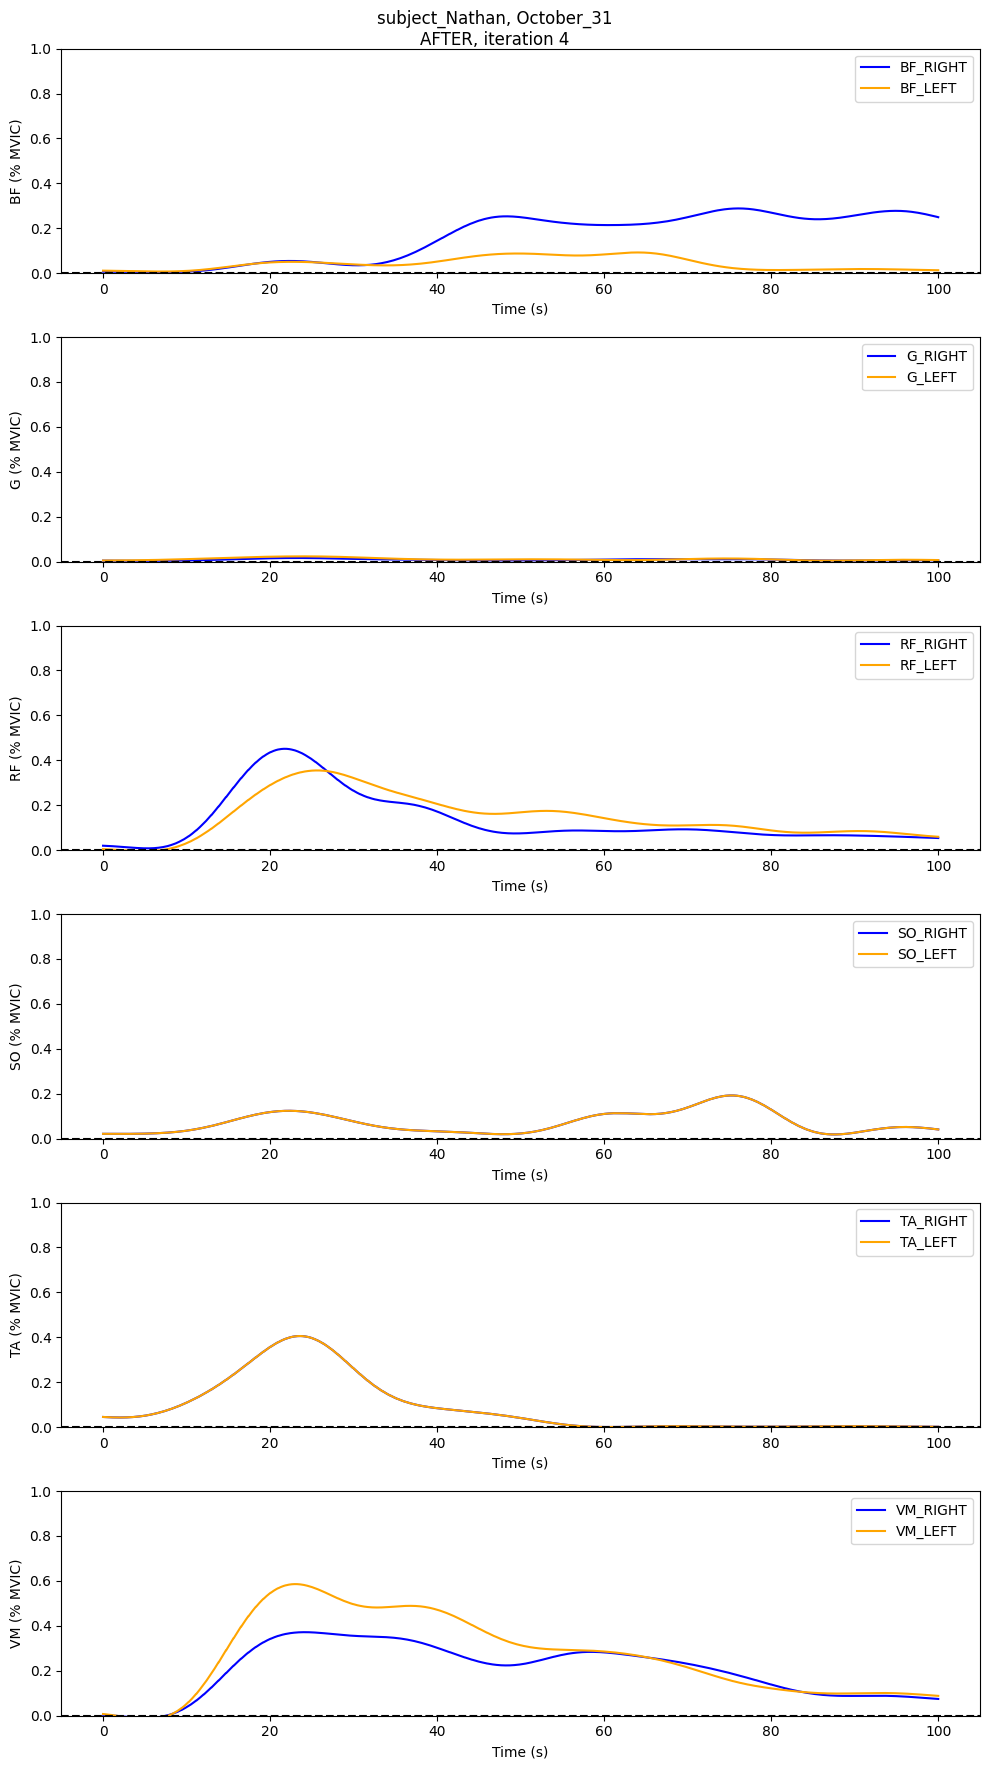

In [15]:
# Print all muslcles for each unpowered iteration
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        plot_dir = subject_dirs[subject][session]["plot_dir"] / "unpowered_vs_assisted"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            for iteration in range(len(trimmed_time_dfs["UNPOWERED"][unpowered_time]["EMG"])):
                emg_unpowered = trimmed_time_dfs["UNPOWERED"][unpowered_time]["EMG"][iteration]
                filename = plot_dir / f"unpowered_{unpowered_time}_iteration_{iteration}"

                muscles = emg_unpowered.columns
                # Remove IMU and TIME
                muscles = muscles.drop(["TIME", "IMU"])
                # Remove all _LEFT muscles
                muscles = muscles[~muscles.str.contains("_LEFT")]

                # Plot the difference in muscle activation for each muscle with subplots
                fig, axs = plt.subplots(len(muscles), figsize=(10, 3 * len(muscles)))
                fig.suptitle(f"{subject}, {session}\n{unpowered_time}, iteration {iteration}")

                for i, muscle in enumerate(muscles):
                    # Muscle without _SIDE
                    m = muscle.split("_")[0]
                    
                    # Plot EMG differences
                    axs[i].plot(emg_unpowered.index, emg_unpowered[f"{m}_RIGHT"], label=f"{m}_RIGHT", color='blue')
                    axs[i].plot(emg_unpowered.index, emg_unpowered[f"{m}_LEFT"], label=f"{m}_LEFT", color='orange')
                    
                    # Primary y-axis settings
                    axs[i].set_ylabel(f"{m} (% MVIC)")
                    axs[i].set_xlabel("Time (s)")
                    axs[i].set_ylim(0, 1)
                    axs[i].axhline(0, color='black', linestyle='--')
                    
                    # Combine legends
                    lines1, labels1 = axs[i].get_legend_handles_labels()
                    axs[i].legend(lines1, labels1, loc='upper right')

                plt.tight_layout()
                plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
                plt.show()


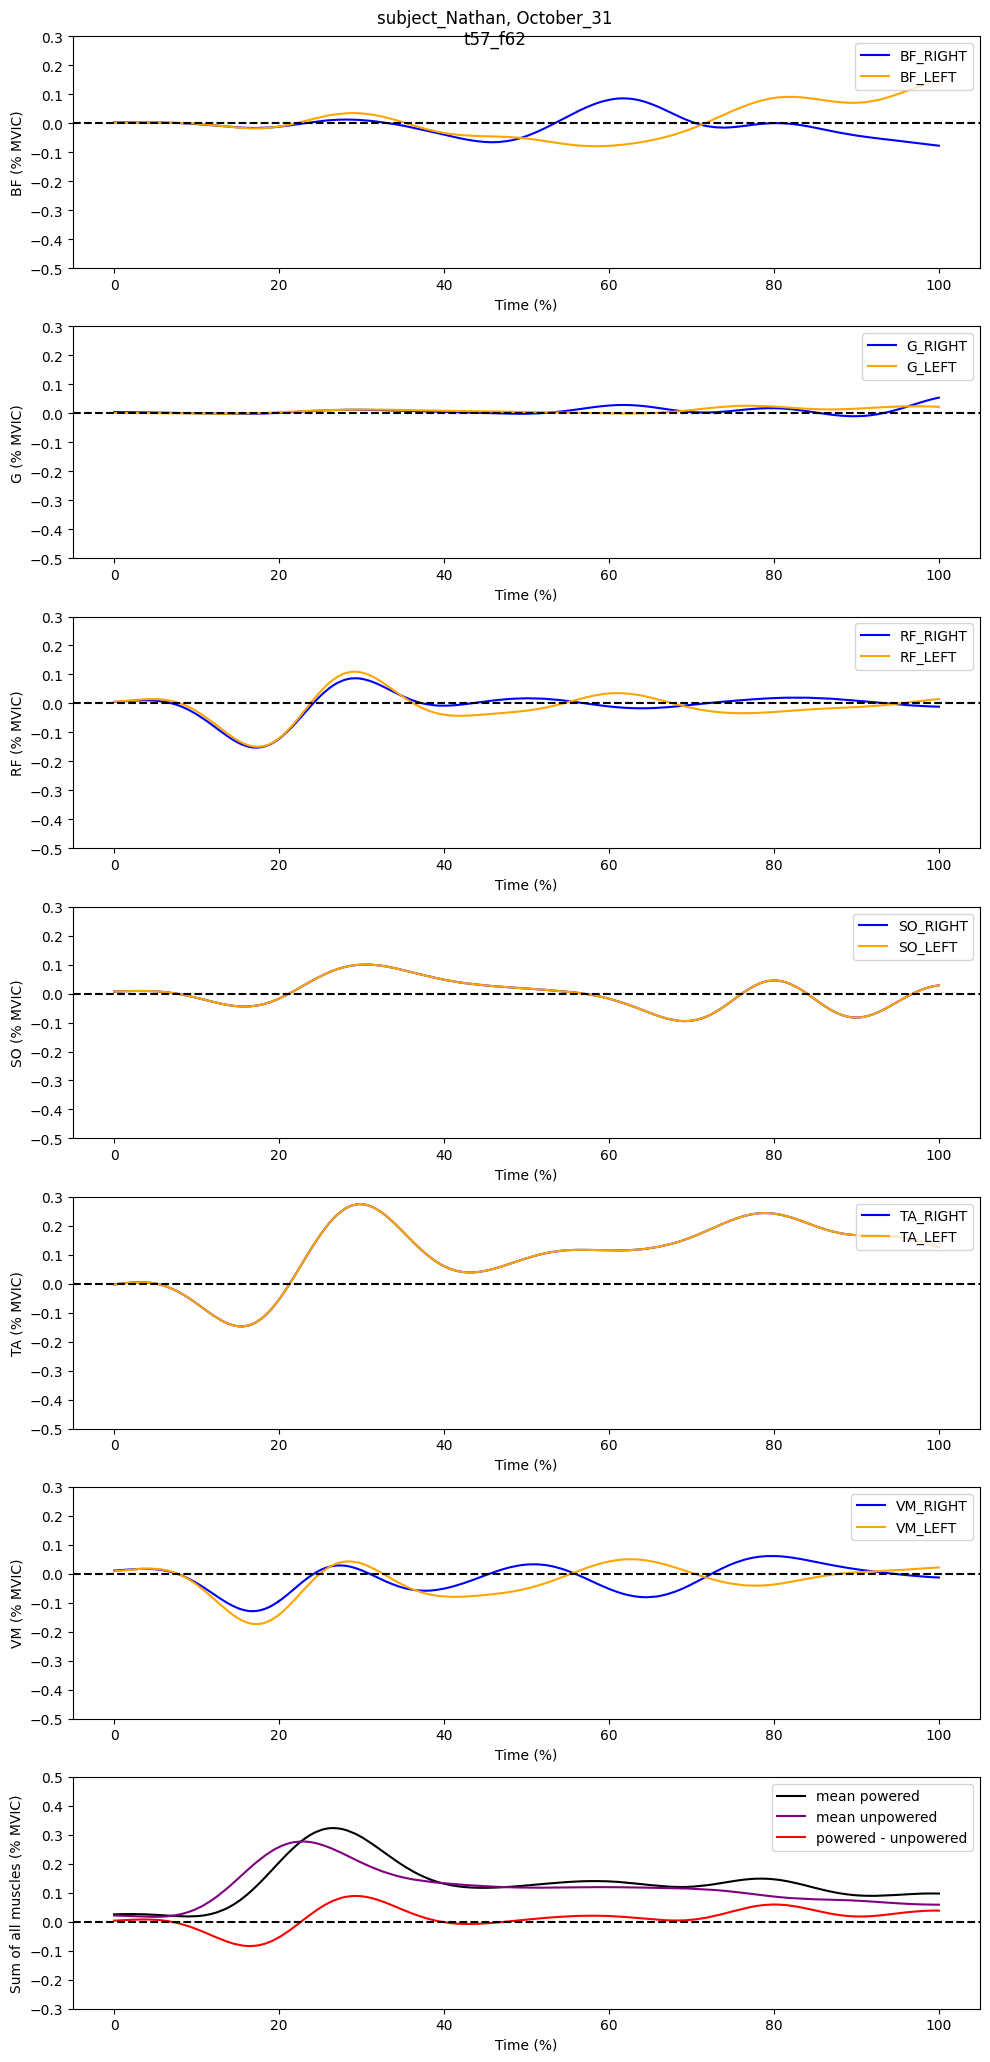

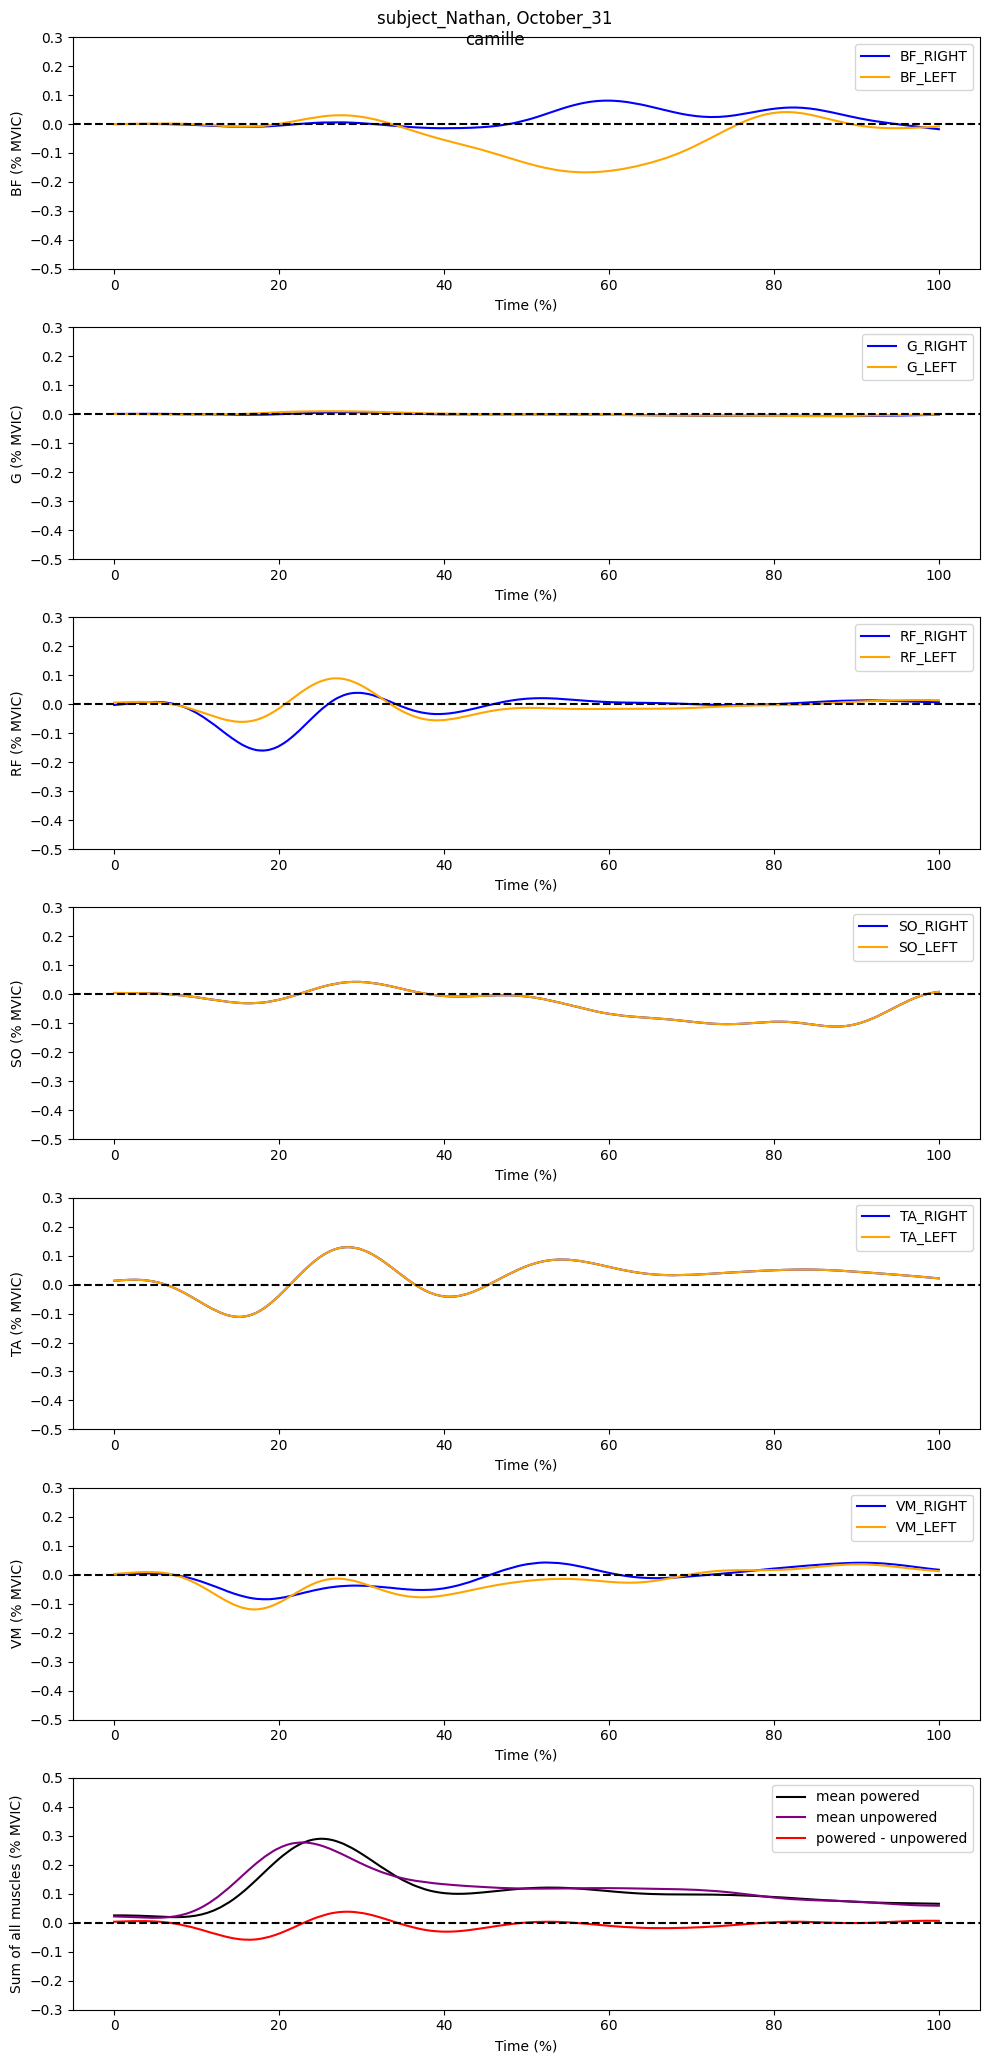

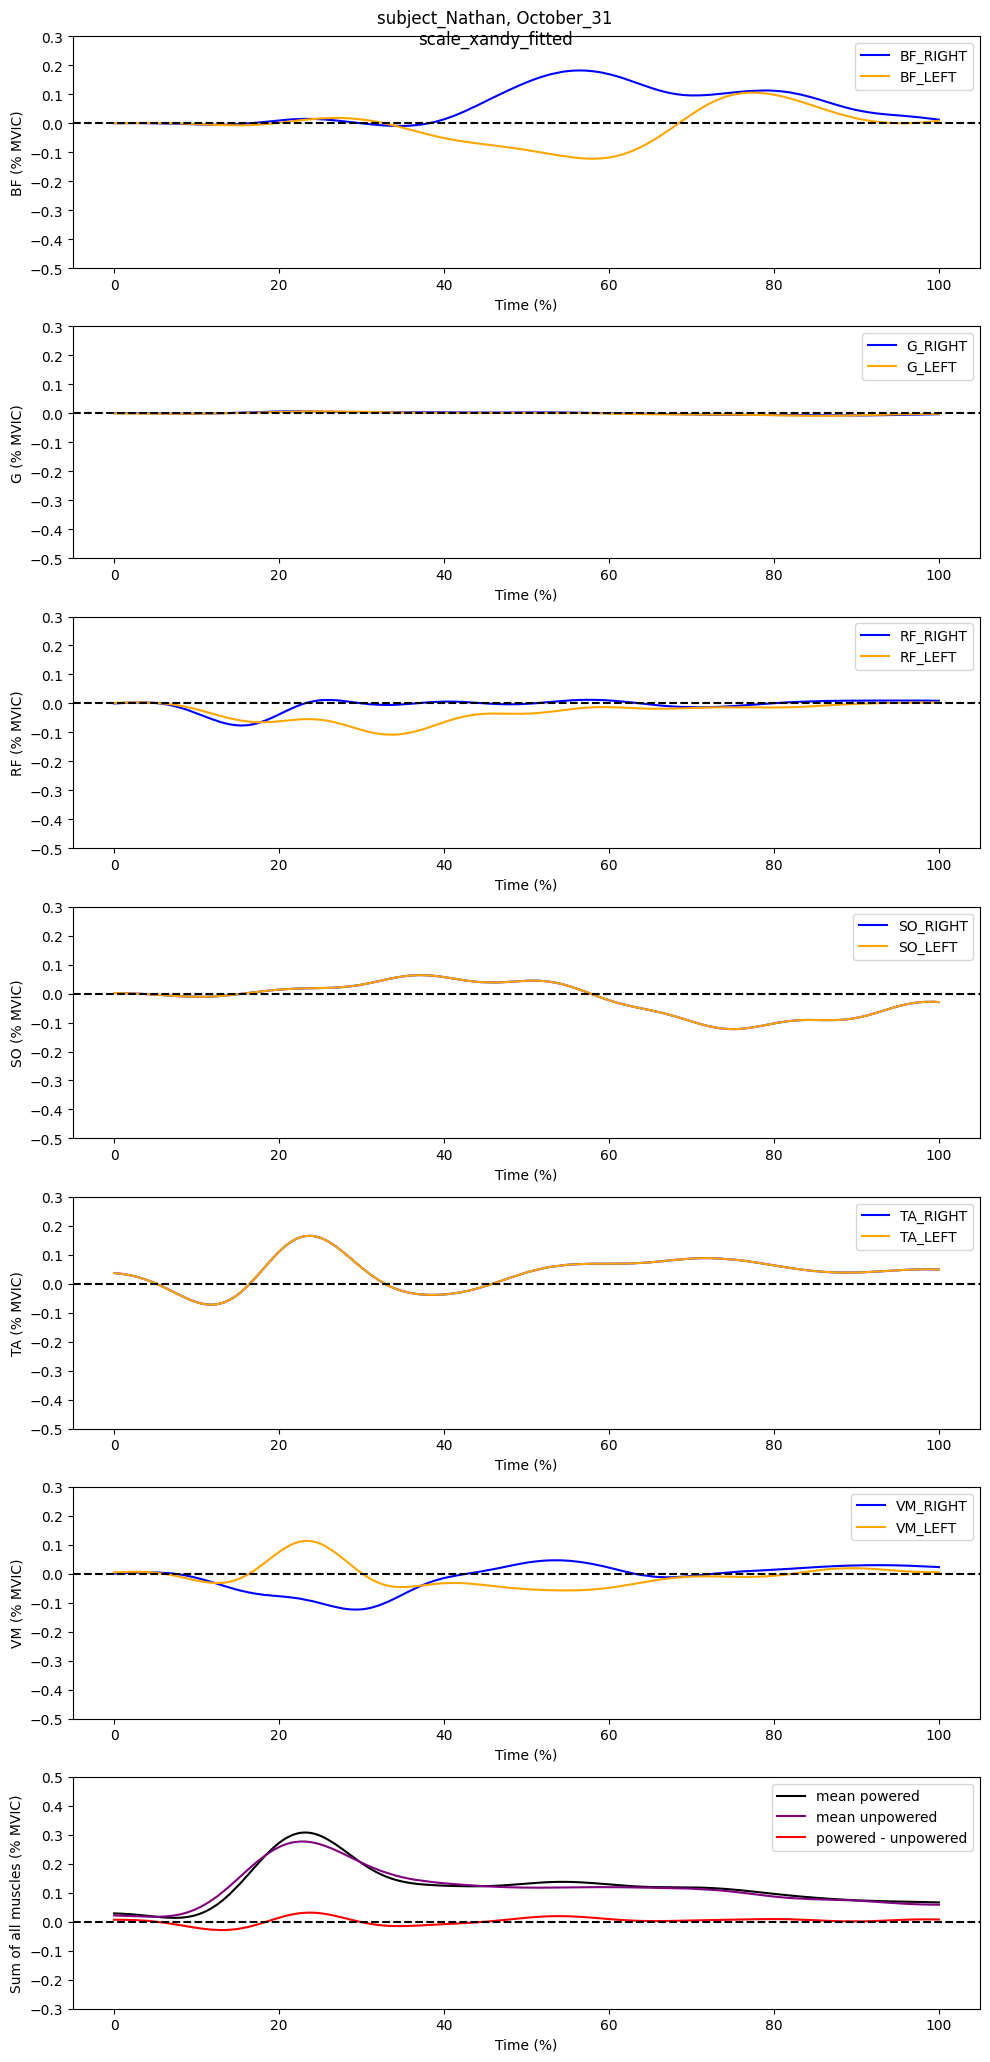

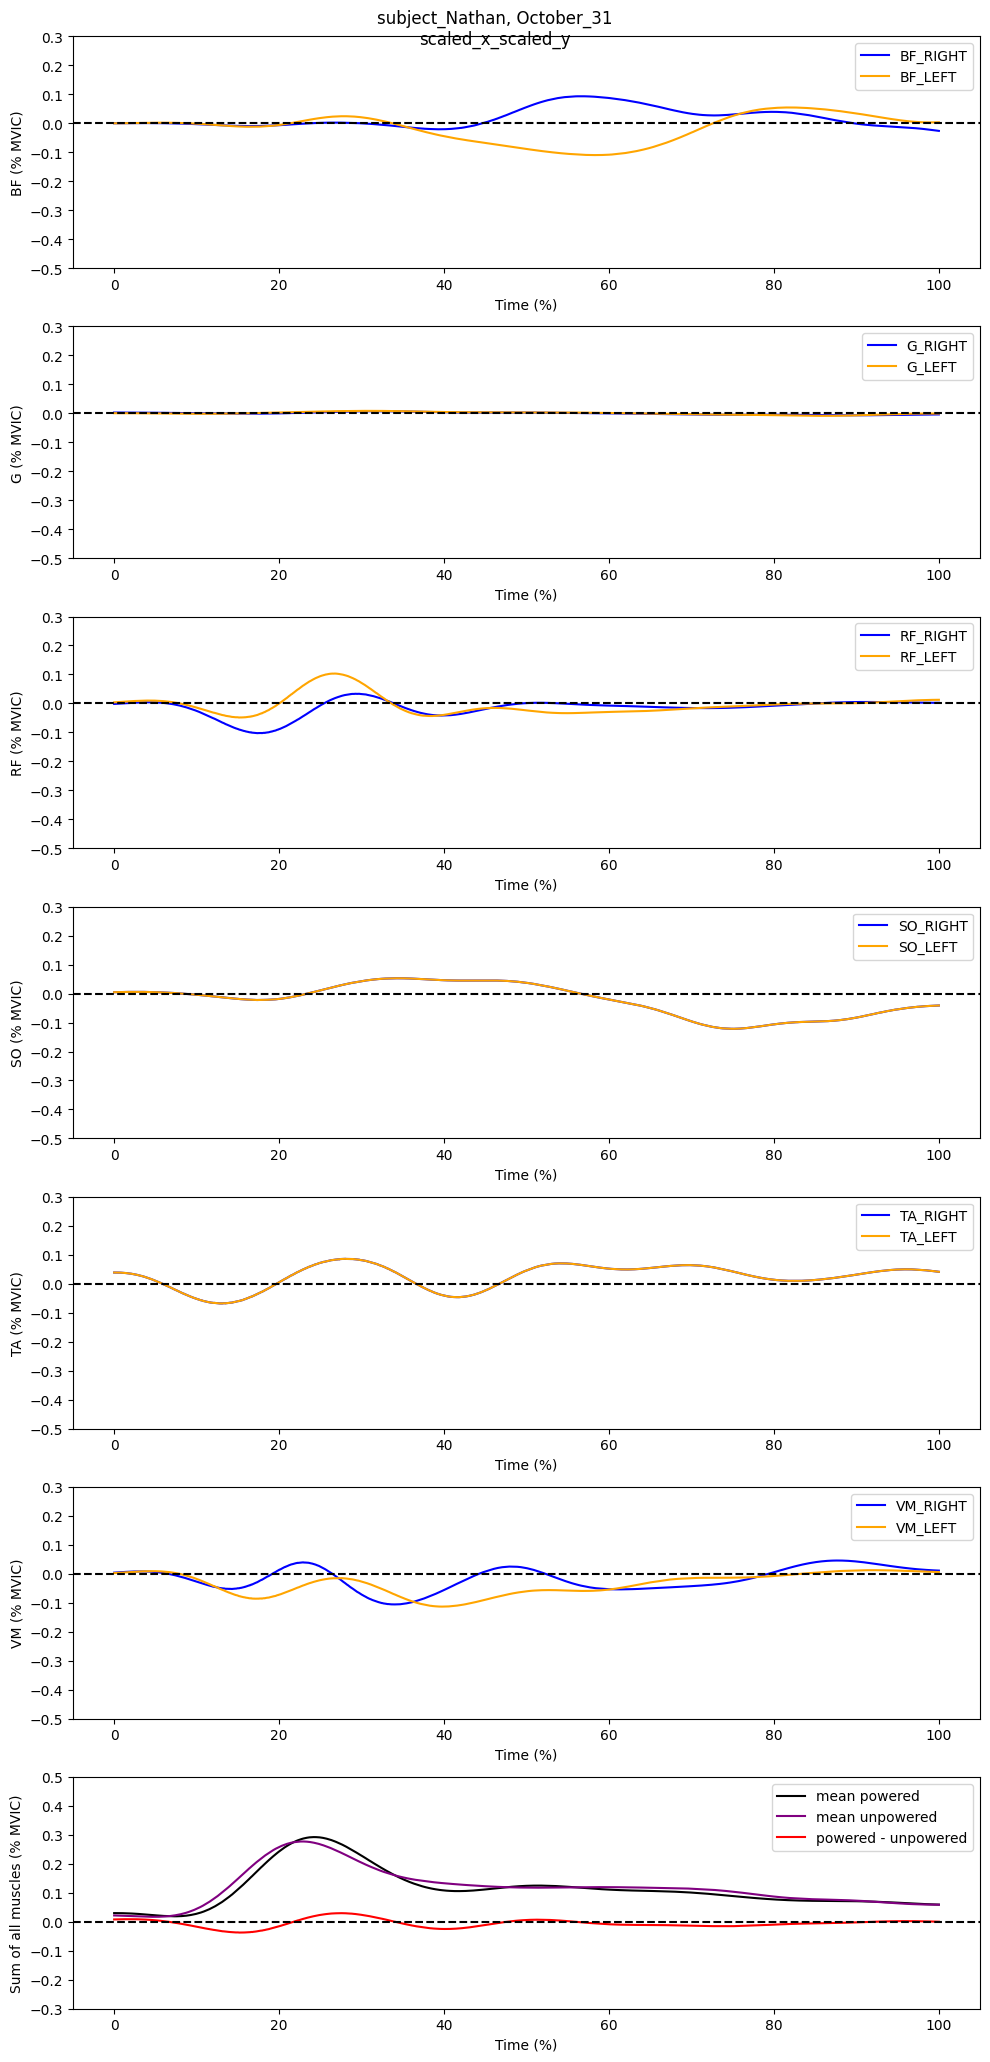

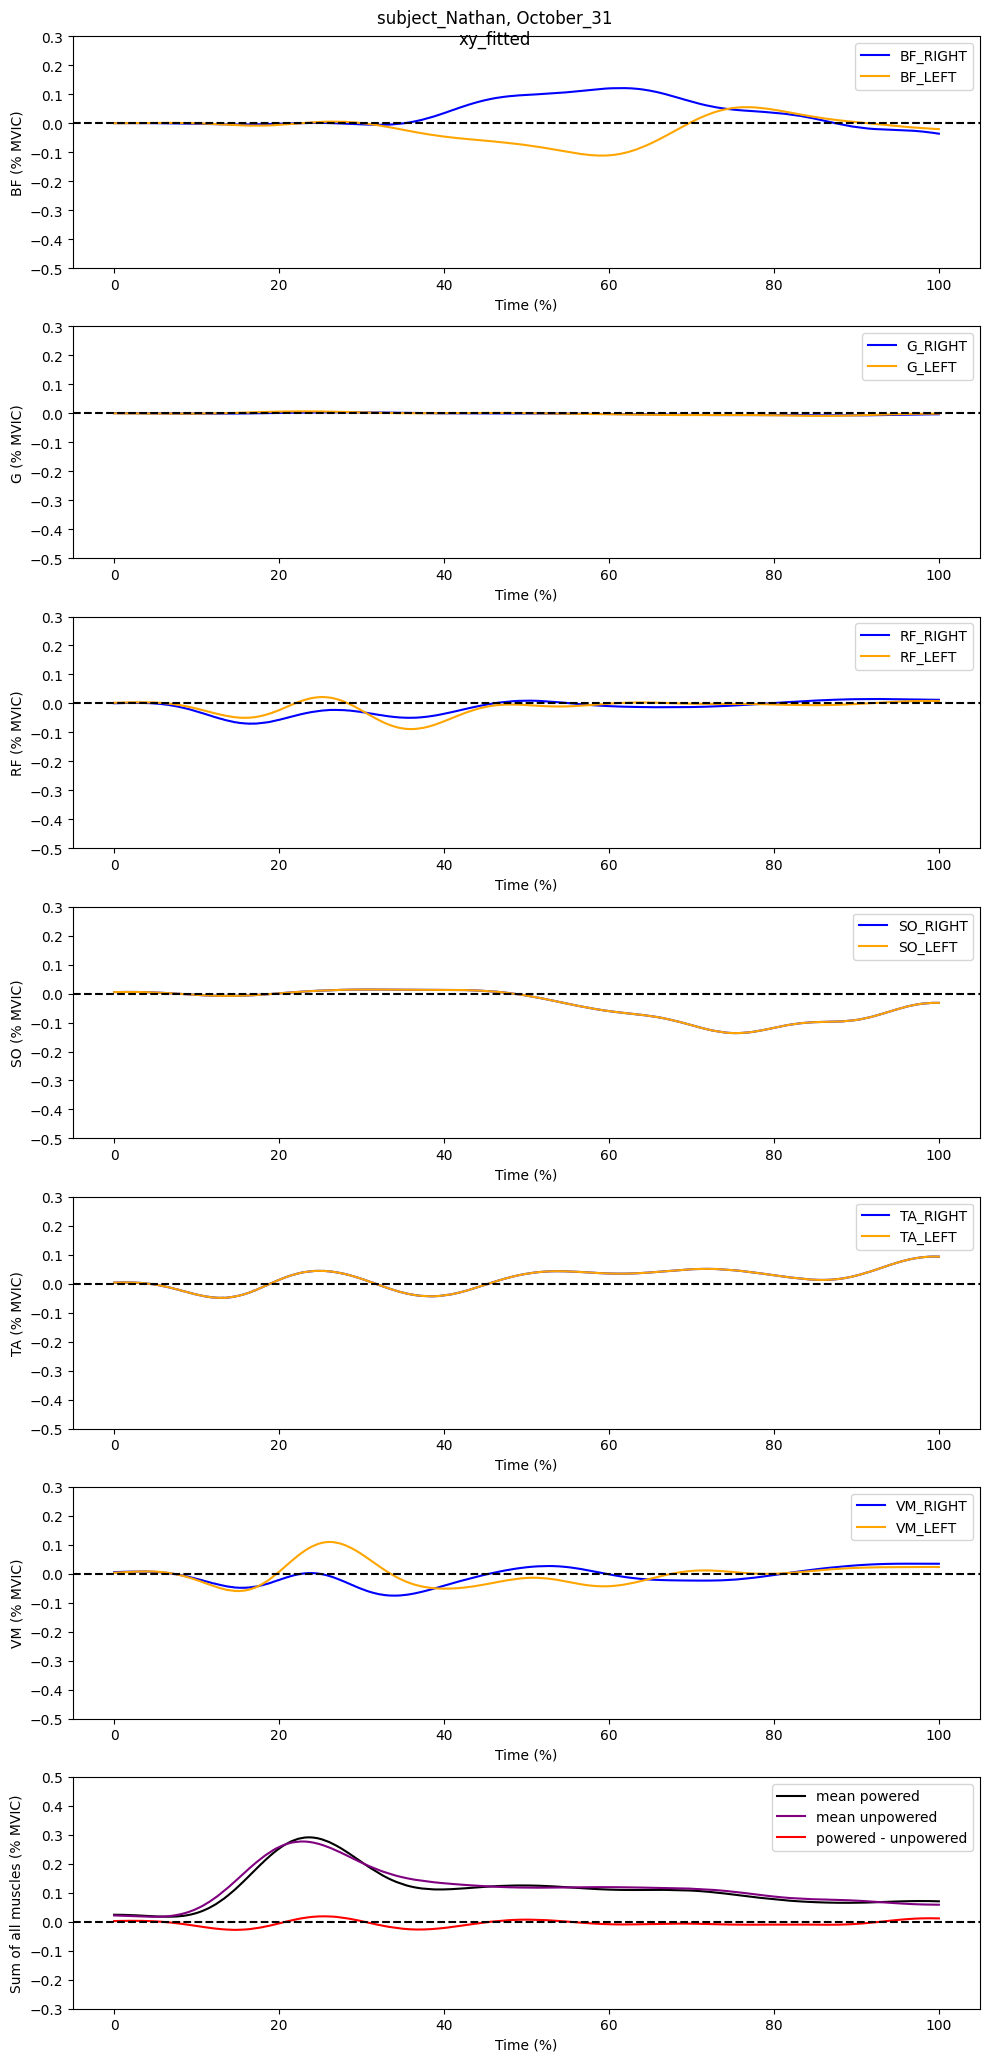

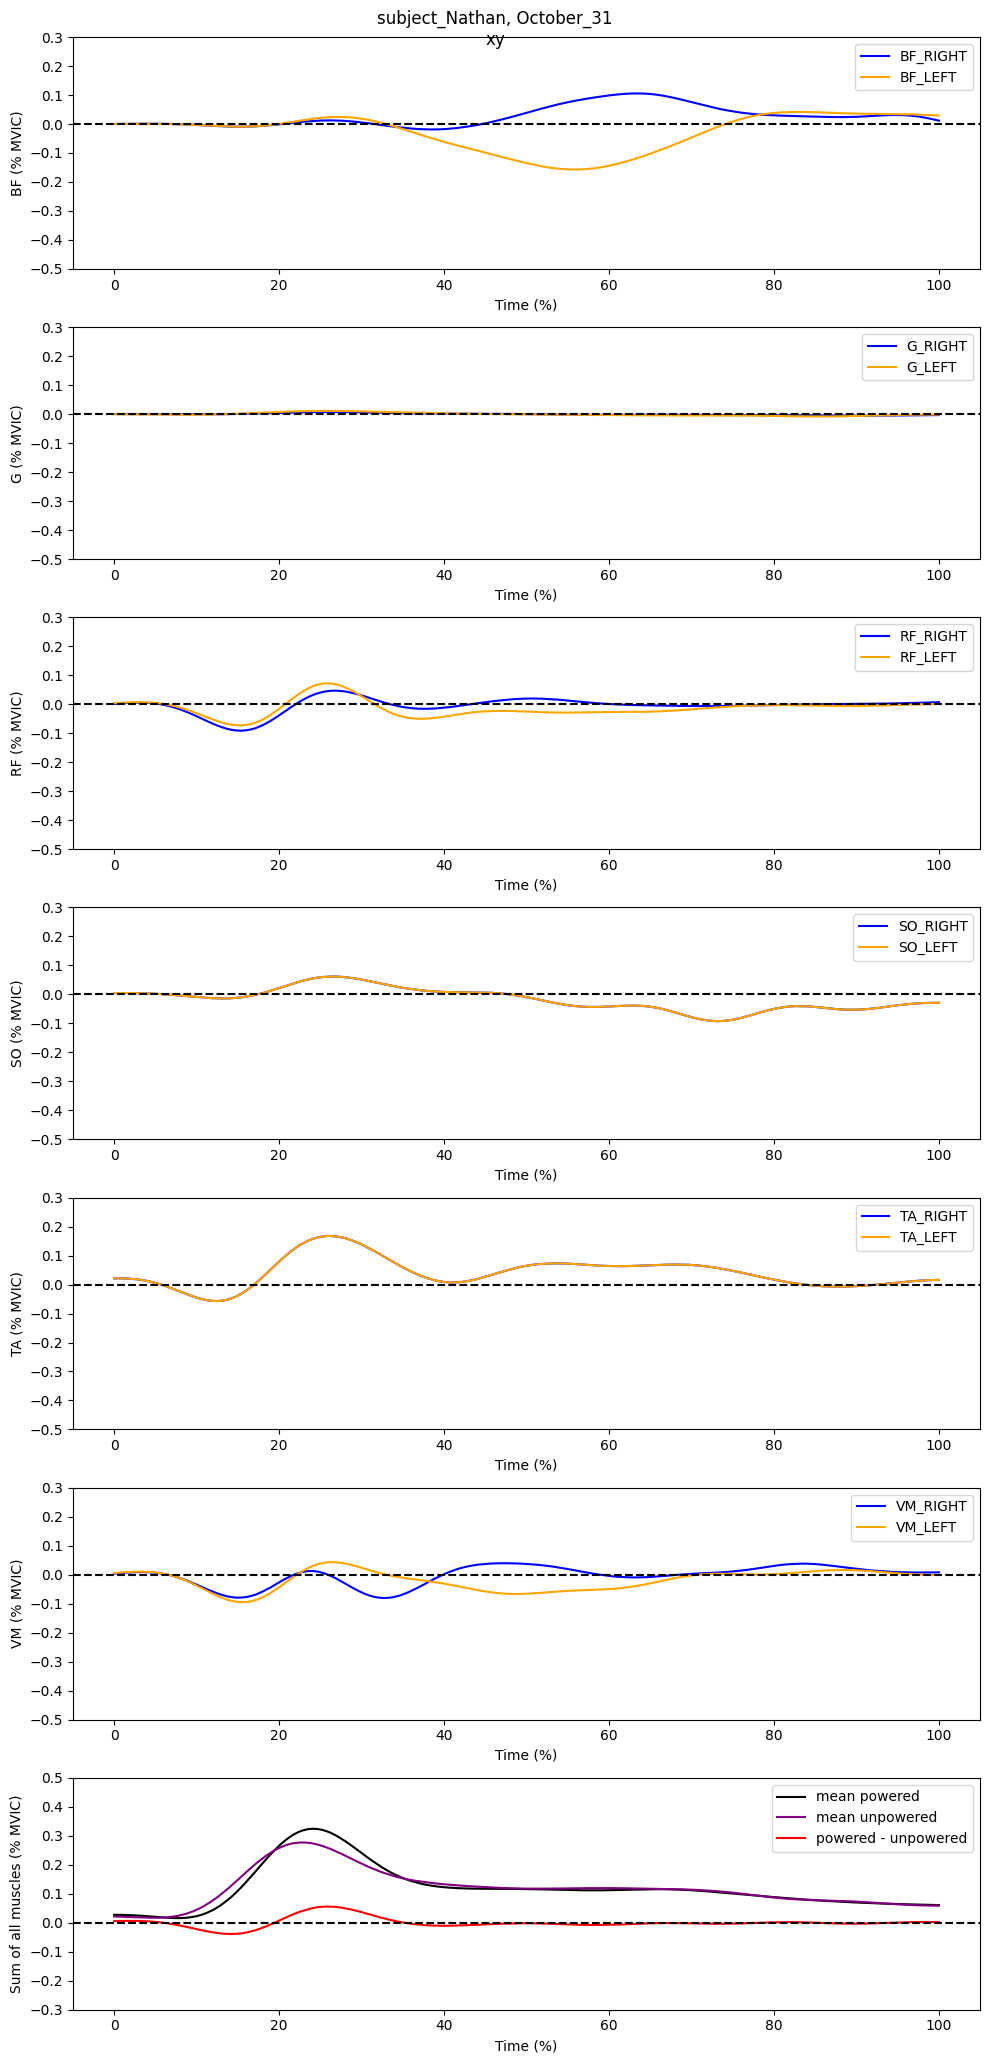

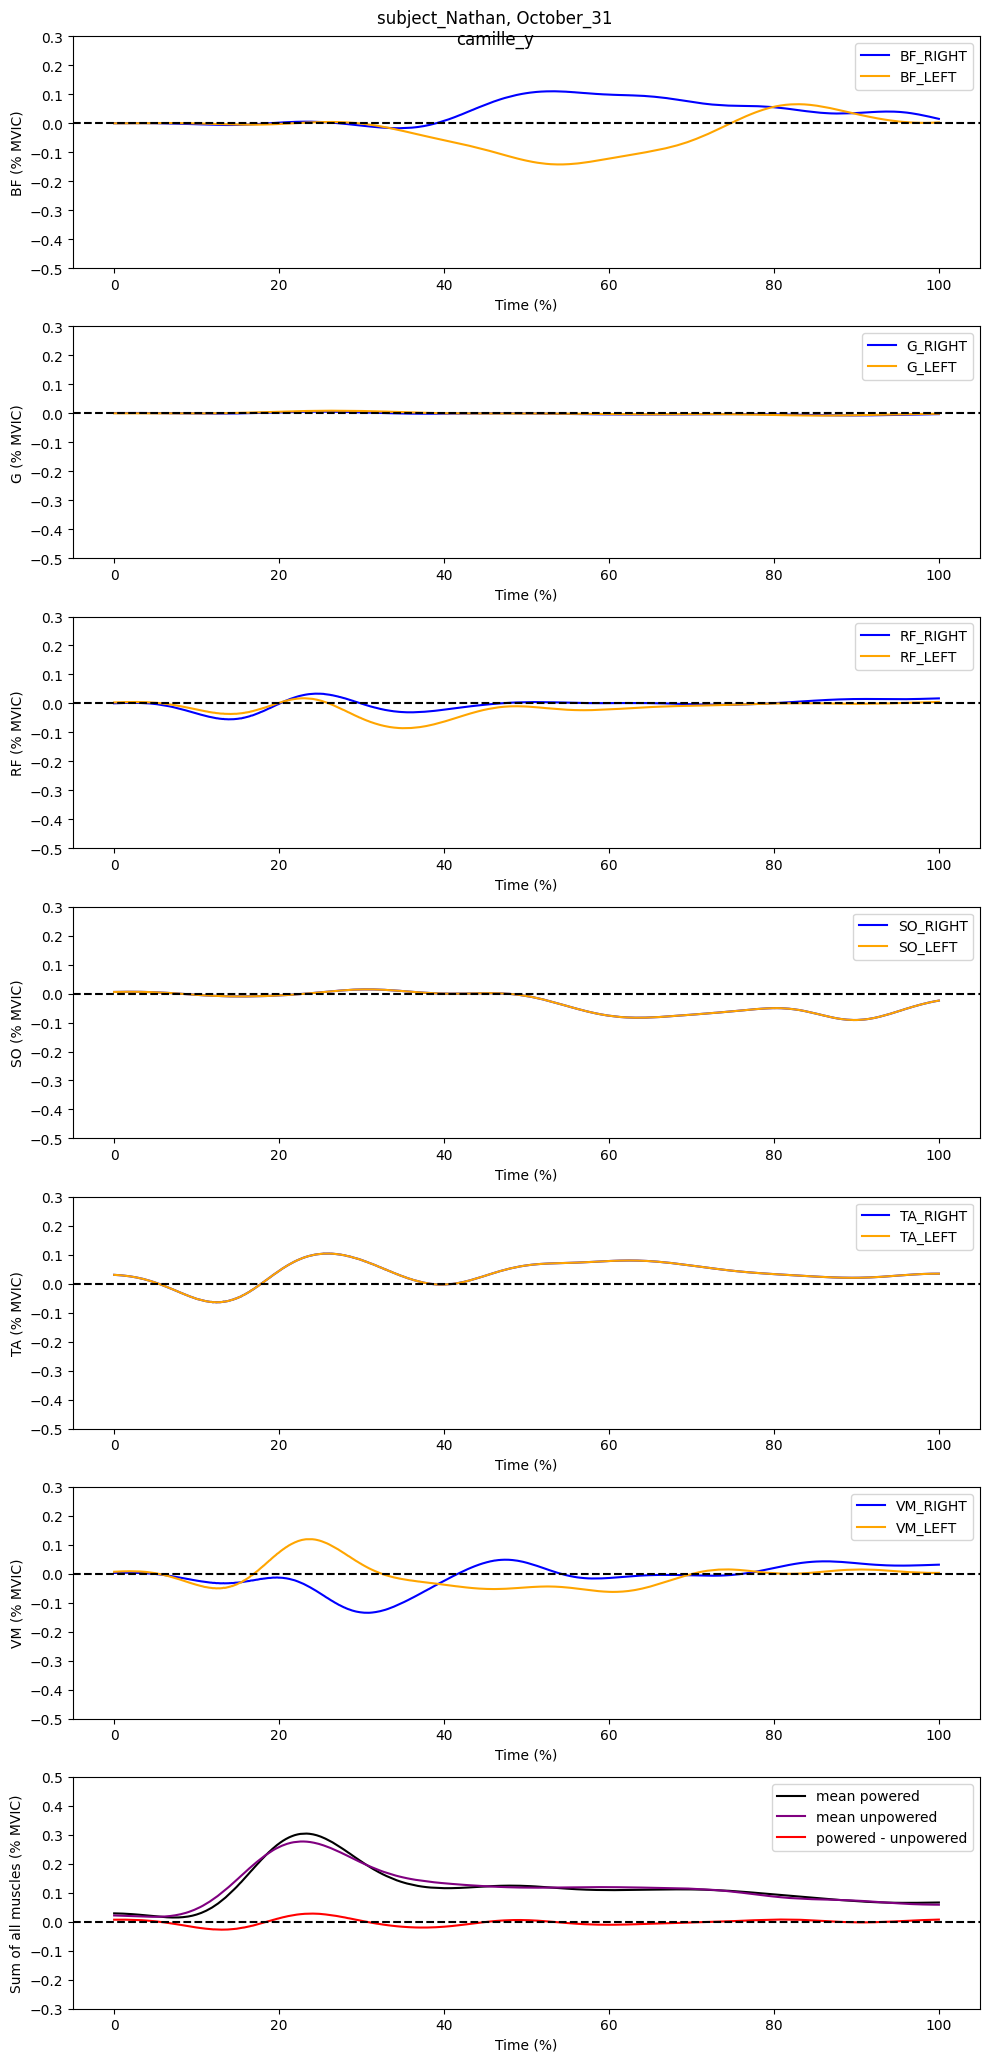

In [19]:
# For every assisted profile, plot the difference between the mean unpowered and the mean assisted profile
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["averaged_trimmed_time_dfs"]
        plot_dir = subject_dirs[subject][session]["plot_dir"] / "unpowered_vs_assisted"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg_assisted = trimmed_time_dfs["ASSISTED"][profile]["EMG"]
            emg_unpowered = trimmed_time_dfs["UNPOWERED"]["EMG"]

            emg_diff = emg_assisted - emg_unpowered

            filename = plot_dir / f"unpowered_vs_assisted_{profile}"

            muscles = emg_diff.columns
            # Remove IMU and TIME
            muscles = muscles.drop(["TIME", "IMU"])
            # Remove all _LEFT muscles
            muscles = muscles[~muscles.str.contains("_LEFT")]

            # Plot the difference in muscle activation for each muscle with subplots
            filename = plot_dir / f"unpowered_vs_assisted_{profile}"
            fig, axs = plt.subplots(len(muscles)+1, figsize=(10, 3 * (len(muscles)+1)))
            fig.suptitle(f"{subject}, {session}\n{profile}")

            for i, muscle in enumerate(muscles):
                # Muscle without _SIDE
                m = muscle.split("_")[0]
                
                # Plot EMG differences
                axs[i].plot(emg_diff.index, emg_diff[f"{m}_RIGHT"], label=f"{m}_RIGHT", color='blue')
                axs[i].plot(emg_diff.index, emg_diff[f"{m}_LEFT"], label=f"{m}_LEFT", color='orange')
                
                # Primary y-axis settings
                axs[i].set_ylabel(f"{m} (% MVIC)")
                axs[i].set_xlabel("Time (%)")
                axs[i].set_ylim(-0.5, 0.3)
                axs[i].axhline(0, color='black', linestyle='--')
                
                # Combine legends
                lines1, labels1 = axs[i].get_legend_handles_labels()
                # lines2, labels2 = ax2.get_legend_handles_labels()
                # axs[i].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
                axs[i].legend(lines1, labels1, loc='upper right')
            
            # Plot sum of all muscles
            sum_muscle = emg_assisted.drop(columns = ["TIME", "IMU"])
            sum_muscle = sum_muscle.sum(axis=1)
            sum_muscle /= (len(muscles) *2)
            
            emg_unpowered = emg_unpowered.drop(columns = ["TIME", "IMU"])
            unpowered_sum = emg_unpowered.sum(axis=1)
            unpowered_sum /= (len(muscles) *2)

            sum_diff = sum_muscle - unpowered_sum

            axs[len(muscles)].plot(emg_diff.index, sum_muscle, label="mean powered", color='black')
            axs[len(muscles)].plot(emg_diff.index, unpowered_sum, label="mean unpowered", color='purple')
            axs[len(muscles)].plot(emg_diff.index, sum_diff, label="powered - unpowered", color='red')
            axs[len(muscles)].set_ylabel("Sum of all muscles (% MVIC)")
            axs[len(muscles)].set_xlabel("Time (%)")
            axs[len(muscles)].set_ylim(-0.3, 0.5)
            axs[len(muscles)].axhline(0, color='black', linestyle='--')
            axs[len(muscles)].legend(loc='upper right')

            plt.tight_layout()
            # plt.savefig(filename, dpi=500, format='svg')
            plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
            plt.show()
                





In [ ]:
# For every assisted profile, plot the difference between the unpowered and the assisted profile
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
        averaged_trimmed_time_dfs = subject_data[subject][session]["averaged_trimmed_time_dfs"]
        plot_dir = subject_dirs[subject][session]["plot_dir"] / "unpowered_vs_assisted"
        plot_dir.mkdir(exist_ok=True)

        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            for iteration in range(len(trimmed_time_dfs["ASSISTED"][profile]["EMG"])):
                emg_assisted = trimmed_time_dfs["ASSISTED"][profile]["EMG"][iteration]
                emg_unpowered = averaged_trimmed_time_dfs["UNPOWERED"]["EMG"]

                emg_diff = emg_assisted - emg_unpowered

                filename = plot_dir / f"unpowered_vs_assisted_{profile}_iteration_{iteration}"

                muscles = emg_diff.columns
                # Remove IMU and TIME
                muscles = muscles.drop(["TIME", "IMU"])
                # Remove all _LEFT muscles
                muscles = muscles[~muscles.str.contains("_LEFT")]

                # Plot the difference in muscle activation for each muscle with subplots
                fig, axs = plt.subplots(len(muscles)+1, figsize=(10, 3 * (len(muscles)+1)))
                fig.suptitle(f"{subject}, {session}\n{profile}_iteration_{iteration}")

                for i, muscle in enumerate(muscles):
                    # Muscle without _SIDE
                    m = muscle.split("_")[0]
                    
                    # Plot EMG differences
                    axs[i].plot(emg_diff.index, emg_diff[f"{m}_RIGHT"], label=f"{m}_RIGHT", color='blue')
                    axs[i].plot(emg_diff.index, emg_diff[f"{m}_LEFT"], label=f"{m}_LEFT", color='orange')
                    
                    # Primary y-axis settings
                    axs[i].set_ylabel(f"{m} (% MVIC)")
                    axs[i].set_xlabel("Time (%)")
                    axs[i].set_ylim(-0.5, 0.5)
                    axs[i].axhline(0, color='black', linestyle='--')
                    
                    # Combine legends
                    lines1, labels1 = axs[i].get_legend_handles_labels()
                    axs[i].legend(lines1, labels1, loc='upper right')
                
                # Plot sum of all muscles
                sum_muscle = emg_assisted.drop(columns = ["TIME", "IMU"])
                sum_muscle = sum_muscle.sum(axis=1)
                sum_muscle /= (len(muscles) *2)
                
                emg_unpowered = emg_unpowered.drop(columns = ["TIME", "IMU"])
                unpowered_sum = emg_unpowered.sum(axis=1)
                unpowered_sum /= (len(muscles) *2)

                sum_diff = sum_muscle - unpowered_sum

                axs[len(muscles)].plot(emg_diff.index, sum_muscle, label="mean powered", color='black')
                axs[len(muscles)].plot(emg_diff.index, unpowered_sum, label="mean unpowered", color='purple')
                axs[len(muscles)].plot(emg_diff.index, sum_diff, label="powered - unpowered", color='red')
                axs[len(muscles)].set_ylabel("Sum of all muscles (% MVIC)")
                axs[len(muscles)].set_xlabel("Time (%)")
                axs[len(muscles)].set_ylim(-0.3, 0.5)
                axs[len(muscles)].axhline(0, color='black', linestyle='--')
                axs[len(muscles)].legend(loc='upper right')

                plt.tight_layout()
                # plt.savefig(filename, dpi=500, format='svg')
                plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
                plt.show()
                    





### Align force peak with peak timing percentage -> Might be useful in bayes

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
                
        shift_motor_data = deepcopy(relevant_time_ranges)
        profile_peaks = {profile: int(profile.split("_")[1][:-1]) for profile in trimmed_time_dfs["ASSISTED"].keys()}

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            for i, motor_df in enumerate(trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"]):
                old_range = relevant_time_ranges[profile]["ranges"][i]

                max_ind = motor_df.F_Y.argmax()
                old_peak_time = motor_df.iloc[max_ind].time

                closest_index_value = abs(motor_df.index - profile_infos[profile]["peak_time"]).argmin()
                closest_t_ind = motor_df.index[closest_index_value]
                new_peak_time = motor_df.loc[closest_t_ind].time

                shift_by = new_peak_time - old_peak_time

                new_range = time_range(old_range.min - shift_by, old_range.max - shift_by)
                shift_motor_data[profile]["ranges"][i] = new_range

        subject_data[subject][session]["time_shifted_motor_ranges"] = shift_motor_data

### Reset index to account for shifting

In [ ]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
        relevant_time_ranges = subject_data[subject][session]["relevant_time_ranges_imu"]
        time_shifted_motor_ranges = subject_data[subject][session]["time_shifted_motor_ranges"]

        trimmed_time_dfs = {"ASSISTED": dict(), "UNPOWERED": dict()}

        for profile in filtered_session_data["ASSISTED"].keys():
            rel_ranges = relevant_time_ranges[profile]["ranges"] # Get first iteration range
            motor_ranges = time_shifted_motor_ranges[profile]["ranges"]
            trimmed_time_dfs["ASSISTED"][profile] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["ASSISTED"][profile].values()

            trimmed_time_dfs["ASSISTED"][profile]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, motor_ranges)]
            trimmed_time_dfs["ASSISTED"][profile]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]

            for motor_df, rel_range in zip(motor_dfs, rel_ranges):
                if rel_range.min > motor_df.index[-1]:
                    print("Warning: cut-off range starts after motor data. Keeping whole range")
                    rel_range = rel_range._replace(min=motor_df.index[0])
                # trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"].append(motor_df.loc[rel_range.min:rel_range.max])

        for t_unpowered in filtered_session_data["UNPOWERED"].keys():
            rel_ranges = relevant_time_ranges[f"UNPOWERED_{t_unpowered}"]["ranges"] # Get first iteration range

            trimmed_time_dfs["UNPOWERED"][t_unpowered] = deepcopy(data_dict)

            emg_dfs, motor_dfs, marker_dfs = filtered_session_data["UNPOWERED"][t_unpowered].values()

            trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"] = [emg_df.loc[rel_range.min:rel_range.max] for emg_df, rel_range in zip(emg_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MARKER_DATA"] = [marker_df.loc[rel_range.min:rel_range.max] for marker_df, rel_range in zip(marker_dfs, rel_ranges)]
            trimmed_time_dfs["UNPOWERED"][t_unpowered]["MOTOR_DATA"] = [motor_df.loc[rel_range.min:rel_range.max] for motor_df, rel_range in zip(motor_dfs, rel_ranges)]
        
        subject_data[subject][session]["trimmed_time_dfs"] = trimmed_time_dfs

### Plotting the time-shifted data

In [ ]:
subject = "subject_Nathan"
session = "October_31"

trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["filtered_session_data"])

profiles = trimmed_time_dfs["ASSISTED"].keys()

n_rows = len(trimmed_time_dfs["ASSISTED"][list(profiles)[0]]["MOTOR_DATA"])
n_cols = len(profiles)

target_muscle = "BF"

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 7), sharex=True, sharey='row')  # Adjust as needed
fig.suptitle(f"{subject}\nAssisted activations for {target_muscle}\n")

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"motor_emg_{target_muscle}_assisted.svg"

for col, profile in enumerate(profiles):
    for row in range(len(trimmed_time_dfs["ASSISTED"][profile]["IMU"])):
        motor_df = trimmed_time_dfs["ASSISTED"][profile]["MOTOR_DATA"][row]  # Adjusted for demonstration
        emg_df = trimmed_time_dfs["ASSISTED"][profile]["EMG"][row]  # Adjusted for demonstration
        cur_range = relevant_time_ranges[profile]["ranges"][row]  # Assuming relevant_time_ranges is structured similarly

        axs[row, col].plot(motor_df.index, motor_df.F_Y, label=r"$F_Y$", color="g")
        axs[row, col].set_ylim(0, 70)
        axs[row, col].tick_params(axis='y', labelcolor='g')

        ax2 = axs[row, col].twinx()
        ax2.plot(emg_df.index, emg_df[f"{target_muscle}_LEFT"], label="LEFT")
        ax2.plot(emg_df.index, emg_df[f"{target_muscle}_RIGHT"], label="RIGHT")
        ax2.set_yticklabels('')
        if col == n_cols - 1:
            # Add N to the right y-axis
            ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x * 100:.0f}'))

        if col == len(profiles) - 1:
            ax2.set_ylabel("EMG (% MVIC)")
        ax2.set_ylim(0, 1)  # Set EMG activation scale from 0 to 1

        handles1, labels1 = axs[row, col].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2

        axs[row, 0].set_ylabel(f"Iteration {row+1}\nForce (N)")
        axs[-1, col].set_xlabel("STS (%")

        axs[0, col].set_title(profile, fontsize=16)

fig.legend(handles, labels, loc="upper center", ncol=len(handles), bbox_to_anchor=(0.5, 0.9))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

## Extract metrics from EMG data

### Average activation signals across trials

#### Equalize length of MOTOR and EMG data across iterations

In [20]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]        

        interpolated_dfs = deepcopy(trimmed_time_dfs)

        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["ASSISTED"][profile].values()

            emg_len = min([len(emg_df) for emg_df in emg])
            motor_len = min([len(motor_df) for motor_df in motor])
            imu_len = min([len(imu_df) for imu_df in imu])

            for i in range(len(emg)):
                if len(motor) > i:
                    interpolated_dfs["ASSISTED"][profile]["EMG"][i] = interpolate_dataframe_to_length(emg[i], emg_len)
                    interpolated_dfs["ASSISTED"][profile]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], motor_len)
                    interpolated_dfs["ASSISTED"][profile]["IMU"][i] = interpolate_dataframe_to_length(imu[i], imu_len)
                
        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["UNPOWERED"][unpowered_time].values()

            emg_len = min([len(emg_df) for emg_df in emg])
            motor_len = min([len(motor_df) for motor_df in motor])
            imu_len = min([len(imu_df) for imu_df in imu])

            for i in range(len(emg)):
                if len(motor) > i:
                    interpolated_dfs["UNPOWERED"][unpowered_time]["EMG"][i] = interpolate_dataframe_to_length(emg[i], emg_len)
                    interpolated_dfs["UNPOWERED"][unpowered_time]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], motor_len)
                    interpolated_dfs["UNPOWERED"][unpowered_time]["IMU"][i] = interpolate_dataframe_to_length(imu[i], imu_len)
        
        subject_data[subject][session]["interpolated_dfs"] = interpolated_dfs

### Average activations and motor data

In [21]:
# Interpolate dataframes to have the same length
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]

        interpolated_dfs = deepcopy(trimmed_time_dfs)

        # Initialize variables to store the minimum lengths for each type of data
        min_emg_len = float('inf')
        min_motor_len = float('inf')
        min_imu_len = float('inf')

        # Step 1: Identify the Minimum Lengths across all "ASSISTED" profiles
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["ASSISTED"][profile].values()

            min_emg_len = min(min_emg_len, min([len(emg_df) for emg_df in emg]))
            min_motor_len = min(min_motor_len, min([len(motor_df) for motor_df in motor]))
            min_imu_len = min(min_imu_len, min([len(imu_df) for imu_df in imu]))

        # Step 2: Apply Interpolation to "ASSISTED"
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["ASSISTED"][profile].values()

            for i in range(len(emg)):
                interpolated_dfs["ASSISTED"][profile]["EMG"][i] = interpolate_dataframe_to_length(emg[i], min_emg_len)
            for i in range(len(motor)):
                interpolated_dfs["ASSISTED"][profile]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], min_motor_len)
            for i in range(len(imu)):
                interpolated_dfs["ASSISTED"][profile]["IMU"][i] = interpolate_dataframe_to_length(imu[i], min_imu_len)

        # Step 3: Apply the Same Interpolation to "UNPOWERED"
        for unpowered_time in trimmed_time_dfs["UNPOWERED"].keys():
            emg, motor, imu, log = trimmed_time_dfs["UNPOWERED"][unpowered_time].values()

            for i in range(len(emg)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["EMG"][i] = interpolate_dataframe_to_length(emg[i], min_emg_len)
            for i in range(len(motor)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["MOTOR_DATA"][i] = interpolate_dataframe_to_length(motor[i], min_motor_len)
            for i in range(len(imu)):
                interpolated_dfs["UNPOWERED"][unpowered_time]["IMU"][i] = interpolate_dataframe_to_length(imu[i], min_imu_len)
        
        subject_data[subject][session]["interpolated_dfs"] = interpolated_dfs

In [22]:
# Drop time column
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        interpolated_dfs = subject_data[subject][session]["interpolated_dfs"]
        for profile in interpolated_dfs["ASSISTED"].keys():
            for emg_df, motor_df, marker_df in zip(*interpolated_dfs["ASSISTED"][profile].values()):
                emg_df.drop(columns="TIME", inplace=True, errors='ignore')
                marker_df.drop(columns="TIME", inplace=True, errors='ignore')

        for unpowered_time in interpolated_dfs["UNPOWERED"].keys():
            for emg_df, motor_df, marker_df in zip(*interpolated_dfs["UNPOWERED"][unpowered_time].values()):
                emg_df.drop(columns="TIME", inplace=True, errors='ignore')
                marker_df.drop(columns="TIME", inplace=True, errors='ignore')

In [23]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        interpolated_dfs = subject_data[subject][session]["interpolated_dfs"]
        filtered_session_data = subject_data[subject][session]["filtered_session_data"]
                
        average_profile_dfs = {"ASSISTED": {}, "UNPOWERED": {}}
        muscles = interpolated_dfs["UNPOWERED"]["BEFORE"]["EMG"][0].columns

        motor_assisted_columns = interpolated_dfs["ASSISTED"][list(interpolated_dfs["ASSISTED"].keys())[0]]["MOTOR_DATA"][0].columns
        motor_unpowered_columns = interpolated_dfs["UNPOWERED"]["BEFORE"]["MOTOR_DATA"][0].columns

        for mode, columns in zip(["ASSISTED", "UNPOWERED"], [motor_assisted_columns, motor_unpowered_columns]):
            for profile in interpolated_dfs[mode].keys():
                average_profile_dfs[mode][profile] = {"EMG": {"mean": None, "std": None}, "MOTOR_DATA": {"mean": None, "std": None}}

                # EMG Data
                muscles_means = {}
                muscles_std = {}

                for emg in interpolated_dfs[mode][profile]["EMG"]:
                    for muscle in emg.columns:
                        if muscle not in muscles_means:
                            muscles_means[muscle] = []
                            muscles_std[muscle] = []
                        muscles_means[muscle].append(emg[muscle])
                        muscles_std[muscle].append(emg[muscle])

                for muscle, dfs in muscles_means.items():
                    merged = pd.concat(dfs, axis=1)
                    muscles_means[muscle] = merged.mean(axis=1)
                    muscles_std[muscle] = merged.std(axis=1)

                average_profile_dfs[mode][profile]["EMG"]["mean"] = smooth_dataframe(pd.DataFrame.from_dict(muscles_means), window_size=1)
                average_profile_dfs[mode][profile]["EMG"]["std"] = smooth_dataframe(pd.DataFrame.from_dict(muscles_std), window_size=1)

                # MOTOR Data
                motor_means = {}
                motor_std = {}

                for motor_data in interpolated_dfs[mode][profile]["MOTOR_DATA"]:
                    for column in columns:
                        if column not in motor_means:
                            motor_means[column] = []
                            motor_std[column] = []
                        motor_means[column].append(motor_data[column])
                        motor_std[column].append(motor_data[column])

                for column, dfs in motor_means.items():
                    merged = pd.concat(dfs, axis=1)
                    motor_means[column] = merged.mean(axis=1)
                    motor_std[column] = merged.std(axis=1)

                average_profile_dfs[mode][profile]["MOTOR_DATA"]["mean"] = smooth_dataframe(pd.DataFrame.from_dict(motor_means))
                average_profile_dfs[mode][profile]["MOTOR_DATA"]["std"] = smooth_dataframe(pd.DataFrame.from_dict(motor_std))

        average_profile_dfs["UNPOWERED"]["BASELINE"] = {"EMG": {"mean": None, "std": None}, "MOTOR_DATA": {"mean": None, "std": None}}

        if "AFTER" in filtered_session_data["UNPOWERED"].keys():
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = (average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["mean"] + average_profile_dfs["UNPOWERED"]["AFTER"]["EMG"]["mean"]) / 2
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"] = (average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["std"] + average_profile_dfs["UNPOWERED"]["AFTER"]["EMG"]["std"]) / 2
        else:
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["mean"]
            average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"] = average_profile_dfs["UNPOWERED"]["BEFORE"]["EMG"]["std"]
        
        subject_data[subject][session]["average_profile_dfs"] = average_profile_dfs

In [24]:
subject = "subject_Nathan"
session = "October_31"

average_profile_dfs = subject_data[subject][session]["average_profile_dfs"]
unique_muscles = get_unique_muscles(subject_data[subject][session]["session_data"])

# Since first column is TIME we ignore it
n_muscles = len(average_profile_dfs["ASSISTED"][list(average_profile_dfs["ASSISTED"])[0]]["EMG"]["mean"].columns)
n_prof = len(average_profile_dfs["ASSISTED"].keys())

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"full_EMG_activations_and_motor.svg"

# We add 1 because we want to include the motor data in the first row
fig, ax = plt.subplots(nrows=n_muscles + 1, ncols=n_prof, figsize=(30, 20))

if False:
    fig.suptitle(f"{subject}\nEMG activations (paper match scaling)", fontsize=30)
else:
    fig.suptitle(f"{subject}\nEMG activations (MVIC scaled)", fontsize=30)

for i, profile in enumerate(average_profile_dfs["ASSISTED"].keys()):
    force_data = average_profile_dfs["ASSISTED"][profile]["MOTOR_DATA"]

    closest_index_value = abs(force_data["mean"].index).argmax()
    closest_t_ind = force_data["mean"].index[closest_index_value]

    ax[0, i].set_title(profile, fontsize=20)
    ax[0, i].plot(force_data["mean"].index, force_data["mean"].F_Y, label=r"$F_Y$", color='green')
    ax[0, i].axvline(closest_t_ind, color="red")
    ax[0, i].fill_between(force_data["mean"].index, force_data["mean"].F_Y - force_data["std"].F_Y, force_data["mean"].F_Y + force_data["std"].F_Y, alpha=0.2, color='green')
    ax[0, 0].set_ylabel('Force (N)', color='green', fontsize=16)
    ax[0, i].tick_params(axis='y', labelcolor='green', labelsize=16)
    ax[0, i].yaxis.set_major_formatter("{x:.0f}N")

    ax2 = ax[0, i].twinx()
    ax2.plot(force_data["mean"].index, force_data["mean"].Percentage/100, label="STS %", linestyle="--", color="purple")
    ax2.fill_between(force_data["mean"].index, force_data["mean"].Percentage/100 - force_data["std"].Percentage/100, force_data["mean"].Percentage/100 + force_data["std"].Percentage/100, alpha=0.2, color='purple')
    if i ==len(average_profile_dfs["ASSISTED"].keys())-1:
        ax2.set_ylabel('Measured STS %', color='purple', fontsize=16)
    ax2.tick_params(axis='y', labelcolor='purple', labelsize=16)
    ax2.xaxis.set_major_formatter(mticker.PercentFormatter())
    ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax2.set_ylim(0, 1)

    for j in range(1, n_muscles + 1):
        muscle = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"].columns[j-1]
        # peak_time = profile_infos[profile]["peak_time"]
        peak_time = closest_t_ind
        
        if i == 0:
            ax[j, i].set_ylabel(f"{muscle}\nEMG (% of MVIC)", fontsize=16)

        ax[-1, i].set_xlabel("Percentage of STS", fontsize=16)

        emg_mean = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"][muscle]
        emg_std = average_profile_dfs["ASSISTED"][profile]["EMG"]["std"][muscle]

        closest_peak_index = np.abs(emg_mean.index.astype(float) - peak_time).argmin()

        emg_baseline_mean = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
        emg_baseline_std = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]
           

        ax[j, i].plot(emg_mean.index, emg_mean, label=f"Trials")
        ax[j, i].fill_between(emg_mean.index, emg_mean - emg_std, emg_mean + emg_std, alpha=0.2)
        ax[j, i].plot(emg_baseline_mean.index, emg_baseline_mean, label=f"Baseline")
        ax[j, i].fill_between(emg_baseline_mean.index, emg_baseline_mean - emg_baseline_std, emg_baseline_mean + emg_baseline_std, alpha=0.2)
        ax[j, i].tick_params(axis='x', labelsize=16)
        ax[j, i].tick_params(axis='y', labelsize=16)
        ax[j, i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        ax[j, i].set_ylim(0, 1)
        
        force_handles, force_labels = ax[0, i].get_legend_handles_labels()

        handles1, labels1 = ax[j, i].get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2 + force_handles
        
        labels = labels1 + labels2 + force_labels
    
legend = fig.legend(handles, labels, loc="upper center", ncols=len(labels), fontsize=20, bbox_to_anchor=(0.5, 0.93))

for line in legend.get_lines():
    line.set_linewidth(4)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, dpi=500, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
shutil.copy(filename, latex_figure_dir / "emg_plots")
plt.show()

NameError: name 'get_unique_muscles' is not defined

### Calculate mean activation delta

In [25]:

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        average_profile_dfs = subject_data[subject][session]["average_profile_dfs"]      

        averaged_activations = deepcopy(average_profile_dfs)

        for profile in average_profile_dfs["ASSISTED"].keys():
            averaged_activations["ASSISTED"][profile]["EMG"]["mean"] = average_profile_dfs["ASSISTED"][profile]["EMG"]["mean"].mean()
            averaged_activations["ASSISTED"][profile]["EMG"]["std"] = average_profile_dfs["ASSISTED"][profile]["EMG"]["std"].mean()


        averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"] = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["mean"].mean()
        averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"] = average_profile_dfs["UNPOWERED"]["BASELINE"]["EMG"]["std"].mean()

        averaged_activations['UNPOWERED'].pop("BEFORE", None)
        averaged_activations['UNPOWERED'].pop("AFTER", None)

        subject_data[subject][session]["averaged_activations"] = averaged_activations

In [26]:
# Calculate deltas from unpowered vs assisted
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        averaged_activations = subject_data[subject][session]["averaged_activations"]

        n_profiles = len(averaged_activations["ASSISTED"].keys())
        muscles = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"].index
        
        muscle_deltas = []  # For storing deltas
        muscle_activations = []  # For storing activations

        for muscle in muscles:
            mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
            std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]
            
            muscle_activations.append({"Profile": "BASELINE", "Muscle": muscle, "Mean Activation": mean_baseline, "STD Activation": std_baseline})


        for profile in subject_data[subject][session]["session_data"]["ASSISTED"].keys():
            muscle_means_delta = []  # To calculate deltas
            muscle_stds_delta = []

            muscle_means_activation = []  # To store activations
            muscle_stds_activation = []

            for muscle in muscles:
                mean_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["mean"][muscle]
                std_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["std"][muscle]
                
                mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
                std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]

                # Calculate deltas
                mean_delta = (mean_assisted - mean_baseline) / mean_baseline
                std_delta = (std_assisted + std_baseline)
                
                # Append delta calculations
                muscle_means_delta.append(mean_delta)
                muscle_stds_delta.append(std_delta)
                muscle_deltas.append({"Profile": profile, "Muscle": muscle, "Mean Delta": mean_delta, "STD Delta": std_delta})
                
                # Append activations
                muscle_means_activation.append(mean_assisted)
                muscle_stds_activation.append(std_assisted)
                muscle_activations.append({"Profile": profile, "Muscle": muscle, "Mean Activation": mean_assisted, "STD Activation": std_assisted})
                
            # Append average of all muscles to each profile for deltas
            muscles_delta_df = pd.DataFrame({"means": muscle_means_delta, "stds": muscle_stds_delta}, index=muscles).mean()
            muscle_deltas.append({"Profile": profile, "Muscle": "AVERAGE", "Mean Delta": muscles_delta_df.means, "STD Delta": muscles_delta_df.stds})
            
            # Append average of all muscles to each profile for activations
            muscles_activation_df = pd.DataFrame({"means": muscle_means_activation, "stds": muscle_stds_activation}, index=muscles).mean()
            muscle_activations.append({"Profile": profile, "Muscle": "AVERAGE", "Mean Activation": muscles_activation_df.means, "STD Activation": muscles_activation_df.stds})
        
            
        # Convert the collected data into DataFrames and store them under their respective keys
        df_deltas = pd.DataFrame(muscle_deltas)
        df_activations = pd.DataFrame(muscle_activations)
        subject_data[subject][session]["mean_delta_activations"] = df_deltas
        subject_data[subject][session]["absolute_mean_activations"] = df_activations

### XABI

In [ ]:
fig, axs = plt.subplots(figsize=(10, 5))
fig.suptitle(f"Mean muscle activation $\Delta$\nper subject and profile", fontsize=20)

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activations.svg"

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activations.svg"

profile_deltas = {}

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        mean_delta_activations = subject_data[subject][session]["mean_delta_activations"]
        muscle_averages = mean_delta_activations[mean_delta_activations["Muscle"] == "AVERAGE"]
        
        # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

        axs.plot(muscle_averages["Profile"], muscle_averages["Mean Delta"], label=subject, marker='*', linewidth=3, markersize=10)

        for index, row in muscle_averages.iterrows():
            if row["Profile"] not in profile_deltas:
                profile_deltas[row["Profile"]] = []
            profile_deltas[row["Profile"]].append(row["Mean Delta"])

average_deltas = {profile: np.mean(deltas) for profile, deltas in profile_deltas.items()}
average_values = list(average_deltas.values())

axs.grid(False)
axs.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
# axs.hlines(0, profile_peaks['peak_27%_62N'], profile_peaks['peak_77%_62N'], color='black', linestyle='--')
axs.set_xlabel("Profile_Name")
# axs.set_xticks(list(profile_peaks.values()))
axs.set_ylabel("Muscle Activity Reduction (%)")

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# axs.spines['bottom'].set_visible(False)  # Adjust thickness of the arrow

# Make x-axis and y-axis arrows
axs.spines['left'].set_linewidth(2)
axs.spines['bottom'].set_linewidth(2)  # Adjust thickness of the arrow
axs.spines['bottom'].set_capstyle('projecting')  # Arrow style
offset = 0.03


axs.set_ylim(-0.4, 0.2)
axs.legend(fontsize=16, title="Subjects", title_fontsize='16', loc='upper right')

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(filename, format='svg')
plt.savefig("../paper_figures/mean_delta_activations.svg", format='svg')
plt.savefig("../paper_figures/mean_delta_activations.png", dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / "mean_delta_activations.png", dpi=500, format="png")
plt.show()



In [ ]:
# Plot average muscle activations per profile as a line plot
n_subjects = len(subject_data.keys())


fig, axs = plt.subplots(1, n_subjects, figsize=(20, 5), sharey=True)

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        mean_activations = subject_data[subject][session]["absolute_mean_activations"]
        mean_activations = mean_activations[mean_activations["Profile"] != "BASELINE"]
        for muscle in mean_activations.Muscle.unique():
            muscle_averages = mean_activations[mean_activations["Muscle"] == muscle]

            # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

            axs[i].plot(muscle_averages["Profile"], muscle_averages["Mean Activation"], label=muscle, marker='*', linewidth=3, markersize=10)

        # axs[i].set_xticks(list(profile_peaks.values()))
        axs[i].set_title(f"Subject {subject}", fontsize=20)
        axs[i].legend(loc="upper right", fontsize=10)
        axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        axs[i].set_xlabel("Peak Timing of Assistance (%)")
        axs[0].set_ylabel("Mean Activation (% of MVIC)")

# plt.savefig("../paper_figures/mean_absolute_activations_per_subject.svg", format='svg')
# plt.savefig("../paper_figures/mean_absolute_activations_per_subject.png", dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / 'mean_absolute_activations_per_subject.png', dpi=500, format="png")
plt.show()

In [ ]:
n_subjects = len(subject_data.keys())

fig, axs = plt.subplots(1, n_subjects, figsize=(20, 5), sharey=True)  # Ensure axs is 2D
# Predefined colors for specific muscles
colors = {'BASELINE': '#1f77b4', 'AVERAGE': 'orange'}

for i, subject in enumerate(subject_data.keys()):
    muscle_colors = {}  # Dictionary to dynamically assign colors to each muscle
    for session in subject_data[subject].keys():
        mean_activations = subject_data[subject][session]['absolute_mean_activations']
        mean_activations = mean_activations[mean_activations["Profile"] != "BASELINE"]
        muscles = sorted(mean_activations.Muscle.unique())
        
        # Dynamically generate grey shades based on the number of muscles
        grey_count = len([m for m in muscles if m not in colors])
        grey_values = np.linspace(0.8, 0.2, grey_count)  # Light (0.8) to dark (0.2)
        grey_counter = 0
        # Assign grey shades to muscles not in the predefined colors
        for index, muscle in enumerate(muscles):
            if muscle not in colors:
                # Use the grey_counter to access grey_values
                grey = grey_values[grey_counter]
                # Convert grey value to RGB format
                rgb_grey = (grey, grey, grey)
                muscle_colors[muscle] = rgb_grey
                # Increment the grey_counter
                grey_counter += 1
        
        # Update the colors dictionary with dynamically generated grey shades
        colors.update(muscle_colors)
        
        for muscle in muscles:
            muscle_averages = mean_activations[mean_activations["Muscle"] == muscle]
            # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())
            color = colors.get(muscle)
            
            # Plot line with dynamically assigned color
            axs[i].plot(muscle_averages["Profile"], muscle_averages["Mean Activation"], 
                           label=muscle, marker='*', linewidth=3, markersize=10, color=color)
            
            # Place muscle name next to the line on the right
            if not muscle_averages.empty:
                axs[i].text(muscle_averages["Profile"].iloc[-1], muscle_averages["Mean Activation"].iloc[-1], 
                               f"  {muscle}", verticalalignment='center', color=color)

        axs[i].set_xticks(list(profile_peaks.values()))
        axs[i].set_title(f"Subject {subject}", fontsize=20)
        axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))
        axs[i].set_xlabel("Peak Timing of Assistance (%)")
        axs[0].set_ylabel("Mean Activation\n(% of MVIC)")

# Remove the legend since muscle names are annotated on the plot
for ax in axs.flat:
    ax.legend().set_visible(False)

plt.tight_layout()
# plt.savefig("../paper_figures/mean_absolute_activations_per_subject_bw.svg", format='svg')
# plt.savefig("../paper_figures/mean_absolute_activations_per_subject_bw.png", dpi=500, format='png')
# plt.savefig(latex_figure_dir / "emg_plots" / 'mean_absolute_activations_per_subject_bw.png', dpi=500, format="png")
plt.show()

In [ ]:
all_deltas = []
all_means = []


for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        df_delta = subject_data[subject][session]["mean_delta_activations"]
        df_means = subject_data[subject][session]["absolute_mean_activations"]
        df_baseline = subject_data[subject][session]["average_profile_dfs"]["UNPOWERED"]["BASELINE"]["EMG"]["mean"]
        
        # Ensuring each DataFrame has 'Subject' and 'Session'
        df_delta['Subject'] = subject
        df_delta['Session'] = session
        df_means['Subject'] = subject
        df_means['Session'] = session
        
        all_deltas.append(df_delta)
        all_means.append(df_means)

df_all_deltas = pd.concat(all_deltas)
df_all_means = pd.concat(all_means)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)
df_all_means.sort_values(by="Muscle", ascending=True, inplace=True)

In [ ]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures") / f"mean_delta_activation_muscle_profile_subject.svg"

fig, ax = plt.subplots(1, n_profiles, figsize=(35, 10), sharey=True)
fig.suptitle("Average Activation $\Delta$\nacross Subjects and Muscles", fontsize=24, y=1.1)

profiles = subject_data[subject][session]["session_data"]["ASSISTED"].keys()

# delete imu and time
df_all_deltas = df_all_deltas[df_all_deltas["Muscle"] != "IMU"]
df_all_means = df_all_means[df_all_means["Muscle"] != "IMU"]

for i, profile in enumerate(profiles):
    df_deltas_profile = df_all_deltas[df_all_deltas['Profile'] == profile].sort_values(by="Subject")
    df_means_profile = df_all_means[df_all_means['Profile'] == profile].sort_values(by="Subject")

    df_deltas_profile[df_deltas_profile['Muscle'] == "AVERAGE"]

    # Plotting delta activations with consideration for missing data
    sns.barplot(x="Muscle", y="Mean Delta", hue="Subject", data=df_deltas_profile, ax=ax[i], dodge=True)

    # # Adding error bars for delta activations
    ax[i].set_xlabel("Muscles", fontsize=16)
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=10)
    ax[i].tick_params(axis='y', labelsize=16)
    ax[i].set_ylabel("Mean Activation $\Delta$ (%)", fontsize=20)
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax[i].set_title(profile, fontsize=24)
    ax[i].tick_params(labelleft=True)

    handles, labels = ax[i].get_legend_handles_labels()

    ax[i].get_legend().remove()

    
fig.legend(handles, labels, fontsize=20, ncols=len(handles), bbox_to_anchor=(0.56, 1.02))  
plt.tight_layout()
# plt.savefig(filename, format='svg')
# plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

In [ ]:
subject = "subject_Nathan"
session = "October_31"

df_delta = subject_data[subject][session]["mean_delta_activations"]
df_means = subject_data[subject][session]["absolute_mean_activations"]

plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"mean_delta_activation_muscle_profile_{subject}.svg"

fig, axs = plt.subplots(1, n_profiles, figsize=(30, 10))
fig.suptitle(f"Subject {subject}\nMean muscle activation $\Delta$", fontsize=20, y=1.02)

for i, profile in enumerate(profiles):
    profile_df = df_delta[df_delta["Profile"] == profile]
    sns.barplot(x="Muscle", y="Mean Delta", data=profile_df, ax=axs[i], dodge=False)
    
    # Adding error bars
    for j, muscle in enumerate(profile_df["Muscle"].unique()):
        axs[i].errorbar(j, profile_df[profile_df["Muscle"] == muscle]["Mean Delta"].values[0],
                        yerr=profile_df[profile_df["Muscle"] == muscle]["STD Delta"].values[0], 
                        fmt='none', color='gray', capsize=5, elinewidth=2)
    axs[i].set_title(profile, fontsize=14)
    axs[i].set_xlabel("Muscle", fontsize=16)
    axs[i].set_ylabel("Mean activation delta (%)", fontsize=16)
    axs[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

    plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right")

plt.tight_layout(rect=[0, 0, 1, 1])  # Adjust the layout to make room for the suptitle
# plt.savefig(filename, format='svg')
# plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.show()

### Calculate peak activation delta

In [34]:
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        n_profiles = len(averaged_activations["ASSISTED"].keys())
        muscles = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"].index
        data = []

        for profile in profiles:
            muscle_means = []
            muscle_stds = []

            for muscle in muscles:
                mean_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["mean"][muscle]
                std_assisted = averaged_activations["ASSISTED"][profile]["EMG"]["std"][muscle]
                
                mean_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["mean"][muscle]
                std_baseline = averaged_activations["UNPOWERED"]["BASELINE"]["EMG"]["std"][muscle]

                mean_delta = (mean_assisted - mean_baseline) / mean_baseline
                std_delta = (std_assisted + std_baseline) #/ std_baseline

                muscle_means.append(mean_delta)
                muscle_stds.append(std_delta)
                
                data.append({"Profile": profile, "Muscle": muscle, "Mean Delta": mean_delta, "STD Delta": std_delta})
                
            muscles_delta_df = pd.DataFrame({"means": muscle_means, "stds": muscle_stds}, index=muscles).mean()
            data.append({"Profile": profile, "Muscle": "Average", "Mean Delta": muscles_delta_df.means, "STD Delta": muscles_delta_df.stds})
            # Append average of all muscles to each profile
        df = pd.DataFrame(data)

        subject_data[subject][session]["mean_delta_activations"] = df

In [35]:
# Calculate peak EMG values for each muscle (before and after trials)
for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        trimmed_time_dfs = subject_data[subject][session]["trimmed_time_dfs"]
        muscles = subject_data[subject][session]["averaged_activations"]["ASSISTED"]["camille"]["EMG"]["mean"].index
        # muscles = ["BF_L", "BF_R", "RF_L", "RF_R", "VM_L", "VM_R", "VL_L", "VL_R", "GAS_L", "GAS_R", "SOL_L", "SOL_R", "TA_L", "TA_R"]

        peak_emg_means = []
        
        for t_unpowered in trimmed_time_dfs["UNPOWERED"].keys():
            peak_means = [df.max() for df in trimmed_time_dfs["UNPOWERED"][t_unpowered]["EMG"]]
            peak_emg_means.append(sum(peak_means) / len(peak_means))

        peak_emg_means = sum(peak_emg_means) / len(peak_emg_means)

        # Calculate average peak EMG values for each muscle (assisted trials)
        peak_values_assisted = defaultdict(dict)
        for profile in trimmed_time_dfs["ASSISTED"].keys():
            max_values_assisted = pd.DataFrame([df.max() for df in trimmed_time_dfs["ASSISTED"][profile]["EMG"]])
            peak_values_assisted[profile]["mean"] = max_values_assisted.mean()
            peak_values_assisted[profile]["std"] = max_values_assisted.std()

        peak_activation_deltas = []

        for profile in profiles:
            peak_means = []
            peak_stds = []

            for muscle in muscles:
                peak_mean = peak_values_assisted[profile]["mean"][muscle]
                peak_std = peak_values_assisted[profile]["std"][muscle]

                peak_mean_baseline = peak_emg_means[muscle]
                peak_std_baseline = peak_emg_means[muscle]

                peak_delta = (peak_mean - peak_mean_baseline) / peak_mean_baseline
                peak_std_delta = (peak_std + peak_std_baseline)


                peak_means.append(peak_delta)
                peak_stds.append(peak_std_delta)

                peak_activation_deltas.append({"Profile": profile, "Muscle": muscle, "Mean Delta": peak_delta, "STD Delta": peak_std_delta})

            peaks_df = pd.DataFrame({"means": peak_means, "stds": peak_stds}, index=muscles).mean()
            peak_activation_deltas.append({"Profile": profile, "Muscle": "Average", "Mean Delta": peaks_df.means, "STD Delta": peaks_df.stds})

        peak_activation_deltas_df = pd.DataFrame(peak_activation_deltas)

        subject_data[subject][session]["peak_activation_deltas"] = peak_activation_deltas_df

In [ ]:
all_deltas = []
all_means = []

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        df_delta = subject_data[subject][session]["peak_activation_deltas"]
        
        # Ensuring each DataFrame has 'Subject' and 'Session'
        df_delta['Subject'] = subject
        df_delta['Session'] = session
        
        all_deltas.append(df_delta)

df_all_deltas = pd.concat(all_deltas)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)

In [ ]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures") / f"average_peak_activation_delta_profile_subject.svg"

fig, ax = plt.subplots(1, n_profiles, figsize=(35, 10), sharey=True)
fig.suptitle("Average Peak Activation $\Delta$\nacross Subjects and Muscles", fontsize=24, y=1.1)

profiles = subject_data[subject][session]["session_data"]["ASSISTED"].keys()

for i, profile in enumerate(profiles):
    df_peak_deltas = df_all_deltas[df_all_deltas["Profile"] == profile].sort_values(by="Subject")

    # Drop rows where muscle == IMU or TIME
    df_peak_deltas = df_peak_deltas[df_peak_deltas["Muscle"] != "IMU"]
    df_peak_deltas = df_peak_deltas[df_peak_deltas["Muscle"] != "TIME"]

    # Plotting delta activations with consideration for missing data
    sns.barplot(x="Muscle", y="Mean Delta", hue="Subject", data=df_peak_deltas, ax=ax[i], dodge=True)

    # # Adding error bars for delta activations
    ax[i].set_xlabel("Muscles", fontsize=16)
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
    ax[i].set_ylabel("Peak Activation $\Delta$ (%)", fontsize=20)
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
    ax[i].set_title(profile, fontsize=24)
    ax[i].tick_params(labelleft=True)

    handles, labels = ax[i].get_legend_handles_labels()

    ax[i].get_legend().remove()

    
fig.legend(handles, labels, fontsize=20, ncols=len(handles), bbox_to_anchor=(0.56, 1.02))  
plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()

NameError: name 'all_deltas' is not defined

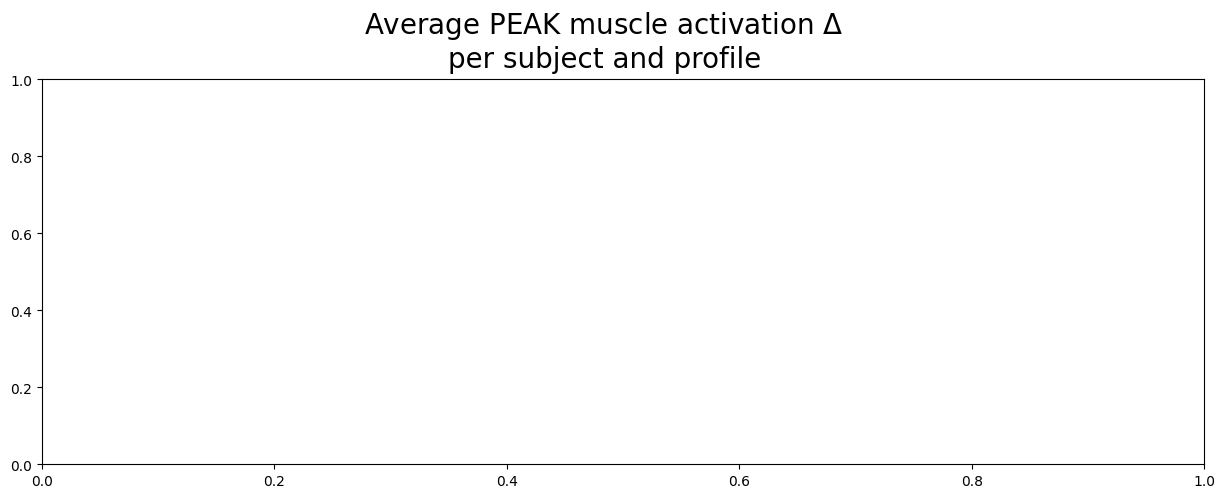

In [32]:
fig, axs = plt.subplots(figsize=(15, 5))
fig.suptitle(f"Average PEAK muscle activation $\Delta$\nper subject and profile", fontsize=20, y=1.02)

df_all_deltas = pd.concat(all_deltas)

df_all_deltas.sort_values(by="Muscle", ascending=True, inplace=True)

In [1]:
# Create a figure and axis for the plot
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = Path("../paper_figures/") / f"peak_activation_deltas_per_subject.svg"

# Initialize a dictionary to store Mean Delta values for each profile across subjects
profile_deltas = {}

for subject in subject_data.keys():
    for session in subject_data[subject].keys():
        mean_delta_activations = subject_data[subject][session]["peak_activation_deltas"]
        muscle_averages = mean_delta_activations[mean_delta_activations["Muscle"] == "Average"]

        # muscle_averages.loc[:, "Profile"] = list(profile_peaks.values())

        # Plotting each subject's data
        # axs.plot(muscle_averages["Profile"], muscle_averages["Mean Delta"], label=subject, marker='*', linewidth=3, markersize=10)
        
        # Accumulate Mean Delta values for averaging later
        for index, row in muscle_averages.iterrows():
            if row["Profile"] not in profile_deltas:
                profile_deltas[row["Profile"]] = []
            profile_deltas[row["Profile"]].append(row["Mean Delta"])

# Calculate and plot the average across subjects for each profile
average_deltas = {profile: np.mean(deltas) for profile, deltas in profile_deltas.items()}
profiles = subject_data[subject][session]["session_data"]["ASSISTED"].keys()
average_values = list(average_deltas.values())

# axs.set_xticks(list(profile_peaks.values()))

# axs.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))
# axs.hlines(0, profile_peaks['peak_27%_62N'], profile_peaks['peak_77%_62N'], color='black', linestyle='--')
axs.set_xlabel("Peak Timing of Assistance (%)")
axs.set_ylabel("Peak Activation Delta\n(% of baseline peak)")
axs.set_ylim(-0.4, 0.4)
axs.legend(fontsize=16, title="Subjects", title_fontsize='16', loc='upper right')

# plt.savefig(filename, format='svg', bbox_inches='tight')
# plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png", bbox_inches='tight')
plt.show()

NameError: name 'subject_dirs' is not defined

In [ ]:
assisted_average_activations = pd.concat([subject_data[subject][session]['averaged_activations']['ASSISTED'][profile]['EMG']['mean'] for profile in profile_infos.keys()], axis=1).T.mean()

In [30]:
def label_bars(ax: plt.axes, bars: list, texts: list, orient: Literal['v', 'h'] = 'v'):
    for i, bar in enumerate(bars):
        if orient == 'v':
            # For vertical bars, position the label above the bar
            bar_height = bar.get_height()
            bar_x = bar.get_x()
            bar_width = bar.get_width()
            center = bar_x + bar_width / 2
            ax.text(center, bar_height, texts[i], ha='center', va='bottom', fontsize=14)
        else:
            # For horizontal bars, position the label to the right of the bar
            bar_width = bar.get_width()
            bar_y = bar.get_y()
            bar_height = bar.get_height()
            center = bar_y + bar_height / 2
            # Determine the horizontal alignment based on the sign of the bar width
            ha = 'left' if bar_width >= 0 else 'right'
            # Offset the text from the end of the bar by a fraction of the bar width
            offset = bar_width * 0.01 if bar_width >= 0 else bar_width * 0.01 - 0.02
            ax.text(bar_width + offset, center, texts[i], ha=ha, va='center', fontsize=14)


In [ ]:
fig, ax = plt.subplots(2, figsize=(15, 10))
fig.suptitle("Average muscle activation across all profiles", fontsize=20)

for i, subject in enumerate(subject_data.keys()):
    subject_df = df_all_means[df_all_means["Subject"] == subject].drop(columns=["Subject", "Session"])
    baseline_df = subject_df[subject_df["Profile"] == "BASELINE"].drop(columns=["Profile"])

    # Remove time row from subject_df and baseline_df
    baseline_df = baseline_df[(baseline_df["Muscle"] != "TIME")]

    subject_df = subject_df[(subject_df["Profile"] != "BASELINE") & (subject_df["Muscle"] != "AVERAGE") & (subject_df["Profile"] != "TIME")]
    subject_df = subject_df.drop(columns='Profile').groupby('Muscle').mean().reset_index()
    subject_df['Group'] = 'Assisted'
    baseline_df['Group'] = 'Baseline'

    # Muscle activation averages by muscle and subject across profiles.
    muscle_avg_across_profiles = pd.concat([subject_df, baseline_df], ignore_index=True).sort_values(by="Group", ascending=False)
    # Remove time columns
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "TIME"]
    assisted_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Assisted"].set_index("Muscle")
    baseline_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Baseline"].set_index("Muscle")
    
    sns.barplot(x="Muscle", y="Mean Activation", data=muscle_avg_across_profiles, hue='Group', ax=ax[i])


    percentage_change = (assisted_df['Mean Activation'] - baseline_df['Mean Activation']) / baseline_df['Mean Activation']
    percentage_change = percentage_change.reset_index()
    percentage_change.columns = ["Muscle", "Activation Delta"]
    percentage_change = percentage_change.values[:, 1]

    percentage_change = [f"{val*100:.0f}%" for val in percentage_change]

    bars = ax[i].patches[:-2]

    baseline_bars = bars[:len(bars)//2]
    assisted_bars = bars[len(bars)//2:]

    label_bars(ax[i], baseline_bars, len(bars)//2 * ["0%"])
    label_bars(ax[i], assisted_bars, percentage_change)
    
    ax[0].set_ylim(0, 0.5)
    ax[1].set_ylim(0, 0.7)
    ax[i].legend().remove()
    ax[i].set_title(f"Subject {subject}")
    ax[i].set_ylabel("Average Muscle Activation (% of MVIC)")
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None))
    handles, labels = ax[i].get_legend_handles_labels()

fig.legend(handles=handles, labels=labels, loc="upper right", fontsize=16, title="Condition", title_fontsize=16, bbox_to_anchor=(0.95, 1.02))
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
# plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.svg", format='svg', bbox_inches='tight')
# plt.savefig("../paper_figures/assisted_vs_baseline_activation_change.png", dpi=500, format='png', bbox_inches='tight')
# plt.savefig(latex_figure_dir / "emg_plots" / "assisted_vs_baseline_activation_change.png", dpi=500, format="png", bbox_inches='tight')
plt.show()


NameError: name 'df_all_means' is not defined

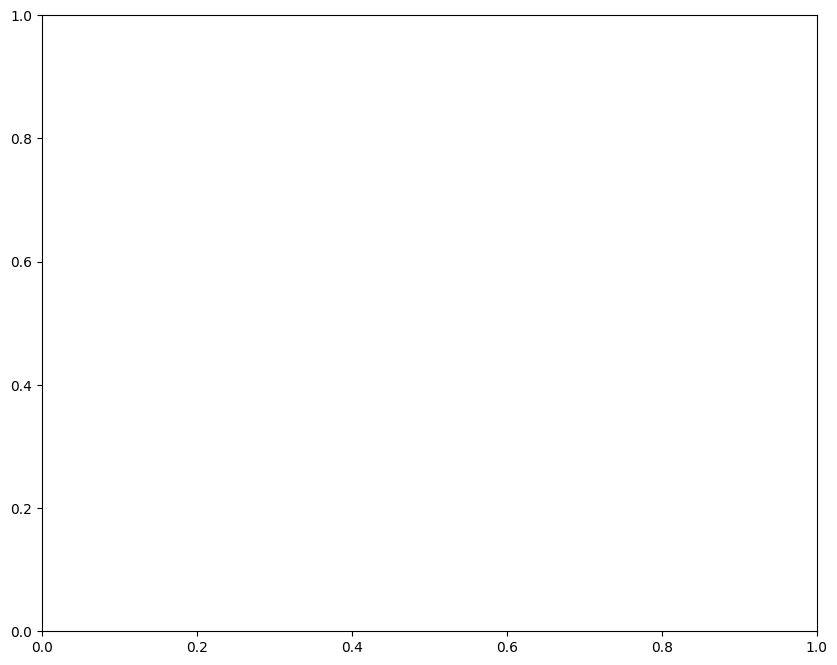

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import re

plot_dir = subject_dirs[subject][session]["plot_dir"]/"mean_delta_activations"
plot_dir.mkdir(parents=True, exist_ok=True)
filename = plot_dir / f"mean_delta_activations_all.svg"

# Initialize fig and ax for multiple subplots
fig, ax = plt.subplots(nrows=len(subject_data.keys()), ncols=1, figsize=(10, 8), squeeze=False)
ax = ax.flatten()  # Ensure ax is always an array for consistent indexing

# Custom sort key function to sort by base muscle name and then by "LEFT" or "RIGHT"
def muscle_sort_key(muscle):
    base_name = re.sub(r'_(LEFT|RIGHT)', '', muscle)  # Extract base name (e.g., "BF" from "BF_LEFT")
    side = '0' if 'LEFT' in muscle else '1'  # "LEFT" comes before "RIGHT"
    return (base_name, side)

for i, subject in enumerate(subject_data.keys()):
    subject_df = df_all_means[df_all_means["Subject"] == subject].drop(columns=["Subject", "Session"])
    baseline_df = subject_df[subject_df["Profile"] == "BASELINE"].drop(columns=["Profile"])

    # Remove any 'TIME' rows
    baseline_df = baseline_df[baseline_df["Muscle"] != "TIME"]
    subject_df = subject_df[(subject_df["Profile"] != "BASELINE") & (subject_df["Muscle"] != "AVERAGE") & (subject_df["Muscle"] != "TIME")]

    # Calculate averages for each muscle
    subject_df = subject_df.drop(columns='Profile').groupby('Muscle').mean().reset_index()
    subject_df['Group'] = 'Assisted'
    baseline_df['Group'] = 'Baseline'

    # Combine and sort by muscle pairs (LEFT and RIGHT) in desired order
    muscle_avg_across_profiles = pd.concat([subject_df, baseline_df], ignore_index=True)
    muscle_avg_across_profiles['SortKey'] = muscle_avg_across_profiles['Muscle'].apply(muscle_sort_key)
    muscle_avg_across_profiles = muscle_avg_across_profiles.sort_values(by=["SortKey", "Group"], ascending=[True, False]).drop(columns='SortKey')

    # Remove any remaining 'TIME' rows in combined DataFrame
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "TIME"]
    # remove TA_LEFT
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "TA_LEFT"]
    # remove SO_LEFT
    muscle_avg_across_profiles = muscle_avg_across_profiles[muscle_avg_across_profiles["Muscle"] != "SO_LEFT"]

    # Separate assisted and baseline groups for further processing
    assisted_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Assisted"].set_index("Muscle")
    baseline_df = muscle_avg_across_profiles[muscle_avg_across_profiles["Group"] == "Baseline"].set_index("Muscle")

    # Plotting
    sns.barplot(x="Muscle", y="Mean Activation", data=muscle_avg_across_profiles, hue='Group', ax=ax[i])

    # Calculate percentage change and ensure alignment with Muscle order
    percentage_change_df = (assisted_df['Mean Activation'] - baseline_df['Mean Activation']) / baseline_df['Mean Activation']
    percentage_change_df = percentage_change_df.reset_index()
    percentage_change_df.columns = ["Muscle", "Activation Delta"]
    percentage_change_labels = [f"{val*100:.0f}%" for val in percentage_change_df["Activation Delta"]]

    # Get bars in correct muscle order (assumes order of bars matches plot data)
    bars = ax[i].patches
    num_muscles = len(percentage_change_labels)
    baseline_bars = bars[:num_muscles]   # Baseline group bars
    assisted_bars = bars[num_muscles:num_muscles * 2]  # Assisted group bars

    # Apply labels to each group separately, using correct alignment
    label_bars(ax[i], baseline_bars, ["0%"] * num_muscles)
    label_bars(ax[i], assisted_bars, percentage_change_labels)
    
    ax[i].set_ylim(0, 0.4 if i == 0 else 0.7)
    ax[i].legend().remove()
    ax[i].tick_params(axis='x', labelrotation=45, labelsize=12)
    ax[i].set_title(f"Subject {subject}")
    ax[i].set_ylabel("Average Muscle Activation (% of MVIC)")
    ax[i].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None))
    handles, labels = ax[i].get_legend_handles_labels()

# Add a legend for all subplots
fig.legend(handles=handles, labels=labels, loc="upper right", fontsize=16, title="Condition", title_fontsize=16, bbox_to_anchor=(0.95, 1.02))
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig(filename, format='svg', bbox_inches='tight')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png', bbox_inches='tight')

# Display the plot
plt.show()



0.004614238582030891


NameError: name 'label_bars' is not defined

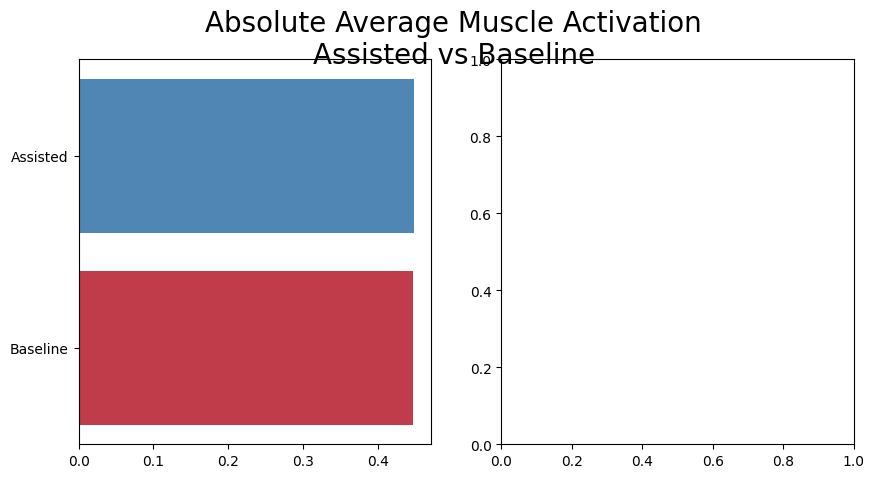

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), squeeze=False)  # Ensure axs is always 2D
fig.suptitle("Absolute Average Muscle Activation\nAssisted vs Baseline", fontsize=20)
plot_dir = subject_dirs[subject][session]["plot_dir"]
filename = plot_dir / f"assisted_vs_baseline_subjects.svg"

for i, subject in enumerate(subject_data.keys()):
    for session in subject_data[subject].keys():
        df = subject_data[subject][session]["absolute_mean_activations"]
        assisted_mean = df[df["Muscle"] == "AVERAGE"][["Mean Activation", "STD Activation"]].mean()
        baseline_mean = df[df["Profile"] == "BASELINE"][["Mean Activation", "STD Activation"]].mean()
        
        # Adjusted sns.barplot to plot horizontally
        sns.barplot(y=["Assisted", "Baseline"], 
                    x=[assisted_mean["Mean Activation"], baseline_mean["Mean Activation"]],
                    orient='h', ax=axs[0, i], palette=[u'#3f88c5', u'#d72638'], hue=["Assisted", "Baseline"])  # Note the swapped x and y parameters
        
        percentage_change = (assisted_mean['Mean Activation'] - baseline_mean['Mean Activation']) / baseline_mean['Mean Activation']
        print(percentage_change)

        label_bars(ax=axs[0, i], bars=axs[0, i].patches, texts=[f"{percentage_change*100:.0f}%", "0%"], orient='h')
        
        # Adjust title, labels, and tick parameters for horizontal orientation
        axs[0, i].set_title(f"Subject {subject}", fontsize=20)
        axs[0, i].set_ylabel("Condition", fontsize=16)  # Now y-axis is "Condition"
        axs[0, i].set_xlabel("Mean Activation\n(% of MVIC)", fontsize=16)  # x-axis shows Mean Activation
        
        axs[0, i].tick_params(axis='y', labelsize=14)  # Adjust y-tick labels for "Condition"
        axs[0, i].tick_params(axis='x', labelsize=14)  # Adjust x-tick labels for Mean Activation
        
        axs[0, i].set_xlim(0, 0.5)  # Adjust x-limits to fit the data
        axs[0, i].xaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, symbol=None, decimals=0))  # Apply percent formatter to x-axis

plt.tight_layout()
plt.savefig(filename, format='svg')
plt.savefig(filename.with_suffix('.png'), dpi=500, format='png')
plt.savefig(latex_figure_dir / "emg_plots" / filename.with_suffix('.png').name, dpi=500, format="png")
plt.show()